# Pasos Previos

## Libaries

In [6]:
#Importar Librerías
 
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 10px !important;}</style>"))
import os
import shutil
import random
import glob
from sympy import *
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools as it
from PIL import Image
from IPython.display import clear_output
import random
if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you change the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir
from fastai.tabular.all import *
from skimage import data
from skimage.filters import threshold_multiotsu
import inspect
from sklearn.manifold import TSNE
from sklearn import decomposition
#from sklearn.preprocessing import scaled
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import more_itertools
from sklearn.manifold import TSNE
import cv2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import imutils
#from time import time
from featurewiz import featurewiz
import time
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2
from urllib.error import HTTPError
#init_printing() # Numeros más bonitos
import phik
from phik import resources, report
from matplotlib.colors import LogNorm, PowerNorm

Notebook directory: /home/gabriel/Desktop


## Functions

In [10]:
def potential_df(symmetry = 'None', with_z = False):

    # Generar un solo potencial, pero le tienes que decir la simetría que 
    # quieres que tenga. por defecto pondrá sin simetría.

    [x_min,x_max]=  [-1,1]
    [y_min,y_max]= [-1,1]
    [z_min,z_max] = [-1,1]
    x_num = 100 # Number of values given to x
    y_num = 100 # Number of values given to y
    z_num = 50 # Number of values given to y
    # inputs es el resultado de emparejar cada x con todas las y
    # Si x = [0,1,2] e y = [a,b], 
    # input = [[0,a],[0,b],[1,a],[1,b],[2,a],[2,b]]


    max_power = 5
    min_power = 1
    count_powers = max_power-min_power+1

    #Una función que te da un array de: [x,x^2,x^3...] entre min_power y max_power
    def powers(var): 
        powers=[]
        for i in range(min_power,max_power+1,1):
            powers.append(var**i)
        return powers

    def V(x,y):
        if symmetry=='continuous_rotation':
            c_i_s = np.random.normal(0,1, size=( count_powers))
            return np.dot(c_i_s,powers(np.sqrt(x**2+y**2)))

        if symmetry=='none':
            c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
            res = np.array([np.dot(np.array(powers(np.array(x[i]))),np.matmul(c_ij_s,powers(y[i]))) for i in range(len(x_s))])
            return res

        if symmetry=='continuous_translation':
            c_i_s = np.random.normal(0,1, size=( count_powers))
            return np.dot(c_i_s,powers(np.random.normal(0,1)*x+np.random.normal(0,1)*y)) 

        if symmetry=='discrete_translation':
            n_s=6
            ni = np.random.choice([-1,1],n_s) * np.random.normal(5,3, n_s)
            return ni[0]*np.sin(ni[1]*(x)+ni[2]*y) +ni[3]*np.cos(ni[4]*x + ni[5]*y)

        if symmetry=='reflection':
            c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
            rn1 = np.random.normal(0,1)
            rn2 = np.random.normal(0,1)
            rn3 = np.random.normal(0,1)
            rn4 = np.random.normal(0,1)
            return np.array([np.dot(powers((rn1*x[i]**2+rn2*y[i]**2)), np.matmul(c_ij_s,powers(rn3*x[i]**2+rn4*y[i]**2))) for i in range(len(x_s))])


    #write a data frame

    if with_z == False:
        inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))
        #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
        x_s , y_s = inputs.T #Separamos las parejas

        gg = V(x_s,y_s)

        data = {
              'x':x_s,        
              'y':y_s,
              'V':V(x_s,y_s)
              }

        df = pd.DataFrame(data,columns=['x','y','V'])    

    else:

        # Hay que cambiar un  poco el procedimiento para acelerar el proceso y no 
        # calcular x_num*y_num*z_num valores del potencial sino solo x_num*y_num

        inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))
        #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
        x_s , y_s = inputs.T #Separamos las parejas

        V_temp = V(x_s,y_s)

        V_vals = []

        for v in V_temp:
            V_vals.append([v]*z_num)

        V_vals = np.array(V_vals).flatten()

        inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num),np.linspace(z_min,z_max,z_num))))
        #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
        x_s , y_s, z_s = inputs.T #Separamos las parejas


        data = {
              'x':x_s,        
              'y':y_s,
              'z':z_s,
              'V':V_vals
              }

        df = pd.DataFrame(data,columns=['x','y','z','V'])


        # Para evitar divergencias y no dar tanta importancia a puntos donde el potencial es muy alto
        # agrupamos los puntos del potencial en bines. Intentamos que haya un bin por 
        # punto del potencial, pero hay puntos en los que el potencial
        # vale lo mismo. Agrupamos esos puntos en bines.

    n_attempted_bins =  len(x_s)

    binning = pd.qcut(df.V, q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
    df['bin']=binning[0]
    #n_actual_bins=len(binning[1])-1

    # Es importante normalizar los bines, para que se pueda generalizar a cualquier potencial
    df['bin']=df.bin/np.max(df.bin)

    return df


def my_interactions(df, numo_int, verbose = True):
    columnas = list(np.array(df.columns))

    # Cuadrados
    for a in columnas:
        name = a + '**2'
        df[name] = df[a]**2

    if verbose == True: print('All {} columns were squared'.format(len(columnas)))
    if numo_int > len(columnas):
        num_int = len(columnas)
        if verbose == True: print('--> Number of variables smaller than num_int. Using all {} columns'.format(num_int))
    else:
        num_int = numo_int

    columnas_cuad = list(np.array(df.columns))[len(columnas):]

    # Lineales  ax + by
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination:',k)

    if num_int > len(columnas_cuad):
        num_int = len(columnas_cuad)
    else:
        num_int = num_int

    # Lineales de cuadrados   ax^2 + by^2
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas_cuad,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination of squared variables:',k)


    # Productos de variables  axy
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            df[str(ai)+a+'*'+r_sam[i+j+1]] = ai*df[a]*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by products of variables:',k)


    # Cociente de variables  ax/y
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            df[str(ai)+a+'/'+r_sam[i+j+1]] = ai*df[a]/df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by quotient of variables:',k)

    # Product of Random powers
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[a+'^'+str(ai)+'*'+r_sam[i+j+1]+'^'+str(bi)] = df[a]**ai*df[r_sam[i+j+1]]**bi
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by product of variables with random powers:',k)

    '''
    # Exponenciación
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas+columnas_cuad,num_int*2)
    for a,i in zip(r_sam,range(num_int*2)):
        #np.random.seed(int(time.time())+i+j)
        ai = 2*np.random.rand()-1    
        df['exp('+a+')'] = ai*np.exp(df[a])
        k+= 1

    if verbose == True: print('Total number of columns created by exponentiation of variables and squares:',k)

    # Logaritmos
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        #np.random.seed(int(time.time())+i+j)
        ai = 2*np.random.rand()-1    
        df['log(abs('+a+'))'] = ai*np.log(np.abs(df[a]))
        k+= 1
        
    if verbose == True: print('Total number of columns created by taking log of abs. variables:',k)
    '''
    
    # Raices
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        #np.random.seed(int(time.time())+i+j)
        ai = 2*np.random.rand()-1    
        df['sqrt(abs('+a+'))'] = ai*np.sqrt(np.abs(df[a]))
        k+= 1
        
        
    if verbose == True: print('Total number of columns created by taking the square root of abs. variables:',k)

    if verbose == True: print('   Regularising...')
    for a in df.columns:
        df[a] = np.nan_to_num(df[a])



    if verbose == True: print('\n Total number of features:',len(list(np.array(df.columns))))
    
    
    return df

def my_interactions_small(df, numo_int, verbose = True):
    columnas = list(np.array(df.columns))

    # Cuadrados
    for a in columnas:
        name = a + '**2'
        df[name] = df[a]**2

    if verbose == True: print('All {} columns were squared'.format(len(columnas)))
    if numo_int > len(columnas):
        num_int = len(columnas)
        if verbose == True: print('--> Number of variables smaller than num_int. Using all {} columns'.format(num_int))
    else:
        num_int = numo_int

    columnas_cuad = list(np.array(df.columns))[len(columnas):]

    '''    # Lineales  ax + by
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination:',k)

        
    # Lineales de cuadrados   ax^2 + by^2
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas_cuad,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination of squared variables:',k)'''
        
        
    # Lineales  ax + by
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination:',k)

        
    # Lineales de cuadrados   ax^2 + by^2
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas_cuad,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination of squared variables:',k)
        
        
    if num_int > len(columnas_cuad):
        num_int = len(columnas_cuad)
    else:
        num_int = num_int

    
    if verbose == True: print('   Regularising...')
    for a in df.columns:
        df[a] = np.nan_to_num(df[a])



    if verbose == True: print('\n Total number of features:',len(list(np.array(df.columns))))
    
    
    return df



def fast_feat_imp_rf(df,target, graph = True):
    
    #Tiens un DataFrame con datos en columnas y un objetivo (target) que quieres predecir.
    #target es un string que tiene que ser el nombre de la columna objetivo
    
    def rf(xs, y, n_estimators=100, max_samples=300,
           max_features=0.8, min_samples_leaf=5, **kwargs):
        return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
            max_samples=max_samples, max_features=max_features,
            min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

    # ----- Separar en data + targets -------#
    xs = df.drop(target,axis = 1)
    y = df[[target]]

    # ----Modelo Random Forests ----#
    m = rf(xs, y);
    #print('Accuracy trainig = ', accu(m.predict(xs),y))

    # Feature Importance usando Random Forests
    def rf_feat_importance(m, df):
        return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                           ).sort_values('imp', ascending=False)

    fi = rf_feat_importance(m, xs)

    if graph == True:
        fi.iloc[np.where(fi.imp > 0.01)].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
        plt.title('Feature Importance > 1%. Target = '+target,fontsize = 22)
        plt.show()   
    
    return list(fi.cols), list(fi.imp)


def mock_data(sym = 'reflection',num_bas = 5, plote = False, num_int = 10, verbose = True): 
    # ---------------------------- Opciones -----------------------------------#
    
    #num_bas = 5 # Numero de columnas random
    #plote = False # Mostrar el potencial en gráficas
    #num_int = 10 #Numero de columnas seleccionadas al azar que usamos para interacciones

    #---------------------------------------------------------------------------#
    # Generar Potencial

    df = potential_df(symmetry = sym, with_z = False)
    bins = df.bin # Objetivos: bin
    df = df.drop('V',axis = 1)
    df = df.drop('bin',axis = 1)

    # Añadir columnas de basura
    for i in range(num_bas):
        #np.random.seed(int(time.time())+i)
        name = 'r' + str(i)
        df[name] = 2*np.random.rand(len(df.x))-1

    if verbose == True: print('{} columns with random numbers between [-1,1] were created'.format(i+1))

    if plote == True:
        ax2 = plt.axes(projection='3d')
        ax2.plot_trisurf(df.x, df.y, df.bin, linewidth=0.2, cmap = 'jet')
        plt.title('bin(x,y)')
        plt.show()
        plt.figure()
        plt.scatter(df.x,df.y,c = df.bin,marker = '.', lw = 5)
        
    df_fin = my_interactions(df,num_int, verbose = verbose)
    df_fin['bin'] = bins
    
    return df_fin


def two_best_nn(df,target, verbose = 1, select_2k = True):
    
    from IPython.utils import io
    
    # Hyperparameters: 
    bs_choices = [50000]       # Batch Size
    shape='pipe'               # Shape of the neural network
    layers_choices = [5]       # Number of layers of the net. Default:10 or 5 results with 5
    neurons_choices = [50]    # Number of neurons per layer. Default:200 results with 200
    epoch_choices = [60]      # Number of training epochs. Default:200 results with 60
    lr_choices = [0.01]       # Max learning rate 
    valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
    monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved
    
    df2 = df.copy()
    
    if select_2k == True:
        if len(df[target]) <= 2000:
            print('Too little data to keep 2k points and discard the rest')
        else:
            print('Keeping 2k points of the original DF')
            remove_n = len(df[target]) - 2000
            drop_indices = np.random.choice(df.index, remove_n, replace=False)
            df_temp = df.drop(drop_indices)
            df = df_temp.copy()


    # ------------------- First Feature ----------------------- #

    nrmse = np.inf
    i = 0

    feats = np.array(df.drop(target, axis = 1).columns)

    num_pot = len(feats)

    from time import time
    start_time = time()

    if verbose == 1 or verbose == 2: print('------- Selecting First Feature ------------')

    for feat in feats:
        i+=1
        df2 = df.copy() 

        splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

        to = TabularPandas(df2,
                        procs=[Categorify,FillMissing, Normalize],
                        cont_names = feat,
                        y_names = target,
                        splits=splits)

        train_size = len(splits[0])
        valid_size = len(splits[1])

        # ----------------- Hyperparameters ------------------- #

        # Batch Size (a large one)
        bs=min(random.choice(bs_choices),train_size)  
        if i == 1: 
            if verbose == 1 or verbose == 2: print('{} batch size for training.\n'.format(bs))

        # Neurons per layer
        neurons_per_layer = random.choice(neurons_choices)

        # Number of layers
        n_layers = random.choice(layers_choices)

        #Shape of the net: Pipe or funnel
        if shape == 'pipe':
            layers=[neurons_per_layer for i in range(n_layers)]

        if shape == 'funnel':
            n_eff = n_layers
            layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

        if i == 1: 
            if verbose == 1 or verbose == 2: print('Training FCNN with layers: ',layers)

        #Number of epochs
        n_epoch=random.choice(epoch_choices)
        if i == 1: 
            if verbose == 1 or verbose == 2: print('Training for {} epochs.'.format(n_epoch))

        # Maximum Learning Rate: (a good value can be found using learn.lr_find())
        lr_max=float(random.choice(lr_choices))
        if i == 1: 
            if verbose == 1 or verbose == 2: print('Using lr_max = ',format(lr_max))

        # ----------------------------------------------------- #

        # --------------- Training the FCNN --------------------#

        # Load the data into a DataLoader
        dls = to.dataloaders(bs=bs)

        # Define a Tabular Learner
        learn = tabular_learner(dls, layers=layers
                            #,config=config
                            #,metrics=[mse],
                            #y_range = [min(df[target]),max(df[target])],
                            #,cbs=ShowGraphCallback()
                            #,train_bn=False)
                            )

        # Train the net 
        with io.capture_output() as captured:
            with learn.no_logging():
                learn.fit_one_cycle(n_epoch=n_epoch
                                    ,lr_max=lr_max
                                    ,cbs=[SaveModelCallback(monitor=monitor)]
                                    )


            preds, targs = learn.get_preds()

        #RMSE
        ff = (preds-targs)**2/len(targs)
        ff = sum(ff)
        RMSE = np.sqrt(ff)
        #print('RMSE:',float(RMSE))
        nrmsei = float(RMSE)
        #print('Normalized RMSE:',float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))*100,'%')

        if nrmsei < nrmse:
            nrmse = nrmsei
            best_f0 = feat
            if verbose == 1 or verbose == 2: print('Better feature found: {}, with RMSE {}'.format(best_f0,nrmsei))

        minutes_until_now = (time() - start_time)/60
        images_done = i
        minutes_per_image = minutes_until_now/(images_done)
        hours_left = minutes_per_image * (num_pot-images_done)/60

        if i%20 == 0:
            if verbose == 2: 
                print("\n{} features studied out of {}.\n".format(images_done,num_pot))
                print("{:.1f} minutes elapsed for {} features.".format(minutes_until_now,images_done))
                print("{:.1f} minutes average per feature.".format(minutes_until_now/images_done))
                print("{:.1f} minutes estimated left for {} features.\n\n\n".format(hours_left*60,num_pot-images_done))
                #print("{:.1f} hours estimated left for {} features.\n\n\n".format(hours_left,num_pot-images_done))

        if i == 10:
            if verbose == 1 or verbose == 2: print('Total time estimated for finding both features: {} minutes'.format(np.round(2*hours_left*60,2)))






    # ------------------- Second Feature ----------------------- #

    nrmse = np.inf
    i = 0

    feats = np.array(df.drop(target, axis = 1).drop(best_f0, axis = 1).columns)

    num_pot = len(feats)

    from time import time
    start_time = time()

    if verbose == 1 or verbose == 2: print('------- Selecting Second Feature ------------')

    for feat in feats:
        i+=1
        df2 = df.copy() 

        splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

        to = TabularPandas(df2,
                        procs=[Categorify,FillMissing, Normalize],
                        cont_names = [feat,best_f0],
                        y_names = target,
                        splits=splits)

        train_size = len(splits[0])
        valid_size = len(splits[1])

        # ----------------- Hyperparameters ------------------- #

        # Batch Size (a large one)
        bs=min(random.choice(bs_choices),train_size)  
        if i == 1: 
            if verbose == 1 or verbose == 2: print('{} batch size for training.\n'.format(bs))

        # Neurons per layer
        neurons_per_layer = random.choice(neurons_choices)

        # Number of layers
        n_layers = random.choice(layers_choices)

        #Shape of the net: Pipe or funnel
        if shape == 'pipe':
            layers=[neurons_per_layer for i in range(n_layers)]

        if shape == 'funnel':
            n_eff = n_layers
            layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

        if i == 1: 
            if verbose == 1 or verbose == 2: print('Training FCNN with layers: ',layers)

        #Number of epochs
        n_epoch=random.choice(epoch_choices)
        if i == 1: 
            if verbose == 1 or verbose == 2: print('Training for {} epochs.'.format(n_epoch))

        # Maximum Learning Rate: (a good value can be found using learn.lr_find())
        lr_max=float(random.choice(lr_choices))
        if i == 1: 
            if verbose == 1 or verbose == 2: print('Using lr_max = ',format(lr_max))

        # ----------------------------------------------------- #

        # --------------- Training the FCNN --------------------#

        # Load the data into a DataLoader
        dls = to.dataloaders(bs=bs)

        # Define a Tabular Learner
        learn = tabular_learner(dls, layers=layers
                            #,config=config
                            #,metrics=[mse],
                            #y_range = [min(df[target]),max(df[target])],
                            #,cbs=ShowGraphCallback()
                            #,train_bn=False)
                            )

        # Train the net 
        with io.capture_output() as captured:
            with learn.no_logging():
                learn.fit_one_cycle(n_epoch=n_epoch
                                    ,lr_max=lr_max
                                    ,cbs=[SaveModelCallback(monitor=monitor)]
                                    )


            preds, targs = learn.get_preds()

        #RMSE
        ff = (preds-targs)**2/len(targs)
        ff = sum(ff)
        RMSE = np.sqrt(ff)
        #print('RMSE:',float(RMSE))
        nrmsei = float(RMSE)
        #print('Normalized RMSE:',float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))*100,'%')

        if nrmsei < nrmse:
            nrmse = nrmsei
            best_f1 = feat
            if verbose == 1 or verbose == 2: print('Better feature found: {}'.format(best_f1))

        minutes_until_now = (time() - start_time)/60
        images_done = i
        minutes_per_image = minutes_until_now/(images_done)
        hours_left = minutes_per_image * (num_pot-images_done)/60

        if i%20 == 0:
            if verbose == 2: 
                print("\n{} features studied out of {}.\n".format(images_done,num_pot))
                print("{:.1f} minutes elapsed for {} features.".format(minutes_until_now,images_done))
                print("{:.1f} minutes average per feature.".format(minutes_until_now/images_done))
                print("{:.1f} minutes estimated left for {} features.\n\n\n".format(hours_left*60,num_pot-images_done))
                #print("{:.1f} hours estimated left for {} features.\n\n\n".format(hours_left,num_pot-images_done))
            
    
    two_best = [best_f0,best_f1]
    if verbose == 2: print('Two Best features:', two_best)

    return two_best


def two_best_phi_k(df, target):
    from IPython.utils import io
    with io.capture_output() as captured: phik_m = df.phik_matrix().abs()
    corrs_tar = phik_m[target].iloc[:-1]
    best = corrs_tar.sort_values().iloc[-20:].index[-1]
    corrs_f1 = phik_m[best].iloc[:-1]
    # Corr. target - corr. feature 1 (maximize the correlation with the target while minimizing the correlation with the first feature)
    met = corrs_tar*(1 - corrs_f1)
    sec_best = met.sort_values().iloc[-20:-1].index[-1]
    return [best, sec_best]



def two_best_rf(df, target):
    n_f = len(df)
    best_feat, imp = fast_feat_imp_rf(df.astype(np.float32),target = target, graph = False)
    cm_rf = df[best_feat[:n_f]].corr()

    corr_imp = np.exp(np.array(imp[:n_f]))*((1-np.abs(cm_rf.iloc[:,0]))**2)

    two_best = [best_feat[0],(corr_imp.iloc[1:].sort_values()).index[-1]]
    
    return two_best


def two_best_rf_phi_k(df, target, n = 50, lim_corr = 0.85):
    from IPython.utils import io
    
    df = df.reindex(columns = random.sample(list(df.columns),len(list(df.columns)))) #shuffle the columns

    # Drop some variables that are highly correlated between them
    tares = df[target]
    df.drop(target, axis = 1)
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
    df = df.drop(to_drop, axis=1)
    df[target] = tares

    if len(df) > n:
        n_f = n
    else:
        n_f = len(df)

    best_feat, imp = fast_feat_imp_rf(df,target = target, graph = False)
    with io.capture_output() as captured: cm_rf = df[best_feat[:n_f] + [target]].phik_matrix()
        
    corrs_tar = cm_rf[target].iloc[:-1]
    corrs_f1 = cm_rf[best_feat[0]].iloc[:-1]

    corr_imp = (((np.abs(corrs_tar)**2)*(1-np.abs(corrs_f1))))#*(np.exp(np.array(imp[:n_f])))

    two_best = [best_feat[0],(corr_imp.iloc[1:].sort_values()).index[-1]]
    
    return two_best




def n_best_phi_k(df, target, n):
    from IPython.utils import io
    with io.capture_output() as captured: phik_m = df.phik_matrix().abs()
    corrs_tar = phik_m[target].iloc[:-1]
    
    if n > len(corrs_tar):
        n = len(corrs_tar)
        print('Only {} features found'.format(n))
        n = n+1
    
    n = -1*n
    
    
    best = corrs_tar.sort_values().index[n:]
   
    return best


def n_best_rf_phi_k(df, target, n = 10, nf = 'auto', lim_corr = 0.9):
    
    #Devuelve un dataframe con las features más importantes y su puntuación, usando RF y phi_k
    
    # n is the number of features we want to get at the end
    # nf is the number of features, in order of importance, selected to do the phi_k correlation with the target
    # nf = 'auto' -> len(df)/3
    
    df_best_0 = pd.DataFrame(columns = ['f1','f2','score'])
    
    from IPython.utils import io
    
    df = df.reindex(columns = random.sample(list(df.columns),len(list(df.columns)))) #shuffle the columns

    # Drop some variables that are highly correlated between them
    tares = df[target]
    df = df.drop(target, axis = 1)
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
    df = df.drop(to_drop, axis=1)
    df[target] = tares
    
    if nf == 'auto':
        n_f = int(len(df)/3)
    else:
        n_f = nf
        
    if n > len(df):
        n = len(df)
        print('Only {} features found'.format(n))
        n = n+1
        if n_f <= n:
            n_f = n-1
    else:
        if n_f < n:
            n_f = n
            
    df = regularize_df(df).copy()
    

    best_feat, imp = fast_feat_imp_rf(df,target = target, graph = False)
    with io.capture_output() as captured: cm_rf = df[best_feat[:n_f] + [target]].phik_matrix()
        
    
    cm_rf = cm_rf.sort_values(target, ascending = False)
    cm_rf = cm_rf.reindex(columns = cm_rf.index)

    corrs_tar = cm_rf[target].iloc[1:]

    a = cm_rf.columns[1:n+1]
    
    #print(a)
    
    for r in range(len(a)):
        for rr in range(len(a)-r-1):
            
            #print('\n',a[r],a[rr+r+1],'\n')

            feas = [a[r],a[rr+r+1]]      
            
            #correlations with target
            ct1 = corrs_tar[a[r]]
            ct2 = corrs_tar[a[rr+r+1]]

            corrs_f1 = cm_rf[a[r]][a[rr+r+1]]
    
            corr_imp = (((np.abs(ct1*ct2))**2*(1-np.abs(corrs_f1))))#*(np.exp(np.array(imp[:n_f])))

            #df_temp_0['f1'] = [a[r]]
            #df_temp_0['f2'] = [a[rr+r+1]]
            #df_temp_0['score'] = [corr_imp]
            
            df_temp_0 = pd.DataFrame({'f1':a[r],'f2':a[rr+r+1],'score':corr_imp},index = [0])
            
            df_best_0 = pd.concat([df_best_0,df_temp_0] , ignore_index = True)
            
    
    return df_best_0.sort_values('score', ascending = False).reset_index().drop('index', axis = 1)



def pca_sym_finder(path, plote = False):

    # Le das la dirección de una PCA y te dice las simetrías que encuentra    

    ima = path

    nom_carp = 'PCAs_detector_sym_new'

    #import libraries
    %config InlineBackend.figure_format = 'retina'
    import seaborn as sns
    from IPython.core.display import display, HTML, clear_output
    display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 0px !important;}</style>"))

    from time import time
    import os
    import glob
    from fastai.vision.all import load_learner, PILImage
    import numpy as np
    from IPython.display import clear_output
    import itertools as it
    import more_itertools
    #import torchvision.models
    import plotly.express as px
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.io as pio
    pio.templates.default ="none"
    import base64
    from PIL import Image
    from io import BytesIO
    import torch
    import gc
    #import libraries


    learn = load_learner('/home/gabriel/Desktop/models/model_90_accu_resnet18_one_cycle_10+5_no_mixup'+'.pkl', cpu=False)

    sims = pd.DataFrame(columns = learn.dls.vocab)
    errs = sims.copy()

    num_img_cat = [] #guardo el numero de imagenes de cada categoria
    i = 0
    plote = False

    from IPython.utils import io

    with io.capture_output() as captured:

        test_im_dir = ima

        im = PILImage.create(test_im_dir)

        # Orden: ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']

        cate, num_cat, probs = learn.predict(im)


    m_probs = np.array(probs)
    #print(learn.dls.vocab)
    #print(m_probs)      
    
    return pd.DataFrame({'symmetry':learn.dls.vocab, 'value':m_probs})



def res_plot(df_e, results, num = 0, logs = True):
    f1 = results.feature_1[num]
    f2 = results.feature_2[num]
    if logs == True:
        c = np.log(df_e[target])
    else:
        c = df_e[target]

    plt.figure()
    plt.axis('equal')
    plt.scatter(df_e[f1],df_e[f2], c = c ,marker = 'o')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title('color = {}'.format(target))
    plt.colorbar()
    plt.show()
    plt.figure()
    ax2 = plt.axes(projection='3d')
    ax2.plot_trisurf(df_e[f1], df_e[f2], c, linewidth=0.2, cmap = 'jet')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()
    

def regularize_df(df):
    lim = 35
    df = df.reset_index().drop('index', axis = 1)
    for col in df.columns:
        df[col] = np.nan_to_num(df[col])
        if len(df[col].iloc[np.where(np.abs(df[col]) > 10**lim)]) > 0:
            for i in range(len(df[col])):
                if (df[col][i]) > 10**lim: df[col][i] = 10**lim
                elif (df[col][i]) < -10**lim: df[col][i] = -10**lim
    
    return df



def pca_sym_finder_Z2_none(path, plote = False):

    # Le das la dirección de una PCA y te dice las simetrías que encuentra    

    ima = path

    nom_carp = 'PCAs_detector_sym_new'

    #import libraries
    %config InlineBackend.figure_format = 'retina'
    import seaborn as sns
    from IPython.core.display import display, HTML, clear_output
    display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 0px !important;}</style>"))

    from time import time
    import os
    import glob
    from fastai.vision.all import load_learner, PILImage
    import numpy as np
    from IPython.display import clear_output
    import itertools as it
    import more_itertools
    #import torchvision.models
    import plotly.express as px
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.io as pio
    pio.templates.default ="none"
    import base64
    from PIL import Image
    from io import BytesIO
    import torch
    import gc
    #import libraries


    learn = load_learner('/home/gabriel/Desktop/models/model_93_accu_resnet18_10+5_none+reflection'+'.pkl', cpu=False)

    sims = pd.DataFrame(columns = learn.dls.vocab)
    errs = sims.copy()

    num_img_cat = [] #guardo el numero de imagenes de cada categoria
    i = 0
    plote = False

    from IPython.utils import io

    with io.capture_output() as captured:

        test_im_dir = ima

        im = PILImage.create(test_im_dir)

        # Orden: ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']

        cate, num_cat, probs = learn.predict(im)


    m_probs = np.array(probs)
    #print(learn.dls.vocab)
    #print(m_probs)      
    
    return pd.DataFrame({'symmetry':learn.dls.vocab, 'value':m_probs})

# Symmetry in Databases

In [9]:
# ----------------------------- Read the Database -------------------------------#
link_db = 'https://www.ine.es/ftp/microdatos/salarial/datos_2018.zip'

try:
    r = urllib2.urlopen(link_db).read()
    file = ZipFile(BytesIO(r))
    salaries_csv = file.open('CSV/EES_2018.csv')

    df = pd.read_csv(salaries_csv, sep = '\t', low_memory=False)

except HTTPError:
    print('ERROR: Fichero no encontrado')


df['SALTOTAL'] = df['SALBASE'] + df['COMSAL'] #Lo que cobra cada uno: Salario base + complementos



# ---------------------------------------Embedding using Fastai -----------------------------#
# Categorical variables --> Numerical Variables

# Choice of features
cont_names = ['JAP','HEXTRA','JSP1']
cat_names = ['CNACE', 'CNO1', 'SEXO', 'TIPOPAIS','ESTU','NUTS1','ANOS2']


splits = RandomSplitter(valid_pct=0)(range_of(df))

to = TabularPandas(df,
                procs=[Categorify,FillMissing],
                cat_names = cat_names,
                cont_names = cont_names,
                y_names = 'SALTOTAL',
                splits=splits)


#equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
#equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

df_e = pd.DataFrame(to.xs)
df_e['SALTOTAL'] = to.y
df_e = df_e.reset_index().drop('index', axis = 1)
          


Keeping 10k points of the original DF
All 10 columns were squared
Total number of columns created by linear combination: 45
Total number of columns created by linear combination of squared variables: 45
   Regularising...

 Total number of features: 110
---Selecting Best Features---
Best Features:  ['1ANOS2+1ESTU', '1TIPOPAIS+1CNO1', '1CNO1**2+1SEXO**2', '1JSP1+1CNO1', '1CNACE+1CNO1', '1NUTS1**2+1ESTU**2', '1NUTS1**2+1CNO1**2', '1JSP1**2+1ESTU**2', '1HEXTRA**2+1ESTU**2', '1CNO1**2+1ESTU**2']
1ANOS2+1ESTU 1TIPOPAIS+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1TIPOPAIS+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1TIPOPAIS+1CNO1_/DB_2_11637665676__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1TIPOPAIS+1CNO1, with prob. 1.0

1 PCA's made out of 23.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
2.4 minutes estimated left for 22 images.



0.0 hours estimated left for 22 images.



1ANOS2+1ESTU 1CNO1**2+1SEXO**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1CNO1**2+1SEXO**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1CNO1**2+1SEXO**2_/DB_2_11637665682__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1CNO1**2+1SEXO**2, with prob. 1.0

2 PCA's made out of 23.

0.2 minutes elapsed for 2 images.
0.1 minutes average per image.
2.0 minutes estimated left for 21 images.



0.0 hours estimated left for 21 images.



1ANOS2+1ESTU 1JSP1+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1JSP1+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1JSP1+1CNO1_/DB_2_11637665687__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1JSP1+1CNO1, with prob. 1.0

3 PCA's made out of 23.

0.3 minutes elapsed for 3 images.
0.1 minutes average per image.
1.9 minutes estimated left for 20 images.



0.0 hours estimated left for 20 images.



1ANOS2+1ESTU 1CNACE+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1CNACE+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1CNACE+1CNO1_/DB_2_11637665692__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1CNACE+1CNO1, with prob. 1.0

4 PCA's made out of 23.

0.4 minutes elapsed for 4 images.
0.1 minutes average per image.
1.8 minutes estimated left for 19 images.



0.0 hours estimated left for 19 images.



1ANOS2+1ESTU 1NUTS1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1NUTS1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1NUTS1**2+1ESTU**2_/DB_2_11637665698__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1NUTS1**2+1ESTU**2, with prob. 1.0

5 PCA's made out of 23.

0.5 minutes elapsed for 5 images.
0.1 minutes average per image.
1.7 minutes estimated left for 18 images.



0.0 hours estimated left for 18 images.



1TIPOPAIS+1CNO1 1NUTS1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1NUTS1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1NUTS1**2+1ESTU**2_/DB_2_11637665703__PCA.png



Found reflection symmetry with features 1TIPOPAIS+1CNO1 and 1NUTS1**2+1ESTU**2, with prob. 1.0

6 PCA's made out of 23.

0.5 minutes elapsed for 6 images.
0.1 minutes average per image.
1.5 minutes estimated left for 17 images.



0.0 hours estimated left for 17 images.



1ANOS2+1ESTU 1NUTS1**2+1CNO1**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1NUTS1**2+1CNO1**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1NUTS1**2+1CNO1**2_/DB_2_11637665708__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1NUTS1**2+1CNO1**2, with prob. 1.0

7 PCA's made out of 23.

0.6 minutes elapsed for 7 images.
0.1 minutes average per image.
1.4 minutes estimated left for 16 images.



0.0 hours estimated left for 16 images.



1CNO1**2+1SEXO**2 1NUTS1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1CNO1**2+1SEXO**2+1NUTS1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1CNO1**2+1SEXO**2+1NUTS1**2+1ESTU**2_/DB_2_11637665713__PCA.png



Found reflection symmetry with features 1CNO1**2+1SEXO**2 and 1NUTS1**2+1ESTU**2, with prob. 1.0

8 PCA's made out of 23.

0.7 minutes elapsed for 8 images.
0.1 minutes average per image.
1.4 minutes estimated left for 15 images.



0.0 hours estimated left for 15 images.



1ANOS2+1ESTU 1JSP1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1JSP1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1JSP1**2+1ESTU**2_/DB_2_11637665718__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1JSP1**2+1ESTU**2, with prob. 1.0

9 PCA's made out of 23.

0.8 minutes elapsed for 9 images.
0.1 minutes average per image.
1.3 minutes estimated left for 14 images.



0.0 hours estimated left for 14 images.



1ANOS2+1ESTU 1HEXTRA**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1HEXTRA**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1HEXTRA**2+1ESTU**2_/DB_2_11637665724__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1HEXTRA**2+1ESTU**2, with prob. 0.9667999744415283

10 PCA's made out of 23.

0.9 minutes elapsed for 10 images.
0.1 minutes average per image.
1.2 minutes estimated left for 13 images.



0.0 hours estimated left for 13 images.



1ANOS2+1ESTU 1CNO1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1CNO1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1ANOS2+1ESTU+1CNO1**2+1ESTU**2_/DB_2_11637665729__PCA.png



Found reflection symmetry with features 1ANOS2+1ESTU and 1CNO1**2+1ESTU**2, with prob. 1.0

11 PCA's made out of 23.

1.0 minutes elapsed for 11 images.
0.1 minutes average per image.
1.1 minutes estimated left for 12 images.



0.0 hours estimated left for 12 images.



1TIPOPAIS+1CNO1 1JSP1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1JSP1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1JSP1**2+1ESTU**2_/DB_2_11637665734__PCA.png



Found reflection symmetry with features 1TIPOPAIS+1CNO1 and 1JSP1**2+1ESTU**2, with prob. 1.0

12 PCA's made out of 23.

1.1 minutes elapsed for 12 images.
0.1 minutes average per image.
1.0 minutes estimated left for 11 images.



0.0 hours estimated left for 11 images.



1TIPOPAIS+1CNO1 1HEXTRA**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1HEXTRA**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1HEXTRA**2+1ESTU**2_/DB_2_11637665740__PCA.png



Found reflection symmetry with features 1TIPOPAIS+1CNO1 and 1HEXTRA**2+1ESTU**2, with prob. 1.0

13 PCA's made out of 23.

1.2 minutes elapsed for 13 images.
0.1 minutes average per image.
0.9 minutes estimated left for 10 images.



0.0 hours estimated left for 10 images.



1NUTS1**2+1ESTU**2 1JSP1+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1JSP1+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1JSP1+1CNO1_/DB_2_11637665745__PCA.png



Found reflection symmetry with features 1NUTS1**2+1ESTU**2 and 1JSP1+1CNO1, with prob. 1.0

14 PCA's made out of 23.

1.2 minutes elapsed for 14 images.
0.1 minutes average per image.
0.8 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



1NUTS1**2+1ESTU**2 1CNACE+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1CNACE+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1CNACE+1CNO1_/DB_2_11637665750__PCA.png



Found reflection symmetry with features 1NUTS1**2+1ESTU**2 and 1CNACE+1CNO1, with prob. 1.0

15 PCA's made out of 23.

1.3 minutes elapsed for 15 images.
0.1 minutes average per image.
0.7 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



1TIPOPAIS+1CNO1 1JSP1+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1JSP1+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1TIPOPAIS+1CNO1+1JSP1+1CNO1_/DB_2_11637665755__PCA.png



Found reflection symmetry with features 1TIPOPAIS+1CNO1 and 1JSP1+1CNO1, with prob. 1.0

16 PCA's made out of 23.

1.4 minutes elapsed for 16 images.
0.1 minutes average per image.
0.6 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



1CNO1**2+1SEXO**2 1HEXTRA**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1CNO1**2+1SEXO**2+1HEXTRA**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1CNO1**2+1SEXO**2+1HEXTRA**2+1ESTU**2_/DB_2_11637665761__PCA.png



Found reflection symmetry with features 1CNO1**2+1SEXO**2 and 1HEXTRA**2+1ESTU**2, with prob. 1.0

17 PCA's made out of 23.

1.5 minutes elapsed for 17 images.
0.1 minutes average per image.
0.5 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



1CNO1**2+1SEXO**2 1JSP1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1CNO1**2+1SEXO**2+1JSP1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1CNO1**2+1SEXO**2+1JSP1**2+1ESTU**2_/DB_2_11637665766__PCA.png



Found reflection symmetry with features 1CNO1**2+1SEXO**2 and 1JSP1**2+1ESTU**2, with prob. 1.0

18 PCA's made out of 23.

1.6 minutes elapsed for 18 images.
0.1 minutes average per image.
0.4 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



1JSP1+1CNO1 1HEXTRA**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1JSP1+1CNO1+1HEXTRA**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1JSP1+1CNO1+1HEXTRA**2+1ESTU**2_/DB_2_11637665771__PCA.png



Found reflection symmetry with features 1JSP1+1CNO1 and 1HEXTRA**2+1ESTU**2, with prob. 1.0

19 PCA's made out of 23.

1.7 minutes elapsed for 19 images.
0.1 minutes average per image.
0.4 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



1JSP1+1CNO1 1CNACE+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1JSP1+1CNO1+1CNACE+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1JSP1+1CNO1+1CNACE+1CNO1_/DB_2_11637665777__PCA.png



Found reflection symmetry with features 1JSP1+1CNO1 and 1CNACE+1CNO1, with prob. 1.0

20 PCA's made out of 23.

1.8 minutes elapsed for 20 images.
0.1 minutes average per image.
0.3 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



1NUTS1**2+1ESTU**2 1HEXTRA**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1HEXTRA**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1HEXTRA**2+1ESTU**2_/DB_2_11637665782__PCA.png



Found reflection symmetry with features 1NUTS1**2+1ESTU**2 and 1HEXTRA**2+1ESTU**2, with prob. 1.0

21 PCA's made out of 23.

1.9 minutes elapsed for 21 images.
0.1 minutes average per image.
0.2 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



1NUTS1**2+1ESTU**2 1JSP1**2+1ESTU**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1JSP1**2+1ESTU**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1NUTS1**2+1ESTU**2+1JSP1**2+1ESTU**2_/DB_2_11637665787__PCA.png



Found reflection symmetry with features 1NUTS1**2+1ESTU**2 and 1JSP1**2+1ESTU**2, with prob. 1.0

22 PCA's made out of 23.

2.0 minutes elapsed for 22 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



1HEXTRA**2+1ESTU**2 1CNACE+1CNO1
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_2/_1HEXTRA**2+1ESTU**2+1CNACE+1CNO1_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_2/_1HEXTRA**2+1ESTU**2+1CNACE+1CNO1_/DB_2_11637665792__PCA.png



Found reflection symmetry with features 1HEXTRA**2+1ESTU**2 and 1CNACE+1CNO1, with prob. 1.0

23 PCA's made out of 23.

2.0 minutes elapsed for 23 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.





<BarContainer object of 5 artists>

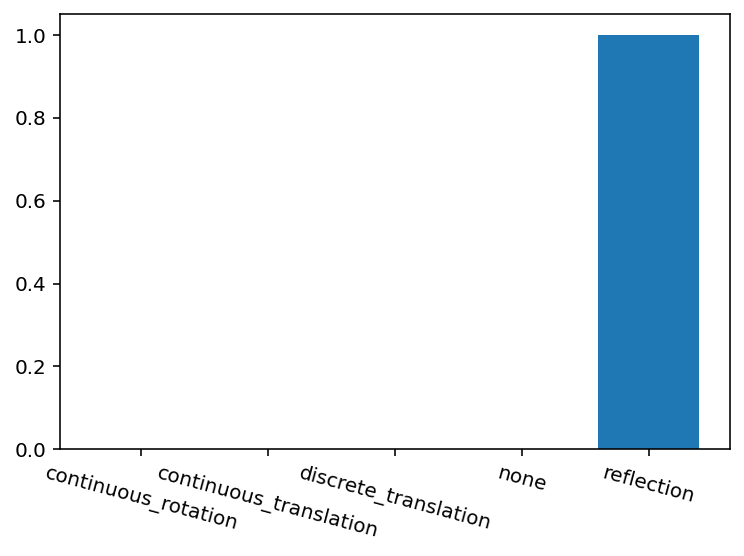

In [38]:
target = 'SALTOTAL'     # Nombre de la variable que queremos predecir
nombre_carpeta = 'DB_2' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos analizar al mismo tiempo varias bases de datos

n_fea = 10              # Número de features finales que el algoritmo escoge para hacer parejas y analizar con ellas la simetría

lim_sym = 0.85          # Límite de probabilidad para decidir que el algoritmo ha encontrado o no una simetría

limit_pairs = True      # Al generar parejas, estas vienen acompañadas de un 'score'. Si esto es True, cogmos solo la mitad de las con mayor 'score'

select_10k = True       # Keep only 10000 elements of the original potential DF (useful)

interact = True


# ------------------------------------------------------------------------------------------------------------------------#

i=0    
    
sym_feat_1 = []
sym_feat_2 = []
sym_feat_tags = []
sym_feat_probs = []
sym_feat_rmse = []
syms_tot = ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']
registro = pd.DataFrame(columns = syms_tot)
# Tiempo en el que empezamos a procesar
from time import time
start_time = time()


from fastai.vision.all import *
from time import time
from IPython.utils import io



muchos = False # Si es false, para muchos potenciales, mete cada combinación de variables en una carpeta separada, para que sea fácil ver si hay simetría ahí
               # Si es true, van todos a la misma carpeta


# ------------------- Folder PCA ------------------- #

folder = 'PCAs_DB_2'   # Carpeta donde se guardan las subcarpetas con las PCAs

dd = top_dir + '/' + folder
if not os.path.isdir(dd):
    print('Creating directory:\n',dd)
    os.mkdir(dd)

dir = os.path.join(top_dir,folder)

#------------------------------ Generar Potenciales ---------------------------#

potenciales = [df_e]
potenciales_tags = [nombre_carpeta]
tags = potenciales_tags
num_pot = len(potenciales)

# ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
# Solo hay un print que se ha eliminado del código original
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop = True
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

# ---------------- Definiciones previas e hiperparámetros ----------------- #

#Guardo los modelos para analizarlos luego
models = [] 
to_s = []

#Guardaremos los resultados de la PCA en un array 
PCA_s = []
PCA_s_tag = []

# Hyperparameters: 
bs_choices = [50000]       # Batch Size
shape='pipe'               # Shape of the neural network
layers_choices = [5]       # Number of layers of the net. Default:10 or 5 results with 5
neurons_choices = [100]    # Number of neurons per layer. Default:200 results with 200
epoch_choices = [150]      # Number of training epochs. Default:200 results with 60
lr_choices = [0.01]       # Max learning rate 
valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved



# ---------------------- Entrenar Red Y PCA -----------------------------------#

j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

for df in potenciales:
    
    df[target] = df[target]/np.max(df[target]) #Normalizar la columna objetivo es importante

    #------------------------------ Feature Importance  ---------------------------#

    if select_10k == True:
        if len(df[target]) <= 100*100:
            print('Too little data to keep 10k points and delete the rest')
        else:
            print('Keeping 10k points of the original DF')
            remove_n = len(df[target]) - 10000
            drop_indices = np.random.choice(df.index, remove_n, replace=False)
            df_temp = df.drop(drop_indices)
            df = df_temp.copy()


            
    if interact == True:
        bbb = df[target]
        df = df.drop(target,axis = 1)
        df = my_interactions_small(df, numo_int = 10, verbose = True)
        df[target] = bbb
        
    print('---Selecting Best Features---')
    best_pairs = n_best_rf_phi_k(df, target = target, n = n_fea, nf = 30, lim_corr = 0.85)

    best_n = [best_pairs['f1'][0]] + list(best_pairs['f2'].unique())

    print('Best Features: ',best_n)

    #small_df = df[best_n]
    #small_df[target] = df[target]


    cols = best_n
    a = cols

    verbose = 1



    df_org = df.copy()

    if limit_pairs == True:
        medi = best_pairs.score.median()
        num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])
    else:
        medi = 0
        num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])

    for f1,f2,lll in zip(best_pairs.f1,best_pairs.f2,range(len(best_pairs.f1))):
        if best_pairs.score[lll] >= medi:

            i+=1

            print(f1,f2)
            feas = [f1,f2]

            # Debemos marcar cada potencial para tener claro a qué tipo de simetria corresponde cada PCA
            PCA_s_tag.append(tags[j-1])

            df2 = df[feas + [target]].copy() 
            #df2 = df2[feas + [target]].copy()
            
            #Normlizamos las features y hacemos que vayan entre -1 y 1
            df2[f1] = 2*(df2[f1]/np.max(df2[f1]))-1
            df2[f2] = 2*(df2[f2]/np.max(df2[f2]))-1

            splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

            to = TabularPandas(df2,
                            procs=[Categorify,FillMissing, Normalize],
                            cont_names = feas,
                            y_names = target,
                            splits=splits)

            train_size = len(splits[0])
            valid_size = len(splits[1])

            # ----------------- Hyperparameters ------------------- #

            # Batch Size (a large one)
            bs=min(random.choice(bs_choices),train_size)  
            print('{} batch size for training.\n'.format(bs))

            # Neurons per layer
            neurons_per_layer = random.choice(neurons_choices)

            # Number of layers
            n_layers = random.choice(layers_choices)

            #Shape of the net: Pipe or funnel
            if shape == 'pipe':
                layers=[neurons_per_layer for i in range(n_layers)]

            if shape == 'funnel':
                n_eff = n_layers
                layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

            print('Training FCNN with layers: ',layers)

            #Number of epochs
            n_epoch=random.choice(epoch_choices)
            print('Training for {} epochs.'.format(n_epoch))

            # Maximum Learning Rate: (a good value can be found using learn.lr_find())
            lr_max=float(random.choice(lr_choices))
            print('Using lr_max = ',format(lr_max))

            # ----------------------------------------------------- #

            # --------------- Training the FCNN --------------------#

            # Load the data into a DataLoader
            dls = to.dataloaders(bs=bs)

            # Define a Tabular Learner
            learn = tabular_learner(dls, layers=layers
                                #,config=config
                                #,metrics=[mse],
                                #y_range = [min(df.bin),max(df.bin)],
                                #,cbs=ShowGraphCallback()
                                #,train_bn=False)
                                )

            # Train the net 
            with learn.no_logging():
                learn.fit_one_cycle(n_epoch=n_epoch
                                    ,lr_max=lr_max
                                    ,cbs=[SaveModelCallback(monitor=monitor)]
                                    )

                preds, targs = learn.get_preds()

            ff = (preds-targs)**2/len(targs)
            ff = sum(ff)
            RMSE = np.sqrt(ff)
            #print('RMSE:',float(RMSE))
            nrmsei = float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))

            # Guardamos modelos y tabular objects para el posterior analisis
            models.append(learn)
            to_s.append(to)

            # ------------------------------------------------------#


            # ------------------------- PCA ------------------------#

            test_df = df2.copy()
            dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

            # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
            # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
            with Hooks(learn.model.layers, lambda m,i,o: o) as h:
                preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

            targets=preds[2].numpy().flatten()

            # Cogemos la información de la penúltima capa
            # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
            # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
            act = h.stored[-2] 
            multi_dim=Tensor.cpu(act).numpy()
            standardized=StandardScaler().fit_transform(multi_dim)

            viz = PCA(2).fit_transform(np.nan_to_num(standardized))
            #plt.figure()
            #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')

            PCA_s.append(viz)

            # ------------------------------------------------------ #

            # ------------------ Saving the PCA's ------------------ #

            # ---- Dar formato a PCA para guardar como imagen con color

            viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
            viz.columns = ['x','y'] #Nombres de las columnas

            # Insertamos una columna con los colores de los puntos. El valor del potencial
            # objetivo (targets) es el color, y hay un color por cada punto 
            viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

            # ---- Personalizar mapa de color 

            n_classes=1000

            colors = 'rainbow'

            if colors == 'rainbow':
                my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                classes_in_rgb = my_cmap(range(n_classes))
            if colors == 'purple':
                my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

            # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
            #      acumuldos en un pixel

            n_pixels = 224

            binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

            #if we want the pixel intensity to reprensent the number of points at that location
            array = np.dot(binning_3d[0],classes_in_rgb)
            array = array/np.amax(array)

            # ---- Guardar la PCA

            #Directorio donde guardaremos las imagenes
            nami = '_'+str(feas[0])+'+'+str(feas[1])+'_'
            if muchos == False: 
                dir_sym = os.path.join(dir,tags[j-1],nami)
                img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'__PCA.png' 
            else:
                dir_sym = os.path.join(dir,tags[j-1])
                img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+nami+'__PCA.png' 

            if not os.path.isdir(dir_sym):
                print('Creating directory:\n',dir_sym)
                os.makedirs(dir_sym)


            # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
            output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
            plt.imsave(output_dir,array) # Guardar
            print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))


            # ------------------------ Symmetry Analyzer --------------------- #
            drr = pca_sym_finder(output_dir)
            brr = list(drr.iloc[np.where(drr.value > lim_sym)].symmetry)
            if len(brr) > 0:
                print('Found {} symmetry with features {} and {}, with prob. {}'.format(brr[0],f1,f2,float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4))))                
                sym_feat_1.append(f1)
                sym_feat_2.append(f2)
                sym_feat_tags.append(brr[0])
                sym_feat_probs.append(float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4)))
                sym_feat_rmse.append(nrmsei)




            # ------------------------ Time -------------------------#

            minutes_until_now = (time() - start_time)/60
            images_done = i
            minutes_per_image = minutes_until_now/(images_done)
            hours_left = minutes_per_image * (num_pot*num_2-images_done)/60
            print("\n{} PCA's made out of {}.\n".format(images_done,num_pot*num_2))
            print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
            print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
            print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot*num_2-images_done))
            print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot*num_2-images_done))




    j+=1


          # ------------------------------------------------------#'''

results = pd.DataFrame({'symmetry':sym_feat_tags, 'feature_1':sym_feat_1, 'feature_2':sym_feat_2, 'probability':sym_feat_probs, 'NRMSE':sym_feat_rmse})

vc = results.symmetry.value_counts()



for sym_sum in syms_tot:
    if not hasattr(vc,sym_sum):
        vc[sym_sum] = 0


nr = pd.DataFrame({'continuous_rotation':vc['continuous_rotation'], 
                   'continuous_translation':vc['continuous_translation'], 
                   'discrete_translation':vc['discrete_translation'], 
                   'none':vc['none'], 
                   'reflection':vc['reflection']}, index = [0])

registro = registro.append(nr, ignore_index=True)


plt.xticks(rotation = -15)
plt.bar(registro.columns,registro.sum()/registro.sum().sum())


In [50]:
results

,symmetry,feature_1,feature_2,probability,NRMSE
0,reflection,1ANOS2+1ESTU,1TIPOPAIS+1CNO1,1.0000,0.035035
1,reflection,1ANOS2+1ESTU,1CNO1**2+1SEXO**2,1.0000,0.074582
2,reflection,1ANOS2+1ESTU,1JSP1+1CNO1,1.0000,0.041955
3,reflection,1ANOS2+1ESTU,1CNACE+1CNO1,1.0000,0.036553
4,reflection,1ANOS2+1ESTU,1NUTS1**2+1ESTU**2,1.0000,0.071805
5,reflection,1TIPOPAIS+1CNO1,1NUTS1**2+1ESTU**2,1.0000,0.064890
6,reflection,1ANOS2+1ESTU,1NUTS1**2+1CNO1**2,1.0000,0.035530
7,reflection,1CNO1**2+1SEXO**2,1NUTS1**2+1ESTU**2,1.0000,0.034109
8,reflection,1ANOS2+1ESTU,1JSP1**2+1ESTU**2,1.0000,0.072253
9,reflection,1ANOS2+1ESTU,1HEXTRA**2+1ESTU**2,0.9668,0.038224


In [114]:
def res_plot(df_e, results, num = 0, logs = True):
    f1 = results.feature_1[num]
    f2 = results.feature_2[num]
    if logs == True:
        c = np.log(df_e[target])
    else:
        c = df_e[target]

    plt.figure()
    plt.scatter(df_e[f1],df_e[f2], c = c ,marker = 'o')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title('color = {}'.format(target))
    plt.colorbar()
    plt.show()
    plt.figure()
    ax2 = plt.axes(projection='3d')
    ax2.plot_trisurf(df_e[f1], df_e[f2], c, linewidth=0.2, cmap = 'jet')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

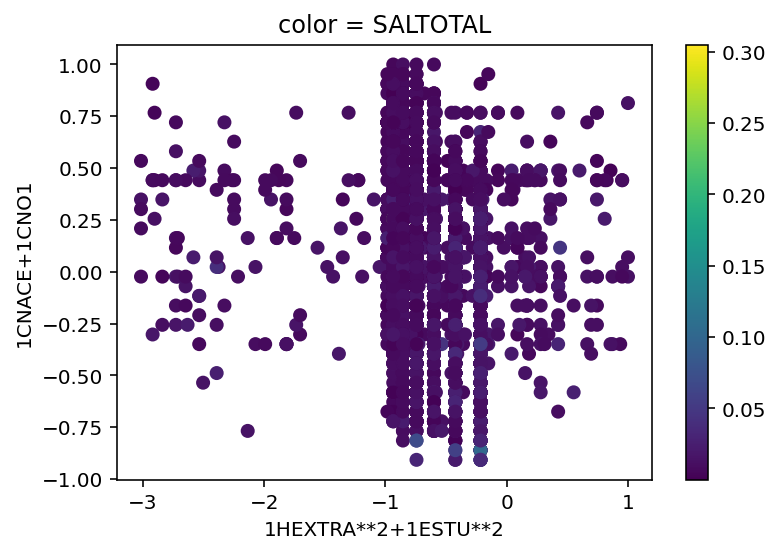

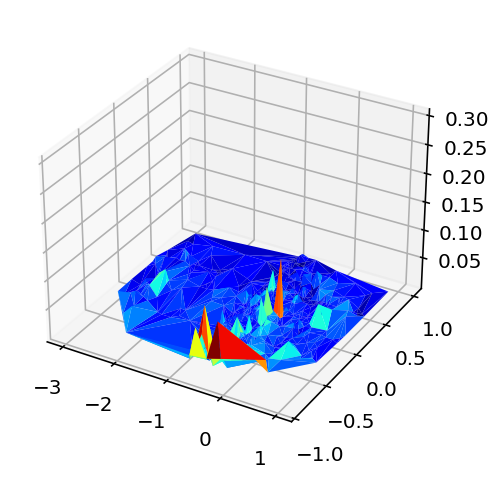

In [71]:
res_plot(df2,results,22, logs = False)

# Kaggle

In [11]:
!pip install opendatasets

In [95]:
creds = '{"username":"gabrielszalkowski","key":"36404a0345251322b628dc3c56bd25df"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

from kaggle import api
import opendatasets as od


od.download('https://www.kaggle.com/imakash3011/customer-personality-analysis')

path = Path(top_dir+'/customer-personality-analysis')
print(path.ls())

df_e = pd.read_csv(path.ls()[0], sep = '\t')

categ = []
numer = []

# ----------------------------------- #

target = 'Income'
quantiles = True

# --------------------------------------#
for col in list(df_e.columns):
    if col != target:
        if type(df_e[col][0]) == str:
            categ.append(col)
        else:
            numer.append(col)

splits = RandomSplitter(valid_pct=0)(range_of(df_e))

to = TabularPandas(df_e,
                procs=[Categorify,FillMissing],
                cat_names = categ,
                cont_names = numer,
                y_names = target,
                splits=splits)


#equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
#equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

df_e = pd.DataFrame(to.xs)
df_e[target] = to.y
df_e = df_e.reset_index().drop('index', axis = 1)  

for col in df_e.columns:
    df_e[col] = np.nan_to_num(df_e[col])   
    if quantiles == True:
        n_attempted_bins =  len(df_e[col])
        binning = pd.qcut(df_e[col], q=n_attempted_bins, retbins=True, labels=False, duplicates='drop')
        df_e[col]=binning[0]/np.max(binning[0])
        df_e[col] = np.nan_to_num(df_e[col])

df_e.head()

Skipping, found downloaded files in "./customer-personality-analysis" (use force=True to force download)
[Path('/home/gabriel/Desktop/customer-personality-analysis/marketing_campaign.csv')]


,Education,Marital_Status,Dt_Customer,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Income
0,0.142857,0.384615,0.522204,0.014739,1.000000,0.0,0.000000,0.817259,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016423
1,0.428571,0.538462,0.293586,0.921840,0.495495,0.0,0.000000,0.604061,0.354219,0.816327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.853558
2,0.714286,0.538462,0.403783,0.492184,0.909910,0.0,0.000000,0.289340,0.955723,0.734694,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.978558
3,0.428571,0.384615,0.065789,0.938812,0.639640,0.0,0.333333,0.776650,0.309942,0.908163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707117
4,0.714286,0.538462,0.522204,0.677981,0.351351,0.0,0.000000,0.228426,0.911445,0.125850,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993613


In [31]:
df_e.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

Too little data to keep 10k points and delete the rest
All 28 columns were squared
Total number of columns created by linear combination: 45
Total number of columns created by linear combination of squared variables: 45
   Regularising...

 Total number of features: 146
---Selecting Best Features---
Best Features:  ['1AcceptedCmp4+1MntWines', '1MntMeatProducts**2+1Z_Revenue**2', '1MntWines**2+1Kidhome**2', '1Teenhome+1MntMeatProducts', '1MntMeatProducts**2+1Teenhome**2', '1MntFishProducts+1NumStorePurchases', 'NumCatalogPurchases', '1AcceptedCmp4+1MntWines', '1NumWebPurchases**2+1MntWines**2', '1MntWines+1MntGoldProds', '1AcceptedCmp4+1MntMeatProducts', '1MntFishProducts+1MntMeatProducts', '1NumWebPurchases**2+1MntMeatProducts**2']
1AcceptedCmp4+1MntWines 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760661__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntWines and 1MntMeatProducts**2+1Z_Revenue**2, with prob. 1.0

1 PCA's made out of 78.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
6.2 minutes estimated left for 77 images.



0.1 hours estimated left for 77 images.



1MntMeatProducts**2+1Z_Revenue**2 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1MntWines**2+1Kidhome**2_/DB_customers_11637760664__PCA.png



Found continuous_translation symmetry with features 1MntMeatProducts**2+1Z_Revenue**2 and 1MntWines**2+1Kidhome**2, with prob. 0.8901000022888184

2 PCA's made out of 78.

0.1 minutes elapsed for 2 images.
0.1 minutes average per image.
4.9 minutes estimated left for 76 images.



0.1 hours estimated left for 76 images.



1MntWines+1MntGoldProds 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760667__PCA.png



Found none symmetry with features 1MntWines+1MntGoldProds and 1MntMeatProducts**2+1Z_Revenue**2, with prob. 0.9128999710083008

3 PCA's made out of 78.

0.2 minutes elapsed for 3 images.
0.1 minutes average per image.
4.4 minutes estimated left for 75 images.



0.1 hours estimated left for 75 images.



1MntWines+1MntFishProducts 1Teenhome+1MntMeatProducts
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1Teenhome+1MntMeatProducts_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1Teenhome+1MntMeatProducts_/DB_customers_11637760669__PCA.png




4 PCA's made out of 78.

0.2 minutes elapsed for 4 images.
0.1 minutes average per image.
4.1 minutes estimated left for 74 images.



0.1 hours estimated left for 74 images.



1Teenhome+1MntMeatProducts 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntWines**2+1Kidhome**2_/DB_customers_11637760672__PCA.png



Found reflection symmetry with features 1Teenhome+1MntMeatProducts and 1MntWines**2+1Kidhome**2, with prob. 0.9136000275611877

5 PCA's made out of 78.

0.3 minutes elapsed for 5 images.
0.1 minutes average per image.
4.0 minutes estimated left for 73 images.



0.1 hours estimated left for 73 images.



1MntWines+1MntGoldProds 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760675__PCA.png



Found none symmetry with features 1MntWines+1MntGoldProds and 1MntMeatProducts**2+1Teenhome**2, with prob. 0.9980999827384949

6 PCA's made out of 78.

0.3 minutes elapsed for 6 images.
0.1 minutes average per image.
3.9 minutes estimated left for 72 images.



0.1 hours estimated left for 72 images.



1Teenhome+1MntMeatProducts 1MntFishProducts+1NumStorePurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntFishProducts+1NumStorePurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntFishProducts+1NumStorePurchases_/DB_customers_11637760678__PCA.png



Found reflection symmetry with features 1Teenhome+1MntMeatProducts and 1MntFishProducts+1NumStorePurchases, with prob. 0.9995999932289124

7 PCA's made out of 78.

0.4 minutes elapsed for 7 images.
0.1 minutes average per image.
3.7 minutes estimated left for 71 images.



0.1 hours estimated left for 71 images.



1MntFishProducts+1MntMeatProducts 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntWines**2+1Kidhome**2_/DB_customers_11637760681__PCA.png



Found none symmetry with features 1MntFishProducts+1MntMeatProducts and 1MntWines**2+1Kidhome**2, with prob. 0.9907000064849854

8 PCA's made out of 78.

0.4 minutes elapsed for 8 images.
0.1 minutes average per image.
3.6 minutes estimated left for 70 images.



0.1 hours estimated left for 70 images.



1Teenhome+1MntMeatProducts NumCatalogPurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+NumCatalogPurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+NumCatalogPurchases_/DB_customers_11637760684__PCA.png



Found none symmetry with features 1Teenhome+1MntMeatProducts and NumCatalogPurchases, with prob. 0.9997000098228455

9 PCA's made out of 78.

0.5 minutes elapsed for 9 images.
0.1 minutes average per image.
3.5 minutes estimated left for 69 images.



0.1 hours estimated left for 69 images.



1MntFishProducts+1NumStorePurchases 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760687__PCA.png




10 PCA's made out of 78.

0.5 minutes elapsed for 10 images.
0.1 minutes average per image.
3.5 minutes estimated left for 68 images.



0.1 hours estimated left for 68 images.



1MntWines+1MntFishProducts 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760689__PCA.png




11 PCA's made out of 78.

0.6 minutes elapsed for 11 images.
0.1 minutes average per image.
3.4 minutes estimated left for 67 images.



0.1 hours estimated left for 67 images.



1MntFishProducts+1MntMeatProducts 1AcceptedCmp4+1MntWines
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1AcceptedCmp4+1MntWines_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1AcceptedCmp4+1MntWines_/DB_customers_11637760692__PCA.png



Found reflection symmetry with features 1MntFishProducts+1MntMeatProducts and 1AcceptedCmp4+1MntWines, with prob. 0.9531999826431274

12 PCA's made out of 78.

0.6 minutes elapsed for 12 images.
0.1 minutes average per image.
3.3 minutes estimated left for 66 images.



0.1 hours estimated left for 66 images.



1MntWines+1MntFishProducts 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760695__PCA.png



Found none symmetry with features 1MntWines+1MntFishProducts and 1MntMeatProducts**2+1Z_Revenue**2, with prob. 0.9940000176429749

13 PCA's made out of 78.

0.7 minutes elapsed for 13 images.
0.1 minutes average per image.
3.3 minutes estimated left for 65 images.



0.1 hours estimated left for 65 images.



1AcceptedCmp4+1MntWines 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760698__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntWines and 1MntMeatProducts**2+1Teenhome**2, with prob. 0.9937999844551086

14 PCA's made out of 78.

0.7 minutes elapsed for 14 images.
0.1 minutes average per image.
3.2 minutes estimated left for 64 images.



0.1 hours estimated left for 64 images.



1MntMeatProducts**2+1Z_Revenue**2 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760701__PCA.png



Found none symmetry with features 1MntMeatProducts**2+1Z_Revenue**2 and 1NumWebPurchases**2+1MntWines**2, with prob. 0.9711999893188477

15 PCA's made out of 78.

0.7 minutes elapsed for 15 images.
0.0 minutes average per image.
3.1 minutes estimated left for 63 images.



0.1 hours estimated left for 63 images.



1MntMeatProducts**2+1Teenhome**2 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Teenhome**2+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Teenhome**2+1MntWines**2+1Kidhome**2_/DB_customers_11637760704__PCA.png




16 PCA's made out of 78.

0.8 minutes elapsed for 16 images.
0.0 minutes average per image.
3.1 minutes estimated left for 62 images.



0.1 hours estimated left for 62 images.



1MntFishProducts+1NumStorePurchases 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760706__PCA.png



Found none symmetry with features 1MntFishProducts+1NumStorePurchases and 1MntMeatProducts**2+1Teenhome**2, with prob. 0.9954000115394592

17 PCA's made out of 78.

0.8 minutes elapsed for 17 images.
0.0 minutes average per image.
3.0 minutes estimated left for 61 images.



0.1 hours estimated left for 61 images.



1Teenhome+1MntMeatProducts 1MntWines+1MntGoldProds
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntWines+1MntGoldProds_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntWines+1MntGoldProds_/DB_customers_11637760709__PCA.png



Found none symmetry with features 1Teenhome+1MntMeatProducts and 1MntWines+1MntGoldProds, with prob. 0.9939000010490417

18 PCA's made out of 78.

0.9 minutes elapsed for 18 images.
0.0 minutes average per image.
3.0 minutes estimated left for 60 images.



0.0 hours estimated left for 60 images.



1Teenhome+1MntMeatProducts 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760712__PCA.png




19 PCA's made out of 78.

0.9 minutes elapsed for 19 images.
0.0 minutes average per image.
2.9 minutes estimated left for 59 images.



0.0 hours estimated left for 59 images.



1Teenhome+1MntMeatProducts 1AcceptedCmp4+1MntWines
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1AcceptedCmp4+1MntWines_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1AcceptedCmp4+1MntWines_/DB_customers_11637760715__PCA.png




20 PCA's made out of 78.

1.0 minutes elapsed for 20 images.
0.0 minutes average per image.
2.8 minutes estimated left for 58 images.



0.0 hours estimated left for 58 images.



1AcceptedCmp4+1MntMeatProducts 1MntWines+1MntGoldProds
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntWines+1MntGoldProds_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntWines+1MntGoldProds_/DB_customers_11637760718__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1MntWines+1MntGoldProds, with prob. 1.0

21 PCA's made out of 78.

1.0 minutes elapsed for 21 images.
0.0 minutes average per image.
2.8 minutes estimated left for 57 images.



0.0 hours estimated left for 57 images.



1MntMeatProducts**2+1Teenhome**2 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Teenhome**2+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Teenhome**2+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760721__PCA.png



Found none symmetry with features 1MntMeatProducts**2+1Teenhome**2 and 1NumWebPurchases**2+1MntWines**2, with prob. 0.9685999751091003

22 PCA's made out of 78.

1.1 minutes elapsed for 22 images.
0.0 minutes average per image.
2.8 minutes estimated left for 56 images.



0.0 hours estimated left for 56 images.



1MntFishProducts+1MntMeatProducts 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760724__PCA.png



Found none symmetry with features 1MntFishProducts+1MntMeatProducts and 1NumWebPurchases**2+1MntWines**2, with prob. 0.9017999768257141

23 PCA's made out of 78.

1.1 minutes elapsed for 23 images.
0.0 minutes average per image.
2.7 minutes estimated left for 55 images.



0.0 hours estimated left for 55 images.



1MntFishProducts+1NumStorePurchases 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntWines**2+1Kidhome**2_/DB_customers_11637760727__PCA.png



Found reflection symmetry with features 1MntFishProducts+1NumStorePurchases and 1MntWines**2+1Kidhome**2, with prob. 0.9868000149726868

24 PCA's made out of 78.

1.2 minutes elapsed for 24 images.
0.0 minutes average per image.
2.7 minutes estimated left for 54 images.



0.0 hours estimated left for 54 images.



1MntWines+1MntFishProducts 1AcceptedCmp4+1MntMeatProducts
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1AcceptedCmp4+1MntMeatProducts_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1AcceptedCmp4+1MntMeatProducts_/DB_customers_11637760730__PCA.png



Found none symmetry with features 1MntWines+1MntFishProducts and 1AcceptedCmp4+1MntMeatProducts, with prob. 0.9997000098228455

25 PCA's made out of 78.

1.2 minutes elapsed for 25 images.
0.0 minutes average per image.
2.6 minutes estimated left for 53 images.



0.0 hours estimated left for 53 images.



1AcceptedCmp4+1MntMeatProducts 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntWines**2+1Kidhome**2_/DB_customers_11637760733__PCA.png



Found continuous_translation symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1MntWines**2+1Kidhome**2, with prob. 0.9937000274658203

26 PCA's made out of 78.

1.3 minutes elapsed for 26 images.
0.0 minutes average per image.
2.6 minutes estimated left for 52 images.



0.0 hours estimated left for 52 images.



1Teenhome+1MntMeatProducts 1MntFishProducts+1MntMeatProducts
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntFishProducts+1MntMeatProducts_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntFishProducts+1MntMeatProducts_/DB_customers_11637760736__PCA.png



Found none symmetry with features 1Teenhome+1MntMeatProducts and 1MntFishProducts+1MntMeatProducts, with prob. 0.9146000146865845

27 PCA's made out of 78.

1.3 minutes elapsed for 27 images.
0.0 minutes average per image.
2.5 minutes estimated left for 51 images.



0.0 hours estimated left for 51 images.



NumCatalogPurchases 1MntFishProducts+1NumStorePurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntFishProducts+1NumStorePurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntFishProducts+1NumStorePurchases_/DB_customers_11637760738__PCA.png



Found none symmetry with features NumCatalogPurchases and 1MntFishProducts+1NumStorePurchases, with prob. 0.9975000023841858

28 PCA's made out of 78.

1.4 minutes elapsed for 28 images.
0.0 minutes average per image.
2.5 minutes estimated left for 50 images.



0.0 hours estimated left for 50 images.



1AcceptedCmp4+1MntMeatProducts 1MntFishProducts+1NumStorePurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntFishProducts+1NumStorePurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntFishProducts+1NumStorePurchases_/DB_customers_11637760741__PCA.png



Found reflection symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1MntFishProducts+1NumStorePurchases, with prob. 0.8865000009536743

29 PCA's made out of 78.

1.4 minutes elapsed for 29 images.
0.0 minutes average per image.
2.4 minutes estimated left for 49 images.



0.0 hours estimated left for 49 images.



NumCatalogPurchases 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntWines**2+1Kidhome**2_/DB_customers_11637760744__PCA.png



Found continuous_translation symmetry with features NumCatalogPurchases and 1MntWines**2+1Kidhome**2, with prob. 0.9977999925613403

30 PCA's made out of 78.

1.5 minutes elapsed for 30 images.
0.0 minutes average per image.
2.4 minutes estimated left for 48 images.



0.0 hours estimated left for 48 images.



1MntFishProducts+1MntMeatProducts 1MntWines+1MntGoldProds
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntWines+1MntGoldProds_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntWines+1MntGoldProds_/DB_customers_11637760747__PCA.png




31 PCA's made out of 78.

1.5 minutes elapsed for 31 images.
0.0 minutes average per image.
2.3 minutes estimated left for 47 images.



0.0 hours estimated left for 47 images.



1MntFishProducts+1NumStorePurchases 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760750__PCA.png



Found none symmetry with features 1MntFishProducts+1NumStorePurchases and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 1.0

32 PCA's made out of 78.

1.6 minutes elapsed for 32 images.
0.0 minutes average per image.
2.3 minutes estimated left for 46 images.



0.0 hours estimated left for 46 images.



NumCatalogPurchases 1AcceptedCmp4+1MntWines
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1AcceptedCmp4+1MntWines_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1AcceptedCmp4+1MntWines_/DB_customers_11637760753__PCA.png



Found none symmetry with features NumCatalogPurchases and 1AcceptedCmp4+1MntWines, with prob. 0.9998999834060669

33 PCA's made out of 78.

1.6 minutes elapsed for 33 images.
0.0 minutes average per image.
2.2 minutes estimated left for 45 images.



0.0 hours estimated left for 45 images.



NumCatalogPurchases 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760756__PCA.png



Found none symmetry with features NumCatalogPurchases and 1MntMeatProducts**2+1Teenhome**2, with prob. 0.9957000017166138

34 PCA's made out of 78.

1.7 minutes elapsed for 34 images.
0.0 minutes average per image.
2.1 minutes estimated left for 44 images.



0.0 hours estimated left for 44 images.



1AcceptedCmp4+1MntWines 1MntFishProducts+1NumStorePurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntFishProducts+1NumStorePurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntFishProducts+1NumStorePurchases_/DB_customers_11637760759__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntWines and 1MntFishProducts+1NumStorePurchases, with prob. 1.0

35 PCA's made out of 78.

1.7 minutes elapsed for 35 images.
0.0 minutes average per image.
2.1 minutes estimated left for 43 images.



0.0 hours estimated left for 43 images.



NumCatalogPurchases 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760761__PCA.png



Found continuous_translation symmetry with features NumCatalogPurchases and 1NumWebPurchases**2+1MntWines**2, with prob. 0.9939000010490417

36 PCA's made out of 78.

1.8 minutes elapsed for 36 images.
0.0 minutes average per image.
2.0 minutes estimated left for 42 images.



0.0 hours estimated left for 42 images.



1AcceptedCmp4+1MntMeatProducts NumCatalogPurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+NumCatalogPurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+NumCatalogPurchases_/DB_customers_11637760764__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntMeatProducts and NumCatalogPurchases, with prob. 1.0

37 PCA's made out of 78.

1.8 minutes elapsed for 37 images.
0.0 minutes average per image.
2.0 minutes estimated left for 41 images.



0.0 hours estimated left for 41 images.



NumCatalogPurchases 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760767__PCA.png



Found none symmetry with features NumCatalogPurchases and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.8863000273704529

38 PCA's made out of 78.

1.9 minutes elapsed for 38 images.
0.0 minutes average per image.
1.9 minutes estimated left for 40 images.



0.0 hours estimated left for 40 images.



1AcceptedCmp4+1MntMeatProducts 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760770__PCA.png




39 PCA's made out of 78.

1.9 minutes elapsed for 39 images.
0.0 minutes average per image.
1.9 minutes estimated left for 39 images.



0.0 hours estimated left for 39 images.



1MntFishProducts+1MntMeatProducts NumCatalogPurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+NumCatalogPurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+NumCatalogPurchases_/DB_customers_11637760773__PCA.png



Found none symmetry with features 1MntFishProducts+1MntMeatProducts and NumCatalogPurchases, with prob. 0.8712000250816345

40 PCA's made out of 78.

1.9 minutes elapsed for 40 images.
0.0 minutes average per image.
1.9 minutes estimated left for 38 images.



0.0 hours estimated left for 38 images.



1MntWines+1MntFishProducts NumCatalogPurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+NumCatalogPurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+NumCatalogPurchases_/DB_customers_11637760776__PCA.png



Found none symmetry with features 1MntWines+1MntFishProducts and NumCatalogPurchases, with prob. 0.9983999729156494

41 PCA's made out of 78.

2.0 minutes elapsed for 41 images.
0.0 minutes average per image.
1.8 minutes estimated left for 37 images.



0.0 hours estimated left for 37 images.



NumCatalogPurchases 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760779__PCA.png




42 PCA's made out of 78.

2.0 minutes elapsed for 42 images.
0.0 minutes average per image.
1.8 minutes estimated left for 36 images.



0.0 hours estimated left for 36 images.



1MntFishProducts+1NumStorePurchases 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760781__PCA.png



Found none symmetry with features 1MntFishProducts+1NumStorePurchases and 1NumWebPurchases**2+1MntWines**2, with prob. 0.9089999794960022

43 PCA's made out of 78.

2.1 minutes elapsed for 43 images.
0.0 minutes average per image.
1.7 minutes estimated left for 35 images.



0.0 hours estimated left for 35 images.



1MntFishProducts+1NumStorePurchases 1MntWines+1MntGoldProds
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntWines+1MntGoldProds_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1NumStorePurchases+1MntWines+1MntGoldProds_/DB_customers_11637760784__PCA.png



Found reflection symmetry with features 1MntFishProducts+1NumStorePurchases and 1MntWines+1MntGoldProds, with prob. 0.9926999807357788

44 PCA's made out of 78.

2.1 minutes elapsed for 44 images.
0.0 minutes average per image.
1.7 minutes estimated left for 34 images.



0.0 hours estimated left for 34 images.



1AcceptedCmp4+1MntWines 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760787__PCA.png



Found reflection symmetry with features 1AcceptedCmp4+1MntWines and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.996999979019165

45 PCA's made out of 78.

2.2 minutes elapsed for 45 images.
0.0 minutes average per image.
1.6 minutes estimated left for 33 images.



0.0 hours estimated left for 33 images.



1MntWines+1MntFishProducts 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760790__PCA.png



Found reflection symmetry with features 1MntWines+1MntFishProducts and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.9758999943733215

46 PCA's made out of 78.

2.2 minutes elapsed for 46 images.
0.0 minutes average per image.
1.6 minutes estimated left for 32 images.



0.0 hours estimated left for 32 images.



1NumWebPurchases**2+1MntMeatProducts**2 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntMeatProducts**2+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntMeatProducts**2+1MntWines**2+1Kidhome**2_/DB_customers_11637760793__PCA.png




47 PCA's made out of 78.

2.3 minutes elapsed for 47 images.
0.0 minutes average per image.
1.5 minutes estimated left for 31 images.



0.0 hours estimated left for 31 images.



NumCatalogPurchases 1MntWines+1MntGoldProds
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntWines+1MntGoldProds_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_NumCatalogPurchases+1MntWines+1MntGoldProds_/DB_customers_11637760796__PCA.png



Found none symmetry with features NumCatalogPurchases and 1MntWines+1MntGoldProds, with prob. 0.9998000264167786

48 PCA's made out of 78.

2.3 minutes elapsed for 48 images.
0.0 minutes average per image.
1.5 minutes estimated left for 30 images.



0.0 hours estimated left for 30 images.



1MntWines+1MntGoldProds 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760799__PCA.png



Found none symmetry with features 1MntWines+1MntGoldProds and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.9969000220298767

49 PCA's made out of 78.

2.4 minutes elapsed for 49 images.
0.0 minutes average per image.
1.4 minutes estimated left for 29 images.



0.0 hours estimated left for 29 images.



1Teenhome+1MntMeatProducts 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760802__PCA.png



Found none symmetry with features 1Teenhome+1MntMeatProducts and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.9968000054359436

50 PCA's made out of 78.

2.4 minutes elapsed for 50 images.
0.0 minutes average per image.
1.4 minutes estimated left for 28 images.



0.0 hours estimated left for 28 images.



1MntFishProducts+1MntMeatProducts 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760805__PCA.png



Found none symmetry with features 1MntFishProducts+1MntMeatProducts and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.9872000217437744

51 PCA's made out of 78.

2.5 minutes elapsed for 51 images.
0.0 minutes average per image.
1.3 minutes estimated left for 27 images.



0.0 hours estimated left for 27 images.



1MntWines+1MntFishProducts 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760808__PCA.png



Found none symmetry with features 1MntWines+1MntFishProducts and 1NumWebPurchases**2+1MntWines**2, with prob. 0.9987000226974487

52 PCA's made out of 78.

2.5 minutes elapsed for 52 images.
0.0 minutes average per image.
1.3 minutes estimated left for 26 images.



0.0 hours estimated left for 26 images.



1MntWines+1MntFishProducts 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntWines**2+1Kidhome**2_/DB_customers_11637760810__PCA.png



Found none symmetry with features 1MntWines+1MntFishProducts and 1MntWines**2+1Kidhome**2, with prob. 0.9531999826431274

53 PCA's made out of 78.

2.6 minutes elapsed for 53 images.
0.0 minutes average per image.
1.2 minutes estimated left for 25 images.



0.0 hours estimated left for 25 images.



1MntFishProducts+1MntMeatProducts 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760813__PCA.png



Found none symmetry with features 1MntFishProducts+1MntMeatProducts and 1MntMeatProducts**2+1Teenhome**2, with prob. 1.0

54 PCA's made out of 78.

2.6 minutes elapsed for 54 images.
0.0 minutes average per image.
1.2 minutes estimated left for 24 images.



0.0 hours estimated left for 24 images.



1AcceptedCmp4+1MntMeatProducts 1Teenhome+1MntMeatProducts
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1Teenhome+1MntMeatProducts_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1Teenhome+1MntMeatProducts_/DB_customers_11637760816__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1Teenhome+1MntMeatProducts, with prob. 1.0

55 PCA's made out of 78.

2.7 minutes elapsed for 55 images.
0.0 minutes average per image.
1.1 minutes estimated left for 23 images.



0.0 hours estimated left for 23 images.



1MntWines+1MntFishProducts 1MntWines+1MntGoldProds
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntWines+1MntGoldProds_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntWines+1MntGoldProds_/DB_customers_11637760819__PCA.png




56 PCA's made out of 78.

2.7 minutes elapsed for 56 images.
0.0 minutes average per image.
1.1 minutes estimated left for 22 images.



0.0 hours estimated left for 22 images.



1MntFishProducts+1MntMeatProducts 1MntFishProducts+1NumStorePurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntFishProducts+1NumStorePurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntFishProducts+1NumStorePurchases_/DB_customers_11637760822__PCA.png



Found none symmetry with features 1MntFishProducts+1MntMeatProducts and 1MntFishProducts+1NumStorePurchases, with prob. 0.9975000023841858

57 PCA's made out of 78.

2.8 minutes elapsed for 57 images.
0.0 minutes average per image.
1.0 minutes estimated left for 21 images.



0.0 hours estimated left for 21 images.



1MntWines+1MntFishProducts 1MntFishProducts+1NumStorePurchases
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntFishProducts+1NumStorePurchases_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntFishProducts+1NumStorePurchases_/DB_customers_11637760825__PCA.png



Found none symmetry with features 1MntWines+1MntFishProducts and 1MntFishProducts+1NumStorePurchases, with prob. 0.983299970626831

58 PCA's made out of 78.

2.8 minutes elapsed for 58 images.
0.0 minutes average per image.
1.0 minutes estimated left for 20 images.



0.0 hours estimated left for 20 images.



1MntWines+1MntFishProducts 1MntFishProducts+1MntMeatProducts
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntFishProducts+1MntMeatProducts_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1MntFishProducts+1MntMeatProducts_/DB_customers_11637760828__PCA.png



Found reflection symmetry with features 1MntWines+1MntFishProducts and 1MntFishProducts+1MntMeatProducts, with prob. 1.0

59 PCA's made out of 78.

2.9 minutes elapsed for 59 images.
0.0 minutes average per image.
0.9 minutes estimated left for 19 images.



0.0 hours estimated left for 19 images.



1MntWines+1MntFishProducts 1AcceptedCmp4+1MntWines
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1AcceptedCmp4+1MntWines_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntFishProducts+1AcceptedCmp4+1MntWines_/DB_customers_11637760831__PCA.png




60 PCA's made out of 78.

2.9 minutes elapsed for 60 images.
0.0 minutes average per image.
0.9 minutes estimated left for 18 images.



0.0 hours estimated left for 18 images.



1MntWines+1MntGoldProds 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1MntWines**2+1Kidhome**2_/DB_customers_11637760834__PCA.png



Found reflection symmetry with features 1MntWines+1MntGoldProds and 1MntWines**2+1Kidhome**2, with prob. 0.888700008392334

61 PCA's made out of 78.

3.0 minutes elapsed for 61 images.
0.0 minutes average per image.
0.8 minutes estimated left for 17 images.



0.0 hours estimated left for 17 images.



1MntFishProducts+1MntMeatProducts 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntFishProducts+1MntMeatProducts+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760837__PCA.png




62 PCA's made out of 78.

3.0 minutes elapsed for 62 images.
0.0 minutes average per image.
0.8 minutes estimated left for 16 images.



0.0 hours estimated left for 16 images.



1NumWebPurchases**2+1MntMeatProducts**2 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntMeatProducts**2+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntMeatProducts**2+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760840__PCA.png



Found none symmetry with features 1NumWebPurchases**2+1MntMeatProducts**2 and 1NumWebPurchases**2+1MntWines**2, with prob. 0.8708000183105469

63 PCA's made out of 78.

3.1 minutes elapsed for 63 images.
0.0 minutes average per image.
0.7 minutes estimated left for 15 images.



0.0 hours estimated left for 15 images.



1AcceptedCmp4+1MntMeatProducts 1MntFishProducts+1MntMeatProducts
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntFishProducts+1MntMeatProducts_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntFishProducts+1MntMeatProducts_/DB_customers_11637760842__PCA.png




64 PCA's made out of 78.

3.1 minutes elapsed for 64 images.
0.0 minutes average per image.
0.7 minutes estimated left for 14 images.



0.0 hours estimated left for 14 images.



1MntWines+1MntGoldProds 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntWines+1MntGoldProds+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760845__PCA.png



Found none symmetry with features 1MntWines+1MntGoldProds and 1NumWebPurchases**2+1MntWines**2, with prob. 0.989300012588501

65 PCA's made out of 78.

3.2 minutes elapsed for 65 images.
0.0 minutes average per image.
0.6 minutes estimated left for 13 images.



0.0 hours estimated left for 13 images.



1Teenhome+1MntMeatProducts 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760849__PCA.png



Found none symmetry with features 1Teenhome+1MntMeatProducts and 1MntMeatProducts**2+1Z_Revenue**2, with prob. 0.9998999834060669

66 PCA's made out of 78.

3.2 minutes elapsed for 66 images.
0.0 minutes average per image.
0.6 minutes estimated left for 12 images.



0.0 hours estimated left for 12 images.



1AcceptedCmp4+1MntMeatProducts 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760852__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.9994000196456909

67 PCA's made out of 78.

3.3 minutes elapsed for 67 images.
0.0 minutes average per image.
0.5 minutes estimated left for 11 images.



0.0 hours estimated left for 11 images.



1AcceptedCmp4+1MntWines 1MntWines+1MntGoldProds
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntWines+1MntGoldProds_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntWines+1MntGoldProds_/DB_customers_11637760855__PCA.png




68 PCA's made out of 78.

3.3 minutes elapsed for 68 images.
0.0 minutes average per image.
0.5 minutes estimated left for 10 images.



0.0 hours estimated left for 10 images.



1NumWebPurchases**2+1MntMeatProducts**2 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntMeatProducts**2+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntMeatProducts**2+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760858__PCA.png



Found none symmetry with features 1NumWebPurchases**2+1MntMeatProducts**2 and 1MntMeatProducts**2+1Teenhome**2, with prob. 1.0

69 PCA's made out of 78.

3.4 minutes elapsed for 69 images.
0.0 minutes average per image.
0.4 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



1MntMeatProducts**2+1Z_Revenue**2 1NumWebPurchases**2+1MntMeatProducts**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1NumWebPurchases**2+1MntMeatProducts**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1NumWebPurchases**2+1MntMeatProducts**2_/DB_customers_11637760860__PCA.png



Found continuous_translation symmetry with features 1MntMeatProducts**2+1Z_Revenue**2 and 1NumWebPurchases**2+1MntMeatProducts**2, with prob. 0.883899986743927

70 PCA's made out of 78.

3.4 minutes elapsed for 70 images.
0.0 minutes average per image.
0.4 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



1AcceptedCmp4+1MntMeatProducts 1AcceptedCmp4+1MntWines
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1AcceptedCmp4+1MntWines_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1AcceptedCmp4+1MntWines_/DB_customers_11637760863__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1AcceptedCmp4+1MntWines, with prob. 1.0

71 PCA's made out of 78.

3.5 minutes elapsed for 71 images.
0.0 minutes average per image.
0.3 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



1AcceptedCmp4+1MntWines 1NumWebPurchases**2+1MntWines**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1NumWebPurchases**2+1MntWines**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1NumWebPurchases**2+1MntWines**2_/DB_customers_11637760866__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntWines and 1NumWebPurchases**2+1MntWines**2, with prob. 1.0

72 PCA's made out of 78.

3.5 minutes elapsed for 72 images.
0.0 minutes average per image.
0.3 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



1AcceptedCmp4+1MntMeatProducts 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760869__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1MntMeatProducts**2+1Teenhome**2, with prob. 0.9998999834060669

73 PCA's made out of 78.

3.6 minutes elapsed for 73 images.
0.0 minutes average per image.
0.2 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



1NumWebPurchases**2+1MntWines**2 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntWines**2+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1NumWebPurchases**2+1MntWines**2+1MntWines**2+1Kidhome**2_/DB_customers_11637760872__PCA.png




74 PCA's made out of 78.

3.6 minutes elapsed for 74 images.
0.0 minutes average per image.
0.2 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



1AcceptedCmp4+1MntMeatProducts 1MntMeatProducts**2+1Z_Revenue**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntMeatProducts**2+1Z_Revenue**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntMeatProducts+1MntMeatProducts**2+1Z_Revenue**2_/DB_customers_11637760875__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntMeatProducts and 1MntMeatProducts**2+1Z_Revenue**2, with prob. 0.9998000264167786

75 PCA's made out of 78.

3.7 minutes elapsed for 75 images.
0.0 minutes average per image.
0.1 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



1AcceptedCmp4+1MntWines 1MntWines**2+1Kidhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntWines**2+1Kidhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1AcceptedCmp4+1MntWines+1MntWines**2+1Kidhome**2_/DB_customers_11637760878__PCA.png



Found none symmetry with features 1AcceptedCmp4+1MntWines and 1MntWines**2+1Kidhome**2, with prob. 0.9961000084877014

76 PCA's made out of 78.

3.7 minutes elapsed for 76 images.
0.0 minutes average per image.
0.1 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



1MntMeatProducts**2+1Z_Revenue**2 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1MntMeatProducts**2+1Z_Revenue**2+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760881__PCA.png



Found none symmetry with features 1MntMeatProducts**2+1Z_Revenue**2 and 1MntMeatProducts**2+1Teenhome**2, with prob. 0.9957000017166138

77 PCA's made out of 78.

3.8 minutes elapsed for 77 images.
0.0 minutes average per image.
0.0 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



1Teenhome+1MntMeatProducts 1MntMeatProducts**2+1Teenhome**2
1792 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntMeatProducts**2+1Teenhome**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_customers/_1Teenhome+1MntMeatProducts+1MntMeatProducts**2+1Teenhome**2_/DB_customers_11637760884__PCA.png



Found none symmetry with features 1Teenhome+1MntMeatProducts and 1MntMeatProducts**2+1Teenhome**2, with prob. 0.9581999778747559

78 PCA's made out of 78.

3.8 minutes elapsed for 78 images.
0.0 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.





<BarContainer object of 5 artists>

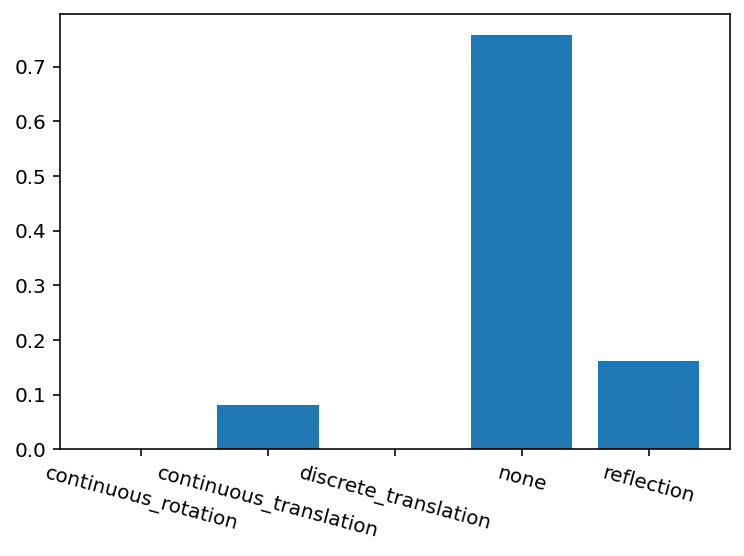

In [123]:
target = 'Income'    # Nombre de la variable que queremos predecir
nombre_carpeta = 'DB_customers' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos analizar al mismo tiempo varias bases de datos

n_fea = 13              # Número de features finales que el algoritmo escoge para hacer parejas y analizar con ellas la simetría

lim_sym = 0.85          # Límite de probabilidad para decidir que el algoritmo ha encontrado o no una simetría

limit_pairs = False      # Al generar parejas, estas vienen acompañadas de un 'score'. Si esto es True, cogmos solo la mitad de las con mayor 'score'

select_10k = True       # Keep only 10000 elements of the original potential DF (useful)

interact = True


# ------------------------------------------------------------------------------------------------------------------------#

i=0    
    
sym_feat_1 = []
sym_feat_2 = []
sym_feat_tags = []
sym_feat_probs = []
sym_feat_rmse = []
syms_tot = ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']
registro = pd.DataFrame(columns = syms_tot)
# Tiempo en el que empezamos a procesar
from time import time
start_time = time()


from fastai.vision.all import *
from time import time
from IPython.utils import io



muchos = False # Si es false, para muchos potenciales, mete cada combinación de variables en una carpeta separada, para que sea fácil ver si hay simetría ahí
               # Si es true, van todos a la misma carpeta


# ------------------- Folder PCA ------------------- #

folder = 'PCAs_DB_2'   # Carpeta donde se guardan las subcarpetas con las PCAs

dd = top_dir + '/' + folder
if not os.path.isdir(dd):
    print('Creating directory:\n',dd)
    os.mkdir(dd)

dir = os.path.join(top_dir,folder)

#------------------------------ Generar Potenciales ---------------------------#

potenciales = [df_e]
potenciales_tags = [nombre_carpeta]
tags = potenciales_tags
num_pot = len(potenciales)

# ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
# Solo hay un print que se ha eliminado del código original
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop = True
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

# ---------------- Definiciones previas e hiperparámetros ----------------- #

#Guardo los modelos para analizarlos luego
models = [] 
to_s = []

#Guardaremos los resultados de la PCA en un array 
PCA_s = []
PCA_s_tag = []

# Hyperparameters: 
bs_choices = [50000]       # Batch Size
shape='pipe'               # Shape of the neural network
layers_choices = [5]       # Number of layers of the net. Default:10 or 5 results with 5
neurons_choices = [100]    # Number of neurons per layer. Default:200 results with 200
epoch_choices = [150]      # Number of training epochs. Default:200 results with 60
lr_choices = [0.01]       # Max learning rate 
valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved



# ---------------------- Entrenar Red Y PCA -----------------------------------#

j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

for df in potenciales:
    
    df[target] = df[target]/np.max(df[target]) #Normalizar la columna objetivo es importante

    #------------------------------ Feature Importance  ---------------------------#

    if select_10k == True:
        if len(df[target]) <= 100*100:
            print('Too little data to keep 10k points and delete the rest')
        else:
            print('Keeping 10k points of the original DF')
            remove_n = len(df[target]) - 10000
            drop_indices = np.random.choice(df.index, remove_n, replace=False)
            df_temp = df.drop(drop_indices)
            df = df_temp.copy()


            
    if interact == True:
        bbb = df[target]
        df = df.drop(target,axis = 1)
        df = my_interactions_small(df, numo_int = 10, verbose = True)
        df[target] = bbb
        
    print('---Selecting Best Features---')
    best_pairs = n_best_rf_phi_k(df, target = target, n = n_fea, nf = 30, lim_corr = 0.85)

    best_n = [best_pairs['f1'][0]] + list(best_pairs['f2'].unique())

    print('Best Features: ',best_n)

    #small_df = df[best_n]
    #small_df[target] = df[target]


    cols = best_n
    a = cols

    verbose = 1



    df_org = df.copy()

    if limit_pairs == True:
        medi = best_pairs.score.median()
        num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])
    else:
        medi = 0
        num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])

    for f1,f2,lll in zip(best_pairs.f1,best_pairs.f2,range(len(best_pairs.f1))):
        if best_pairs.score[lll] >= medi:

            i+=1

            print(f1,f2)
            feas = [f1,f2]

            # Debemos marcar cada potencial para tener claro a qué tipo de simetria corresponde cada PCA
            PCA_s_tag.append(tags[j-1])

            df2 = df[feas + [target]].copy() 
            #df2 = df2[feas + [target]].copy()
            
            #Normlizamos las features y hacemos que vayan entre -1 y 1
            df2[f1] = 2*(df2[f1]/np.max(df2[f1]))-1
            df2[f2] = 2*(df2[f2]/np.max(df2[f2]))-1

            splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

            to = TabularPandas(df2,
                            procs=[Categorify,FillMissing, Normalize],
                            cont_names = feas,
                            y_names = target,
                            splits=splits)

            train_size = len(splits[0])
            valid_size = len(splits[1])

            # ----------------- Hyperparameters ------------------- #

            # Batch Size (a large one)
            bs=min(random.choice(bs_choices),train_size)  
            print('{} batch size for training.\n'.format(bs))

            # Neurons per layer
            neurons_per_layer = random.choice(neurons_choices)

            # Number of layers
            n_layers = random.choice(layers_choices)

            #Shape of the net: Pipe or funnel
            if shape == 'pipe':
                layers=[neurons_per_layer for i in range(n_layers)]

            if shape == 'funnel':
                n_eff = n_layers
                layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

            print('Training FCNN with layers: ',layers)

            #Number of epochs
            n_epoch=random.choice(epoch_choices)
            print('Training for {} epochs.'.format(n_epoch))

            # Maximum Learning Rate: (a good value can be found using learn.lr_find())
            lr_max=float(random.choice(lr_choices))
            print('Using lr_max = ',format(lr_max))

            # ----------------------------------------------------- #

            # --------------- Training the FCNN --------------------#

            # Load the data into a DataLoader
            dls = to.dataloaders(bs=bs)

            # Define a Tabular Learner
            learn = tabular_learner(dls, layers=layers
                                #,config=config
                                #,metrics=[mse],
                                #y_range = [min(df.bin),max(df.bin)],
                                #,cbs=ShowGraphCallback()
                                #,train_bn=False)
                                )

            # Train the net 
            with learn.no_logging():
                learn.fit_one_cycle(n_epoch=n_epoch
                                    ,lr_max=lr_max
                                    ,cbs=[SaveModelCallback(monitor=monitor)]
                                    )

                preds, targs = learn.get_preds()

            ff = (preds-targs)**2/len(targs)
            ff = sum(ff)
            RMSE = np.sqrt(ff)
            #print('RMSE:',float(RMSE))
            nrmsei = float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))

            # Guardamos modelos y tabular objects para el posterior analisis
            models.append(learn)
            to_s.append(to)

            # ------------------------------------------------------#


            # ------------------------- PCA ------------------------#

            test_df = df2.copy()
            dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

            # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
            # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
            with Hooks(learn.model.layers, lambda m,i,o: o) as h:
                preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

            targets=preds[2].numpy().flatten()

            # Cogemos la información de la penúltima capa
            # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
            # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
            act = h.stored[-2] 
            multi_dim=Tensor.cpu(act).numpy()
            standardized=StandardScaler().fit_transform(multi_dim)

            viz = PCA(2).fit_transform(np.nan_to_num(standardized))
            #plt.figure()
            #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')

            PCA_s.append(viz)

            # ------------------------------------------------------ #

            # ------------------ Saving the PCA's ------------------ #

            # ---- Dar formato a PCA para guardar como imagen con color

            viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
            viz.columns = ['x','y'] #Nombres de las columnas

            # Insertamos una columna con los colores de los puntos. El valor del potencial
            # objetivo (targets) es el color, y hay un color por cada punto 
            viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

            # ---- Personalizar mapa de color 

            n_classes=1000

            colors = 'rainbow'

            if colors == 'rainbow':
                my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                classes_in_rgb = my_cmap(range(n_classes))
            if colors == 'purple':
                my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

            # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
            #      acumuldos en un pixel

            n_pixels = 224

            binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

            #if we want the pixel intensity to reprensent the number of points at that location
            array = np.dot(binning_3d[0],classes_in_rgb)
            array = array/np.amax(array)

            # ---- Guardar la PCA

            #Directorio donde guardaremos las imagenes
            nami = '_'+str(feas[0])+'+'+str(feas[1])+'_'
            if muchos == False: 
                dir_sym = os.path.join(dir,tags[j-1],nami)
                img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'__PCA.png' 
            else:
                dir_sym = os.path.join(dir,tags[j-1])
                img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+nami+'__PCA.png' 

            if not os.path.isdir(dir_sym):
                print('Creating directory:\n',dir_sym)
                os.makedirs(dir_sym)


            # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
            output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
            plt.imsave(output_dir,array) # Guardar
            print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))


            # ------------------------ Symmetry Analyzer --------------------- #
            drr = pca_sym_finder(output_dir)
            brr = list(drr.iloc[np.where(drr.value > lim_sym)].symmetry)
            if len(brr) > 0:
                print('Found {} symmetry with features {} and {}, with prob. {}'.format(brr[0],f1,f2,float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4))))                
                sym_feat_1.append(f1)
                sym_feat_2.append(f2)
                sym_feat_tags.append(brr[0])
                sym_feat_probs.append(float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4)))
                sym_feat_rmse.append(nrmsei)




            # ------------------------ Time -------------------------#

            minutes_until_now = (time() - start_time)/60
            images_done = i
            minutes_per_image = minutes_until_now/(images_done)
            hours_left = minutes_per_image * (num_pot*num_2-images_done)/60
            print("\n{} PCA's made out of {}.\n".format(images_done,num_pot*num_2))
            print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
            print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
            print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot*num_2-images_done))
            print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot*num_2-images_done))




    j+=1


          # ------------------------------------------------------#'''

results = pd.DataFrame({'symmetry':sym_feat_tags, 'feature_1':sym_feat_1, 'feature_2':sym_feat_2, 'probability':sym_feat_probs, 'NRMSE':sym_feat_rmse})

vc = results.symmetry.value_counts()



for sym_sum in syms_tot:
    if not hasattr(vc,sym_sum):
        vc[sym_sum] = 0


nr = pd.DataFrame({'continuous_rotation':vc['continuous_rotation'], 
                   'continuous_translation':vc['continuous_translation'], 
                   'discrete_translation':vc['discrete_translation'], 
                   'none':vc['none'], 
                   'reflection':vc['reflection']}, index = [0])

registro = registro.append(nr, ignore_index=True)


plt.xticks(rotation = -15)
plt.bar(registro.columns,registro.sum()/registro.sum().sum())


In [124]:
results.iloc[np.where(results.symmetry != 'none')].sort_values('NRMSE', ascending = True)

,symmetry,feature_1,feature_2,probability,NRMSE
1,continuous_translation,1MntMeatProducts**2+1Z_Revenue**2,1MntWines**2+1Kidhome**2,0.8901,0.145748
8,reflection,1MntFishProducts+1MntMeatProducts,1AcceptedCmp4+1MntWines,0.9532,0.145954
19,continuous_translation,1AcceptedCmp4+1MntMeatProducts,1MntWines**2+1Kidhome**2,0.9937,0.154334
22,reflection,1AcceptedCmp4+1MntMeatProducts,1MntFishProducts+1NumStorePurchases,0.8865,0.154939
47,reflection,1MntWines+1MntFishProducts,1MntFishProducts+1MntMeatProducts,1.0000,0.157977
35,reflection,1AcceptedCmp4+1MntWines,1NumWebPurchases**2+1MntMeatProducts**2,0.9970,0.158880
3,reflection,1Teenhome+1MntMeatProducts,1MntWines**2+1Kidhome**2,0.9136,0.160059
17,reflection,1MntFishProducts+1NumStorePurchases,1MntWines**2+1Kidhome**2,0.9868,0.160905
23,continuous_translation,NumCatalogPurchases,1MntWines**2+1Kidhome**2,0.9978,0.164301
36,reflection,1MntWines+1MntFishProducts,1NumWebPurchases**2+1MntMeatProducts**2,0.9759,0.165593


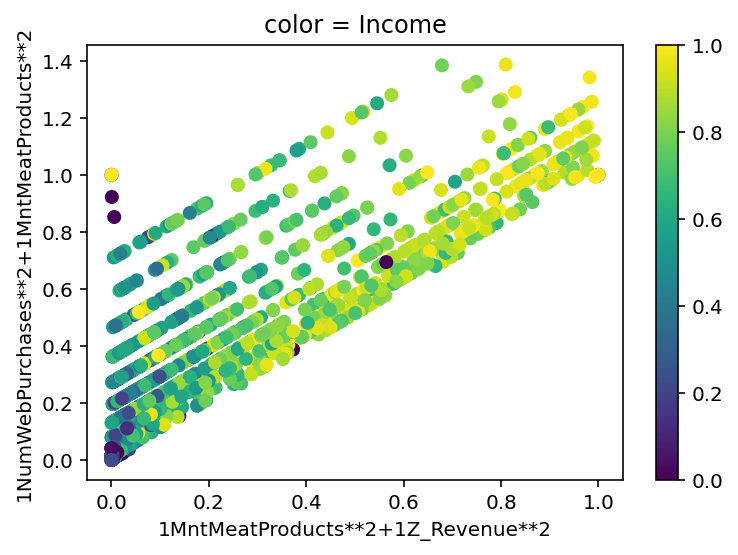

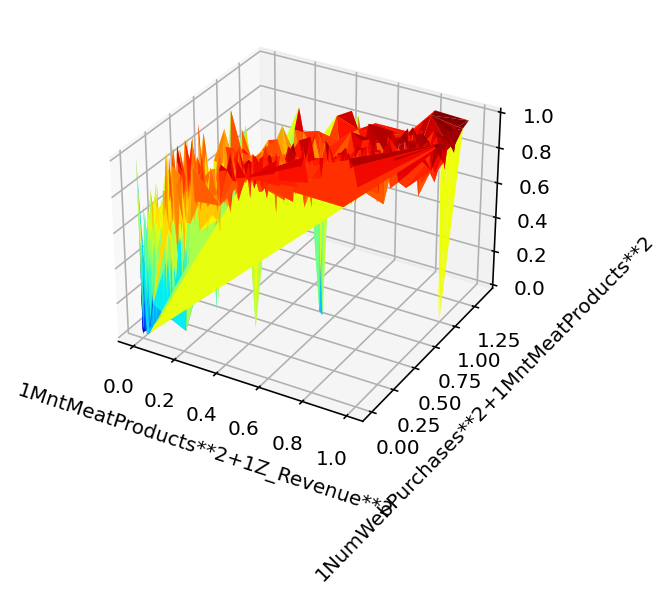

In [130]:
res_plot(df,results,54, logs = False)

# Bikes

In [82]:
creds = '{"username":"gabrielszalkowski","key":"36404a0345251322b628dc3c56bd25df"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

from kaggle import api
import opendatasets as od


od.download('https://www.kaggle.com/c/bike-sharing-demand')

path = Path(top_dir+'/bike-sharing-demand')
print(path.ls())

df_e = pd.read_csv(path.ls()[0])

categ = []
numer = []

# ----------------------------------- #

target = 'count'
quantiles = True
ignore_list = ['registered', 'casual']


# --------------------------------------#
for col in list(df_e.columns):
    if (col != target) and (col not in ignore_list):
        if type(df_e[col][0]) == str:
            categ.append(col)
        else:
            numer.append(col)

splits = RandomSplitter(valid_pct=0)(range_of(df_e))

to = TabularPandas(df_e,
                procs=[Categorify,FillMissing],
                cat_names = categ,
                cont_names = numer,
                y_names = target,
                splits=splits)


#equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
#equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

df_e = pd.DataFrame(to.xs)
df_e[target] = to.y
df_e = df_e.reset_index().drop('index', axis = 1)  

for col in df_e.columns:
    df_e[col] = np.nan_to_num(df_e[col])   
    if quantiles == True:
        n_attempted_bins =  len(df_e[col])
        binning = pd.qcut(df_e[col], q=n_attempted_bins, retbins=True, labels=False, duplicates='drop')
        df_e[col]=binning[0]/np.max(binning[0])
        df_e[col] = np.nan_to_num(df_e[col])

df_e.head()

Skipping, found downloaded files in "./bike-sharing-demand" (use force=True to force download)
[Path('/home/gabriel/Desktop/bike-sharing-demand/train.csv'), Path('/home/gabriel/Desktop/bike-sharing-demand/test.csv'), Path('/home/gabriel/Desktop/bike-sharing-demand/sampleSubmission.csv')]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,0.180524,0.2,0.0,0.0,0.0,0.557895,0.568966,0.625000,0.000000,0.312912
1,0.801837,0.6,0.0,1.0,0.0,0.726316,0.758621,0.803571,0.019608,0.012516
2,0.093799,0.0,0.0,1.0,0.6,0.178947,0.172414,1.000000,0.372549,0.000659
3,0.374460,1.0,0.0,0.0,0.6,0.347368,0.379310,0.898810,0.058824,0.071805
4,0.130822,0.2,0.0,1.0,0.6,0.452632,0.482759,0.976190,0.333333,0.004611


Keeping 10k points of the original DF
---- Small interactions ----
All 9 columns were squared
--> Number of variables smaller than num_int. Using all 9 columns
Total number of columns created by linear combination: 36
Total number of columns created by linear combination of squared variables: 36
   Regularising...

 Total number of features: 90
---Selecting Best Features---
Best Features:  ['1atemp**2+1datetime**2', '1humidity**2+1workingday**2', '1holiday**2+1humidity**2', '1weather+1humidity', '1datetime+1windspeed', 'datetime**2', '1weather**2+1temp**2', '1atemp+1temp', '1atemp+1holiday', '1datetime+1holiday', '1windspeed**2+1temp**2', '1datetime+1weather', '1datetime+1workingday']
1atemp**2+1datetime**2 1humidity**2+1workingday**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1humidity**2+1workingday**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1humidity**2+1workingday**2_/DB_bikes_11637933401__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1humidity**2+1workingday**2, with prob. 1.0

1 PCA's made out of 78.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
9.6 minutes estimated left for 77 images.



0.2 hours estimated left for 77 images.



1atemp**2+1datetime**2 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1holiday**2+1humidity**2_/DB_bikes_11637933407__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1holiday**2+1humidity**2, with prob. 1.0

2 PCA's made out of 78.

0.2 minutes elapsed for 2 images.
0.1 minutes average per image.
8.1 minutes estimated left for 76 images.



0.1 hours estimated left for 76 images.



1atemp**2+1datetime**2 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1weather+1humidity_/DB_bikes_11637933412__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1weather+1humidity, with prob. 1.0

3 PCA's made out of 78.

0.3 minutes elapsed for 3 images.
0.1 minutes average per image.
7.5 minutes estimated left for 75 images.



0.1 hours estimated left for 75 images.



1atemp+1temp 1humidity**2+1workingday**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1humidity**2+1workingday**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1humidity**2+1workingday**2_/DB_bikes_11637933417__PCA.png



Found reflection symmetry with features 1atemp+1temp and 1humidity**2+1workingday**2, with prob. 0.9998999834060669

4 PCA's made out of 78.

0.4 minutes elapsed for 4 images.
0.1 minutes average per image.
7.1 minutes estimated left for 74 images.



0.1 hours estimated left for 74 images.



1humidity**2+1workingday**2 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1datetime+1windspeed_/DB_bikes_11637933422__PCA.png



Found reflection symmetry with features 1humidity**2+1workingday**2 and 1datetime+1windspeed, with prob. 1.0

5 PCA's made out of 78.

0.5 minutes elapsed for 5 images.
0.1 minutes average per image.
6.9 minutes estimated left for 73 images.



0.1 hours estimated left for 73 images.



1datetime+1workingday 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1weather+1humidity_/DB_bikes_11637933427__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1weather+1humidity, with prob. 1.0

6 PCA's made out of 78.

0.6 minutes elapsed for 6 images.
0.1 minutes average per image.
6.7 minutes estimated left for 72 images.



0.1 hours estimated left for 72 images.



1datetime+1holiday 1humidity**2+1workingday**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1humidity**2+1workingday**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1humidity**2+1workingday**2_/DB_bikes_11637933433__PCA.png



Found reflection symmetry with features 1datetime+1holiday and 1humidity**2+1workingday**2, with prob. 1.0

7 PCA's made out of 78.

0.6 minutes elapsed for 7 images.
0.1 minutes average per image.
6.5 minutes estimated left for 71 images.



0.1 hours estimated left for 71 images.



1datetime+1workingday 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1holiday**2+1humidity**2_/DB_bikes_11637933438__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1holiday**2+1humidity**2, with prob. 0.9987999796867371

8 PCA's made out of 78.

0.7 minutes elapsed for 8 images.
0.1 minutes average per image.
6.4 minutes estimated left for 70 images.



0.1 hours estimated left for 70 images.



1humidity**2+1workingday**2 datetime**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+datetime**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+datetime**2_/DB_bikes_11637933443__PCA.png



Found reflection symmetry with features 1humidity**2+1workingday**2 and datetime**2, with prob. 1.0

9 PCA's made out of 78.

0.8 minutes elapsed for 9 images.
0.1 minutes average per image.
6.3 minutes estimated left for 69 images.



0.1 hours estimated left for 69 images.



1atemp+1temp 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1datetime+1windspeed_/DB_bikes_11637933448__PCA.png



Found reflection symmetry with features 1atemp+1temp and 1datetime+1windspeed, with prob. 1.0

10 PCA's made out of 78.

0.9 minutes elapsed for 10 images.
0.1 minutes average per image.
6.2 minutes estimated left for 68 images.



0.1 hours estimated left for 68 images.



1atemp+1holiday 1humidity**2+1workingday**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1humidity**2+1workingday**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1humidity**2+1workingday**2_/DB_bikes_11637933454__PCA.png



Found reflection symmetry with features 1atemp+1holiday and 1humidity**2+1workingday**2, with prob. 0.9998000264167786

11 PCA's made out of 78.

1.0 minutes elapsed for 11 images.
0.1 minutes average per image.
6.0 minutes estimated left for 67 images.



0.1 hours estimated left for 67 images.



1humidity**2+1workingday**2 1weather**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1weather**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1weather**2+1temp**2_/DB_bikes_11637933459__PCA.png




12 PCA's made out of 78.

1.1 minutes elapsed for 12 images.
0.1 minutes average per image.
6.0 minutes estimated left for 66 images.



0.1 hours estimated left for 66 images.



1atemp+1holiday 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1datetime+1windspeed_/DB_bikes_11637933464__PCA.png



Found reflection symmetry with features 1atemp+1holiday and 1datetime+1windspeed, with prob. 1.0

13 PCA's made out of 78.

1.2 minutes elapsed for 13 images.
0.1 minutes average per image.
5.9 minutes estimated left for 65 images.



0.1 hours estimated left for 65 images.



1atemp+1temp 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1holiday**2+1humidity**2_/DB_bikes_11637933470__PCA.png




14 PCA's made out of 78.

1.3 minutes elapsed for 14 images.
0.1 minutes average per image.
5.8 minutes estimated left for 64 images.



0.1 hours estimated left for 64 images.



1datetime+1workingday 1atemp+1temp
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1atemp+1temp_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1atemp+1temp_/DB_bikes_11637933475__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1atemp+1temp, with prob. 0.9998999834060669

15 PCA's made out of 78.

1.4 minutes elapsed for 15 images.
0.1 minutes average per image.
5.7 minutes estimated left for 63 images.



0.1 hours estimated left for 63 images.



1datetime+1windspeed 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1holiday**2+1humidity**2_/DB_bikes_11637933480__PCA.png



Found reflection symmetry with features 1datetime+1windspeed and 1holiday**2+1humidity**2, with prob. 1.0

16 PCA's made out of 78.

1.4 minutes elapsed for 16 images.
0.1 minutes average per image.
5.6 minutes estimated left for 62 images.



0.1 hours estimated left for 62 images.



1datetime+1holiday 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1weather+1humidity_/DB_bikes_11637933485__PCA.png



Found reflection symmetry with features 1datetime+1holiday and 1weather+1humidity, with prob. 1.0

17 PCA's made out of 78.

1.5 minutes elapsed for 17 images.
0.1 minutes average per image.
5.5 minutes estimated left for 61 images.



0.1 hours estimated left for 61 images.



1atemp+1holiday 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1weather+1humidity_/DB_bikes_11637933491__PCA.png



Found reflection symmetry with features 1atemp+1holiday and 1weather+1humidity, with prob. 0.9592000246047974

18 PCA's made out of 78.

1.6 minutes elapsed for 18 images.
0.1 minutes average per image.
5.4 minutes estimated left for 60 images.



0.1 hours estimated left for 60 images.



1atemp+1temp 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1weather+1humidity_/DB_bikes_11637933496__PCA.png



Found reflection symmetry with features 1atemp+1temp and 1weather+1humidity, with prob. 0.9955999851226807

19 PCA's made out of 78.

1.7 minutes elapsed for 19 images.
0.1 minutes average per image.
5.3 minutes estimated left for 59 images.



0.1 hours estimated left for 59 images.



1weather**2+1temp**2 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1datetime+1windspeed_/DB_bikes_11637933501__PCA.png



Found reflection symmetry with features 1weather**2+1temp**2 and 1datetime+1windspeed, with prob. 1.0

20 PCA's made out of 78.

1.8 minutes elapsed for 20 images.
0.1 minutes average per image.
5.2 minutes estimated left for 58 images.



0.1 hours estimated left for 58 images.



1weather**2+1temp**2 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1holiday**2+1humidity**2_/DB_bikes_11637933506__PCA.png




21 PCA's made out of 78.

1.9 minutes elapsed for 21 images.
0.1 minutes average per image.
5.1 minutes estimated left for 57 images.



0.1 hours estimated left for 57 images.



1datetime+1windspeed 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1weather+1humidity_/DB_bikes_11637933511__PCA.png



Found reflection symmetry with features 1datetime+1windspeed and 1weather+1humidity, with prob. 1.0

22 PCA's made out of 78.

2.0 minutes elapsed for 22 images.
0.1 minutes average per image.
5.0 minutes estimated left for 56 images.



0.1 hours estimated left for 56 images.



datetime**2 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1holiday**2+1humidity**2_/DB_bikes_11637933516__PCA.png



Found reflection symmetry with features datetime**2 and 1holiday**2+1humidity**2, with prob. 1.0

23 PCA's made out of 78.

2.0 minutes elapsed for 23 images.
0.1 minutes average per image.
4.9 minutes estimated left for 55 images.



0.1 hours estimated left for 55 images.



1datetime+1workingday 1weather**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1weather**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1weather**2+1temp**2_/DB_bikes_11637933522__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1weather**2+1temp**2, with prob. 1.0

24 PCA's made out of 78.

2.1 minutes elapsed for 24 images.
0.1 minutes average per image.
4.8 minutes estimated left for 54 images.



0.1 hours estimated left for 54 images.



1datetime+1workingday 1atemp+1holiday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1atemp+1holiday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1atemp+1holiday_/DB_bikes_11637933527__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1atemp+1holiday, with prob. 1.0

25 PCA's made out of 78.

2.2 minutes elapsed for 25 images.
0.1 minutes average per image.
4.7 minutes estimated left for 53 images.



0.1 hours estimated left for 53 images.



1atemp+1temp 1datetime+1holiday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1datetime+1holiday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1datetime+1holiday_/DB_bikes_11637933532__PCA.png



Found reflection symmetry with features 1atemp+1temp and 1datetime+1holiday, with prob. 1.0

26 PCA's made out of 78.

2.3 minutes elapsed for 26 images.
0.1 minutes average per image.
4.6 minutes estimated left for 52 images.



0.1 hours estimated left for 52 images.



1humidity**2+1workingday**2 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1windspeed**2+1temp**2_/DB_bikes_11637933538__PCA.png



Found reflection symmetry with features 1humidity**2+1workingday**2 and 1windspeed**2+1temp**2, with prob. 0.9998999834060669

27 PCA's made out of 78.

2.4 minutes elapsed for 27 images.
0.1 minutes average per image.
4.5 minutes estimated left for 51 images.



0.1 hours estimated left for 51 images.



1datetime+1workingday 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1windspeed**2+1temp**2_/DB_bikes_11637933543__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1windspeed**2+1temp**2, with prob. 1.0

28 PCA's made out of 78.

2.5 minutes elapsed for 28 images.
0.1 minutes average per image.
4.4 minutes estimated left for 50 images.



0.1 hours estimated left for 50 images.



datetime**2 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1weather+1humidity_/DB_bikes_11637933548__PCA.png



Found reflection symmetry with features datetime**2 and 1weather+1humidity, with prob. 1.0

29 PCA's made out of 78.

2.6 minutes elapsed for 29 images.
0.1 minutes average per image.
4.3 minutes estimated left for 49 images.



0.1 hours estimated left for 49 images.



1humidity**2+1workingday**2 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1datetime+1weather_/DB_bikes_11637933554__PCA.png



Found reflection symmetry with features 1humidity**2+1workingday**2 and 1datetime+1weather, with prob. 1.0

30 PCA's made out of 78.

2.7 minutes elapsed for 30 images.
0.1 minutes average per image.
4.3 minutes estimated left for 48 images.



0.1 hours estimated left for 48 images.



1atemp**2+1datetime**2 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1windspeed**2+1temp**2_/DB_bikes_11637933559__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1windspeed**2+1temp**2, with prob. 1.0

31 PCA's made out of 78.

2.7 minutes elapsed for 31 images.
0.1 minutes average per image.
4.2 minutes estimated left for 47 images.



0.1 hours estimated left for 47 images.



1datetime+1holiday 1weather**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1weather**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1weather**2+1temp**2_/DB_bikes_11637933564__PCA.png



Found reflection symmetry with features 1datetime+1holiday and 1weather**2+1temp**2, with prob. 1.0

32 PCA's made out of 78.

2.8 minutes elapsed for 32 images.
0.1 minutes average per image.
4.1 minutes estimated left for 46 images.



0.1 hours estimated left for 46 images.



1atemp**2+1datetime**2 1atemp+1holiday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1atemp+1holiday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1atemp+1holiday_/DB_bikes_11637933570__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1atemp+1holiday, with prob. 0.8999999761581421

33 PCA's made out of 78.

2.9 minutes elapsed for 33 images.
0.1 minutes average per image.
4.0 minutes estimated left for 45 images.



0.1 hours estimated left for 45 images.



1atemp**2+1datetime**2 1weather**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1weather**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1weather**2+1temp**2_/DB_bikes_11637933575__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1weather**2+1temp**2, with prob. 1.0

34 PCA's made out of 78.

3.0 minutes elapsed for 34 images.
0.1 minutes average per image.
3.9 minutes estimated left for 44 images.



0.1 hours estimated left for 44 images.



1atemp+1temp 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1datetime+1weather_/DB_bikes_11637933581__PCA.png



Found reflection symmetry with features 1atemp+1temp and 1datetime+1weather, with prob. 1.0

35 PCA's made out of 78.

3.1 minutes elapsed for 35 images.
0.1 minutes average per image.
3.8 minutes estimated left for 43 images.



0.1 hours estimated left for 43 images.



1atemp+1temp datetime**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+datetime**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+datetime**2_/DB_bikes_11637933586__PCA.png



Found reflection symmetry with features 1atemp+1temp and datetime**2, with prob. 1.0

36 PCA's made out of 78.

3.2 minutes elapsed for 36 images.
0.1 minutes average per image.
3.7 minutes estimated left for 42 images.



0.1 hours estimated left for 42 images.



1datetime+1holiday 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1windspeed**2+1temp**2_/DB_bikes_11637933591__PCA.png



Found reflection symmetry with features 1datetime+1holiday and 1windspeed**2+1temp**2, with prob. 1.0

37 PCA's made out of 78.

3.3 minutes elapsed for 37 images.
0.1 minutes average per image.
3.6 minutes estimated left for 41 images.



0.1 hours estimated left for 41 images.



1atemp+1holiday datetime**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+datetime**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+datetime**2_/DB_bikes_11637933597__PCA.png



Found reflection symmetry with features 1atemp+1holiday and datetime**2, with prob. 1.0

38 PCA's made out of 78.

3.4 minutes elapsed for 38 images.
0.1 minutes average per image.
3.6 minutes estimated left for 40 images.



0.1 hours estimated left for 40 images.



1holiday**2+1humidity**2 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1holiday**2+1humidity**2+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1holiday**2+1humidity**2+1windspeed**2+1temp**2_/DB_bikes_11637933602__PCA.png




39 PCA's made out of 78.

3.5 minutes elapsed for 39 images.
0.1 minutes average per image.
3.5 minutes estimated left for 39 images.



0.1 hours estimated left for 39 images.



1atemp**2+1datetime**2 1atemp+1temp
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1atemp+1temp_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1atemp+1temp_/DB_bikes_11637933607__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1atemp+1temp, with prob. 1.0

40 PCA's made out of 78.

3.6 minutes elapsed for 40 images.
0.1 minutes average per image.
3.4 minutes estimated left for 38 images.



0.1 hours estimated left for 38 images.



1atemp**2+1datetime**2 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1windspeed_/DB_bikes_11637933613__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1datetime+1windspeed, with prob. 1.0

41 PCA's made out of 78.

3.6 minutes elapsed for 41 images.
0.1 minutes average per image.
3.3 minutes estimated left for 37 images.



0.1 hours estimated left for 37 images.



1atemp+1holiday 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1datetime+1weather_/DB_bikes_11637933618__PCA.png



Found reflection symmetry with features 1atemp+1holiday and 1datetime+1weather, with prob. 1.0

42 PCA's made out of 78.

3.7 minutes elapsed for 42 images.
0.1 minutes average per image.
3.2 minutes estimated left for 36 images.



0.1 hours estimated left for 36 images.



1holiday**2+1humidity**2 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1holiday**2+1humidity**2+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1holiday**2+1humidity**2+1datetime+1weather_/DB_bikes_11637933623__PCA.png



Found reflection symmetry with features 1holiday**2+1humidity**2 and 1datetime+1weather, with prob. 1.0

43 PCA's made out of 78.

3.8 minutes elapsed for 43 images.
0.1 minutes average per image.
3.1 minutes estimated left for 35 images.



0.1 hours estimated left for 35 images.



1datetime+1windspeed 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1windspeed**2+1temp**2_/DB_bikes_11637933628__PCA.png



Found reflection symmetry with features 1datetime+1windspeed and 1windspeed**2+1temp**2, with prob. 0.9998999834060669

44 PCA's made out of 78.

3.9 minutes elapsed for 44 images.
0.1 minutes average per image.
3.0 minutes estimated left for 34 images.



0.1 hours estimated left for 34 images.



1weather+1humidity 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather+1humidity+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather+1humidity+1windspeed**2+1temp**2_/DB_bikes_11637933634__PCA.png



Found reflection symmetry with features 1weather+1humidity and 1windspeed**2+1temp**2, with prob. 1.0

45 PCA's made out of 78.

4.0 minutes elapsed for 45 images.
0.1 minutes average per image.
2.9 minutes estimated left for 33 images.



0.0 hours estimated left for 33 images.



datetime**2 1weather**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1weather**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1weather**2+1temp**2_/DB_bikes_11637933639__PCA.png



Found reflection symmetry with features datetime**2 and 1weather**2+1temp**2, with prob. 1.0

46 PCA's made out of 78.

4.1 minutes elapsed for 46 images.
0.1 minutes average per image.
2.8 minutes estimated left for 32 images.



0.0 hours estimated left for 32 images.



datetime**2 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1windspeed**2+1temp**2_/DB_bikes_11637933644__PCA.png



Found reflection symmetry with features datetime**2 and 1windspeed**2+1temp**2, with prob. 1.0

47 PCA's made out of 78.

4.2 minutes elapsed for 47 images.
0.1 minutes average per image.
2.8 minutes estimated left for 31 images.



0.0 hours estimated left for 31 images.



1weather**2+1temp**2 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1weather+1humidity_/DB_bikes_11637933650__PCA.png




48 PCA's made out of 78.

4.3 minutes elapsed for 48 images.
0.1 minutes average per image.
2.7 minutes estimated left for 30 images.



0.0 hours estimated left for 30 images.



1datetime+1workingday 1humidity**2+1workingday**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1humidity**2+1workingday**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1humidity**2+1workingday**2_/DB_bikes_11637933655__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1humidity**2+1workingday**2, with prob. 1.0

49 PCA's made out of 78.

4.3 minutes elapsed for 49 images.
0.1 minutes average per image.
2.6 minutes estimated left for 29 images.



0.0 hours estimated left for 29 images.



1atemp**2+1datetime**2 1datetime+1workingday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1workingday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1workingday_/DB_bikes_11637933660__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1datetime+1workingday, with prob. 0.9998999834060669

50 PCA's made out of 78.

4.4 minutes elapsed for 50 images.
0.1 minutes average per image.
2.5 minutes estimated left for 28 images.



0.0 hours estimated left for 28 images.



1datetime+1weather 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1weather+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1weather+1windspeed**2+1temp**2_/DB_bikes_11637933665__PCA.png



Found reflection symmetry with features 1datetime+1weather and 1windspeed**2+1temp**2, with prob. 1.0

51 PCA's made out of 78.

4.5 minutes elapsed for 51 images.
0.1 minutes average per image.
2.4 minutes estimated left for 27 images.



0.0 hours estimated left for 27 images.



1weather**2+1temp**2 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1datetime+1weather_/DB_bikes_11637933671__PCA.png



Found reflection symmetry with features 1weather**2+1temp**2 and 1datetime+1weather, with prob. 0.9995999932289124

52 PCA's made out of 78.

4.6 minutes elapsed for 52 images.
0.1 minutes average per image.
2.3 minutes estimated left for 26 images.



0.0 hours estimated left for 26 images.



1datetime+1workingday 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1datetime+1windspeed_/DB_bikes_11637933676__PCA.png



Found reflection symmetry with features 1datetime+1workingday and 1datetime+1windspeed, with prob. 1.0

53 PCA's made out of 78.

4.7 minutes elapsed for 53 images.
0.1 minutes average per image.
2.2 minutes estimated left for 25 images.



0.0 hours estimated left for 25 images.



1atemp**2+1datetime**2 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1weather_/DB_bikes_11637933682__PCA.png



Found reflection symmetry with features 1atemp**2+1datetime**2 and 1datetime+1weather, with prob. 1.0

54 PCA's made out of 78.

4.8 minutes elapsed for 54 images.
0.1 minutes average per image.
2.1 minutes estimated left for 24 images.



0.0 hours estimated left for 24 images.



1atemp**2+1datetime**2 1datetime+1holiday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1holiday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+1datetime+1holiday_/DB_bikes_11637933687__PCA.png




55 PCA's made out of 78.

4.9 minutes elapsed for 55 images.
0.1 minutes average per image.
2.0 minutes estimated left for 23 images.



0.0 hours estimated left for 23 images.



1datetime+1holiday 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1holiday**2+1humidity**2_/DB_bikes_11637933692__PCA.png



Found reflection symmetry with features 1datetime+1holiday and 1holiday**2+1humidity**2, with prob. 1.0

56 PCA's made out of 78.

5.0 minutes elapsed for 56 images.
0.1 minutes average per image.
2.0 minutes estimated left for 22 images.



0.0 hours estimated left for 22 images.



1atemp**2+1datetime**2 datetime**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+datetime**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp**2+1datetime**2+datetime**2_/DB_bikes_11637933698__PCA.png




57 PCA's made out of 78.

5.1 minutes elapsed for 57 images.
0.1 minutes average per image.
1.9 minutes estimated left for 21 images.



0.0 hours estimated left for 21 images.



1datetime+1holiday 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1datetime+1windspeed_/DB_bikes_11637933703__PCA.png



Found reflection symmetry with features 1datetime+1holiday and 1datetime+1windspeed, with prob. 0.864799976348877

58 PCA's made out of 78.

5.2 minutes elapsed for 58 images.
0.1 minutes average per image.
1.8 minutes estimated left for 20 images.



0.0 hours estimated left for 20 images.



1weather+1humidity 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather+1humidity+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather+1humidity+1datetime+1weather_/DB_bikes_11637933709__PCA.png



Found reflection symmetry with features 1weather+1humidity and 1datetime+1weather, with prob. 0.9998999834060669

59 PCA's made out of 78.

5.2 minutes elapsed for 59 images.
0.1 minutes average per image.
1.7 minutes estimated left for 19 images.



0.0 hours estimated left for 19 images.



1atemp+1holiday 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1windspeed**2+1temp**2_/DB_bikes_11637933714__PCA.png



Found reflection symmetry with features 1atemp+1holiday and 1windspeed**2+1temp**2, with prob. 0.996999979019165

60 PCA's made out of 78.

5.3 minutes elapsed for 60 images.
0.1 minutes average per image.
1.6 minutes estimated left for 18 images.



0.0 hours estimated left for 18 images.



1atemp+1holiday 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1holiday**2+1humidity**2_/DB_bikes_11637933719__PCA.png



Found none symmetry with features 1atemp+1holiday and 1holiday**2+1humidity**2, with prob. 0.9988999962806702

61 PCA's made out of 78.

5.4 minutes elapsed for 61 images.
0.1 minutes average per image.
1.5 minutes estimated left for 17 images.



0.0 hours estimated left for 17 images.



1datetime+1windspeed 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1windspeed+1datetime+1weather_/DB_bikes_11637933725__PCA.png



Found reflection symmetry with features 1datetime+1windspeed and 1datetime+1weather, with prob. 1.0

62 PCA's made out of 78.

5.5 minutes elapsed for 62 images.
0.1 minutes average per image.
1.4 minutes estimated left for 16 images.



0.0 hours estimated left for 16 images.



datetime**2 1datetime+1windspeed
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1datetime+1windspeed_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1datetime+1windspeed_/DB_bikes_11637933730__PCA.png



Found reflection symmetry with features datetime**2 and 1datetime+1windspeed, with prob. 0.994700014591217

63 PCA's made out of 78.

5.6 minutes elapsed for 63 images.
0.1 minutes average per image.
1.3 minutes estimated left for 15 images.



0.0 hours estimated left for 15 images.



1atemp+1holiday 1datetime+1holiday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1datetime+1holiday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1datetime+1holiday_/DB_bikes_11637933735__PCA.png



Found reflection symmetry with features 1atemp+1holiday and 1datetime+1holiday, with prob. 1.0

64 PCA's made out of 78.

5.7 minutes elapsed for 64 images.
0.1 minutes average per image.
1.2 minutes estimated left for 14 images.



0.0 hours estimated left for 14 images.



1atemp+1temp 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1windspeed**2+1temp**2_/DB_bikes_11637933740__PCA.png



Found continuous_translation symmetry with features 1atemp+1temp and 1windspeed**2+1temp**2, with prob. 0.9855999946594238

65 PCA's made out of 78.

5.8 minutes elapsed for 65 images.
0.1 minutes average per image.
1.2 minutes estimated left for 13 images.



0.0 hours estimated left for 13 images.



1atemp+1holiday 1weather**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1weather**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1holiday+1weather**2+1temp**2_/DB_bikes_11637933746__PCA.png



Found none symmetry with features 1atemp+1holiday and 1weather**2+1temp**2, with prob. 0.9908000230789185

66 PCA's made out of 78.

5.9 minutes elapsed for 66 images.
0.1 minutes average per image.
1.1 minutes estimated left for 12 images.



0.0 hours estimated left for 12 images.



1weather**2+1temp**2 1windspeed**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1windspeed**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1weather**2+1temp**2+1windspeed**2+1temp**2_/DB_bikes_11637933751__PCA.png



Found none symmetry with features 1weather**2+1temp**2 and 1windspeed**2+1temp**2, with prob. 0.9987000226974487

67 PCA's made out of 78.

5.9 minutes elapsed for 67 images.
0.1 minutes average per image.
1.0 minutes estimated left for 11 images.



0.0 hours estimated left for 11 images.



1datetime+1workingday 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1datetime+1weather_/DB_bikes_11637933756__PCA.png



Found none symmetry with features 1datetime+1workingday and 1datetime+1weather, with prob. 0.9994999766349792

68 PCA's made out of 78.

6.0 minutes elapsed for 68 images.
0.1 minutes average per image.
0.9 minutes estimated left for 10 images.



0.0 hours estimated left for 10 images.



1humidity**2+1workingday**2 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1weather+1humidity_/DB_bikes_11637933761__PCA.png



Found none symmetry with features 1humidity**2+1workingday**2 and 1weather+1humidity, with prob. 0.9998999834060669

69 PCA's made out of 78.

6.1 minutes elapsed for 69 images.
0.1 minutes average per image.
0.8 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



1datetime+1holiday 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+1datetime+1weather_/DB_bikes_11637933766__PCA.png




70 PCA's made out of 78.

6.2 minutes elapsed for 70 images.
0.1 minutes average per image.
0.7 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



1datetime+1workingday datetime**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+datetime**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+datetime**2_/DB_bikes_11637933772__PCA.png



Found none symmetry with features 1datetime+1workingday and datetime**2, with prob. 0.9991999864578247

71 PCA's made out of 78.

6.3 minutes elapsed for 71 images.
0.1 minutes average per image.
0.6 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



1holiday**2+1humidity**2 1weather+1humidity
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1holiday**2+1humidity**2+1weather+1humidity_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1holiday**2+1humidity**2+1weather+1humidity_/DB_bikes_11637933777__PCA.png



Found continuous_translation symmetry with features 1holiday**2+1humidity**2 and 1weather+1humidity, with prob. 0.9251000285148621

72 PCA's made out of 78.

6.4 minutes elapsed for 72 images.
0.1 minutes average per image.
0.5 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



1atemp+1temp 1atemp+1holiday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1atemp+1holiday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1atemp+1holiday_/DB_bikes_11637933782__PCA.png




73 PCA's made out of 78.

6.5 minutes elapsed for 73 images.
0.1 minutes average per image.
0.4 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



1datetime+1workingday 1datetime+1holiday
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1datetime+1holiday_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1workingday+1datetime+1holiday_/DB_bikes_11637933788__PCA.png



Found none symmetry with features 1datetime+1workingday and 1datetime+1holiday, with prob. 0.9968000054359436

74 PCA's made out of 78.

6.6 minutes elapsed for 74 images.
0.1 minutes average per image.
0.4 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



datetime**2 1datetime+1weather
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1datetime+1weather_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_datetime**2+1datetime+1weather_/DB_bikes_11637933793__PCA.png



Found none symmetry with features datetime**2 and 1datetime+1weather, with prob. 0.9995999932289124

75 PCA's made out of 78.

6.6 minutes elapsed for 75 images.
0.1 minutes average per image.
0.3 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



1atemp+1temp 1weather**2+1temp**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1weather**2+1temp**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1atemp+1temp+1weather**2+1temp**2_/DB_bikes_11637933798__PCA.png



Found continuous_translation symmetry with features 1atemp+1temp and 1weather**2+1temp**2, with prob. 0.9995999932289124

76 PCA's made out of 78.

6.7 minutes elapsed for 76 images.
0.1 minutes average per image.
0.2 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



1datetime+1holiday datetime**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+datetime**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1datetime+1holiday+datetime**2_/DB_bikes_11637933803__PCA.png



Found continuous_translation symmetry with features 1datetime+1holiday and datetime**2, with prob. 0.9993000030517578

77 PCA's made out of 78.

6.8 minutes elapsed for 77 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



1humidity**2+1workingday**2 1holiday**2+1humidity**2
8000 batch size for training.

Training FCNN with layers:  [100, 100, 100, 100, 100]
Training for 150 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1holiday**2+1humidity**2_

PCA saved to:
/home/gabriel/Desktop/PCAs_DB_2/DB_bikes/_1humidity**2+1workingday**2+1holiday**2+1humidity**2_/DB_bikes_11637933809__PCA.png



Found none symmetry with features 1humidity**2+1workingday**2 and 1holiday**2+1humidity**2, with prob. 0.9980999827384949

78 PCA's made out of 78.

6.9 minutes elapsed for 78 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.





<BarContainer object of 5 artists>

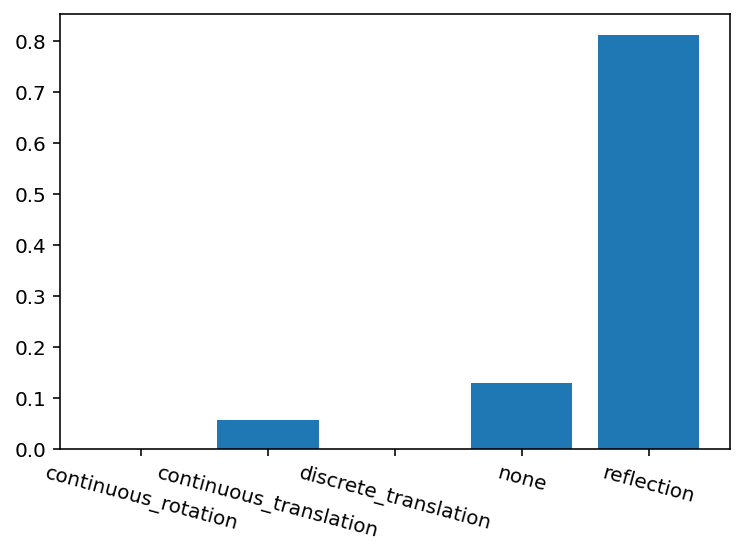

In [178]:
target = 'count'    # Nombre de la variable que queremos predecir
nombre_carpeta = 'DB_bikes' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos analizar al mismo tiempo varias bases de datos

n_fea = 13              # Número de features finales que el algoritmo escoge para hacer parejas y analizar con ellas la simetría

lim_sym = 0.85          # Límite de probabilidad para decidir que el algoritmo ha encontrado o no una simetría

limit_pairs = False      # Al generar parejas, estas vienen acompañadas de un 'score'. Si esto es True, cogmos solo la mitad de las con mayor 'score'

select_10k = True       # Keep only 10000 elements of the original potential DF (useful)

interact = 'small'       # 'big', 'small', 'FW', False


# ------------------------------------------------------------------------------------------------------------------------#

i=0    
    
sym_feat_1 = []
sym_feat_2 = []
sym_feat_tags = []
sym_feat_probs = []
sym_feat_rmse = []
syms_tot = ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']
registro = pd.DataFrame(columns = syms_tot)
# Tiempo en el que empezamos a procesar
from time import time
start_time = time()


from fastai.vision.all import *
from time import time
from IPython.utils import io



muchos = False # Si es false, para muchos potenciales, mete cada combinación de variables en una carpeta separada, para que sea fácil ver si hay simetría ahí
               # Si es true, van todos a la misma carpeta


# ------------------- Folder PCA ------------------- #

folder = 'PCAs_DB_2'   # Carpeta donde se guardan las subcarpetas con las PCAs

dd = top_dir + '/' + folder
if not os.path.isdir(dd):
    print('Creating directory:\n',dd)
    os.mkdir(dd)

dir = os.path.join(top_dir,folder)

#------------------------------ Generar Potenciales ---------------------------#

potenciales = [df_e]
potenciales_tags = [nombre_carpeta]
tags = potenciales_tags
num_pot = len(potenciales)

# ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
# Solo hay un print que se ha eliminado del código original
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop = True
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

# ---------------- Definiciones previas e hiperparámetros ----------------- #

#Guardo los modelos para analizarlos luego
models = [] 
to_s = []

#Guardaremos los resultados de la PCA en un array 
PCA_s = []
PCA_s_tag = []

# Hyperparameters: 
bs_choices = [50000]       # Batch Size
shape='pipe'               # Shape of the neural network
layers_choices = [5]       # Number of layers of the net. Default:10 or 5 results with 5
neurons_choices = [100]    # Number of neurons per layer. Default:200 results with 200
epoch_choices = [150]      # Number of training epochs. Default:200 results with 60
lr_choices = [0.01]       # Max learning rate 
valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved



# ---------------------- Entrenar Red Y PCA -----------------------------------#

j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

for df in potenciales:
    
    df[target] = df[target]/np.max(df[target]) #Normalizar la columna objetivo es importante

    #------------------------------ Feature Importance  ---------------------------#

    if select_10k == True:
        if len(df[target]) <= 100*100:
            print('Too little data to keep 10k points and delete the rest')
        else:
            print('Keeping 10k points of the original DF')
            remove_n = len(df[target]) - 10000
            drop_indices = np.random.choice(df.index, remove_n, replace=False)
            df_temp = df.drop(drop_indices)
            df = df_temp.copy()


            
    if interact == 'big':
        print('---- Big interactions ----')
        bbb = df[target]
        df = df.drop(target,axis = 1)
        df = my_interactions(df, numo_int = 10, verbose = True)
        df[target] = bbb
        
    elif interact == 'small':
        print('---- Small interactions ----')
        bbb = df[target]
        df = df.drop(target,axis = 1)
        df = my_interactions_small(df, numo_int = 10, verbose = True)
        df[target] = bbb
        
    elif interact == 'FW':
        print('---- Interactions by featurewiz ----')
        with io.capture_output() as captured2: output = featurewiz(df, target, corr_limit=0.10,
                                                        verbose=0, sep=',', header=0, test_data='',
                                                        category_encoders='',feature_engg='interactions')   
        df = output[1].copy()
        
    elif interact == False:
        print('No interactions')


    #df = regularize_df(df)
    
    print('---Selecting Best Features---')
    best_pairs = n_best_rf_phi_k(df, target = target, n = n_fea, nf = 30, lim_corr = 0.85)

    best_n = [best_pairs['f1'][0]] + list(best_pairs['f2'].unique())

    print('Best Features: ',best_n)

    #small_df = df[best_n]
    #small_df[target] = df[target]


    cols = best_n
    a = cols

    verbose = 1



    df_org = df.copy()

    if limit_pairs == True:
        medi = best_pairs.score.median()
        num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])
    else:
        medi = 0
        num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])

    for f1,f2,lll in zip(best_pairs.f1,best_pairs.f2,range(len(best_pairs.f1))):
        if best_pairs.score[lll] >= medi:

            i+=1

            print(f1,f2)
            feas = [f1,f2]

            # Debemos marcar cada potencial para tener claro a qué tipo de simetria corresponde cada PCA
            PCA_s_tag.append(tags[j-1])

            df2 = df[feas + [target]].copy() 
            #df2 = df2[feas + [target]].copy()
            
            #Normlizamos las features y hacemos que vayan entre -1 y 1
            df2[f1] = 2*(df2[f1]/np.max(df2[f1]))-1
            df2[f2] = 2*(df2[f2]/np.max(df2[f2]))-1

            splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

            to = TabularPandas(df2,
                            procs=[Categorify,FillMissing, Normalize],
                            cont_names = feas,
                            y_names = target,
                            splits=splits)

            train_size = len(splits[0])
            valid_size = len(splits[1])

            # ----------------- Hyperparameters ------------------- #

            # Batch Size (a large one)
            bs=min(random.choice(bs_choices),train_size)  
            print('{} batch size for training.\n'.format(bs))

            # Neurons per layer
            neurons_per_layer = random.choice(neurons_choices)

            # Number of layers
            n_layers = random.choice(layers_choices)

            #Shape of the net: Pipe or funnel
            if shape == 'pipe':
                layers=[neurons_per_layer for i in range(n_layers)]

            if shape == 'funnel':
                n_eff = n_layers
                layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

            print('Training FCNN with layers: ',layers)

            #Number of epochs
            n_epoch=random.choice(epoch_choices)
            print('Training for {} epochs.'.format(n_epoch))

            # Maximum Learning Rate: (a good value can be found using learn.lr_find())
            lr_max=float(random.choice(lr_choices))
            print('Using lr_max = ',format(lr_max))

            # ----------------------------------------------------- #

            # --------------- Training the FCNN --------------------#

            # Load the data into a DataLoader
            dls = to.dataloaders(bs=bs)

            # Define a Tabular Learner
            learn = tabular_learner(dls, layers=layers
                                #,config=config
                                #,metrics=[mse],
                                #y_range = [min(df.bin),max(df.bin)],
                                #,cbs=ShowGraphCallback()
                                #,train_bn=False)
                                )

            # Train the net 
            with learn.no_logging():
                learn.fit_one_cycle(n_epoch=n_epoch
                                    ,lr_max=lr_max
                                    ,cbs=[SaveModelCallback(monitor=monitor)]
                                    )

                preds, targs = learn.get_preds()

            ff = (preds-targs)**2/len(targs)
            ff = sum(ff)
            RMSE = np.sqrt(ff)
            #print('RMSE:',float(RMSE))
            nrmsei = float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))

            # Guardamos modelos y tabular objects para el posterior analisis
            models.append(learn)
            to_s.append(to)

            # ------------------------------------------------------#


            # ------------------------- PCA ------------------------#

            test_df = df2.copy()
            dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

            # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
            # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
            with Hooks(learn.model.layers, lambda m,i,o: o) as h:
                preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

            targets=preds[2].numpy().flatten()

            # Cogemos la información de la penúltima capa
            # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
            # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
            act = h.stored[-2] 
            multi_dim=Tensor.cpu(act).numpy()
            standardized=StandardScaler().fit_transform(multi_dim)

            viz = PCA(2).fit_transform(np.nan_to_num(standardized))
            #plt.figure()
            #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')

            PCA_s.append(viz)

            # ------------------------------------------------------ #

            # ------------------ Saving the PCA's ------------------ #

            # ---- Dar formato a PCA para guardar como imagen con color

            viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
            viz.columns = ['x','y'] #Nombres de las columnas

            # Insertamos una columna con los colores de los puntos. El valor del potencial
            # objetivo (targets) es el color, y hay un color por cada punto 
            viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

            # ---- Personalizar mapa de color 

            n_classes=1000

            colors = 'rainbow'

            if colors == 'rainbow':
                my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                classes_in_rgb = my_cmap(range(n_classes))
            if colors == 'purple':
                my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

            # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
            #      acumuldos en un pixel

            n_pixels = 224

            binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

            #if we want the pixel intensity to reprensent the number of points at that location
            array = np.dot(binning_3d[0],classes_in_rgb)
            array = array/np.amax(array)

            # ---- Guardar la PCA

            #Directorio donde guardaremos las imagenes
            nami = '_'+str(feas[0])+'+'+str(feas[1])+'_'
            if muchos == False: 
                dir_sym = os.path.join(dir,tags[j-1],nami)
                img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'__PCA.png' 
            else:
                dir_sym = os.path.join(dir,tags[j-1])
                img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+nami+'__PCA.png' 

            if not os.path.isdir(dir_sym):
                print('Creating directory:\n',dir_sym)
                os.makedirs(dir_sym)


            # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
            output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
            plt.imsave(output_dir,array) # Guardar
            print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))


            # ------------------------ Symmetry Analyzer --------------------- #
            drr = pca_sym_finder(output_dir)
            brr = list(drr.iloc[np.where(drr.value > lim_sym)].symmetry)
            if len(brr) > 0:
                print('Found {} symmetry with features {} and {}, with prob. {}'.format(brr[0],f1,f2,float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4))))                
                sym_feat_1.append(f1)
                sym_feat_2.append(f2)
                sym_feat_tags.append(brr[0])
                sym_feat_probs.append(float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4)))
                sym_feat_rmse.append(nrmsei)




            # ------------------------ Time -------------------------#

            minutes_until_now = (time() - start_time)/60
            images_done = i
            minutes_per_image = minutes_until_now/(images_done)
            hours_left = minutes_per_image * (num_pot*num_2-images_done)/60
            print("\n{} PCA's made out of {}.\n".format(images_done,num_pot*num_2))
            print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
            print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
            print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot*num_2-images_done))
            print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot*num_2-images_done))




    j+=1


          # ------------------------------------------------------#'''

results = pd.DataFrame({'symmetry':sym_feat_tags, 'feature_1':sym_feat_1, 'feature_2':sym_feat_2, 'probability':sym_feat_probs, 'NRMSE':sym_feat_rmse})

vc = results.symmetry.value_counts()



for sym_sum in syms_tot:
    if not hasattr(vc,sym_sum):
        vc[sym_sum] = 0


nr = pd.DataFrame({'continuous_rotation':vc['continuous_rotation'], 
                   'continuous_translation':vc['continuous_translation'], 
                   'discrete_translation':vc['discrete_translation'], 
                   'none':vc['none'], 
                   'reflection':vc['reflection']}, index = [0])

registro = registro.append(nr, ignore_index=True)


plt.xticks(rotation = -15)
plt.bar(registro.columns,registro.sum()/registro.sum().sum())


In [179]:
results.iloc[np.where(results.symmetry != 'none')].sort_values('NRMSE', ascending = True)

,symmetry,feature_1,feature_2,probability,NRMSE
0,reflection,1atemp**2+1datetime**2,1humidity**2+1workingday**2,1.0000,0.182953
2,reflection,1atemp**2+1datetime**2,1weather+1humidity,1.0000,0.183972
8,reflection,1humidity**2+1workingday**2,datetime**2,1.0000,0.185690
1,reflection,1atemp**2+1datetime**2,1holiday**2+1humidity**2,1.0000,0.185785
31,reflection,1atemp+1temp,1datetime+1weather,1.0000,0.186561
48,reflection,1atemp**2+1datetime**2,1datetime+1weather,1.0000,0.187947
7,reflection,1datetime+1workingday,1holiday**2+1humidity**2,0.9988,0.188553
44,reflection,1atemp**2+1datetime**2,1datetime+1workingday,0.9999,0.188613
56,reflection,1atemp+1holiday,1datetime+1holiday,1.0000,0.189337
12,reflection,1datetime+1workingday,1atemp+1temp,0.9999,0.189438


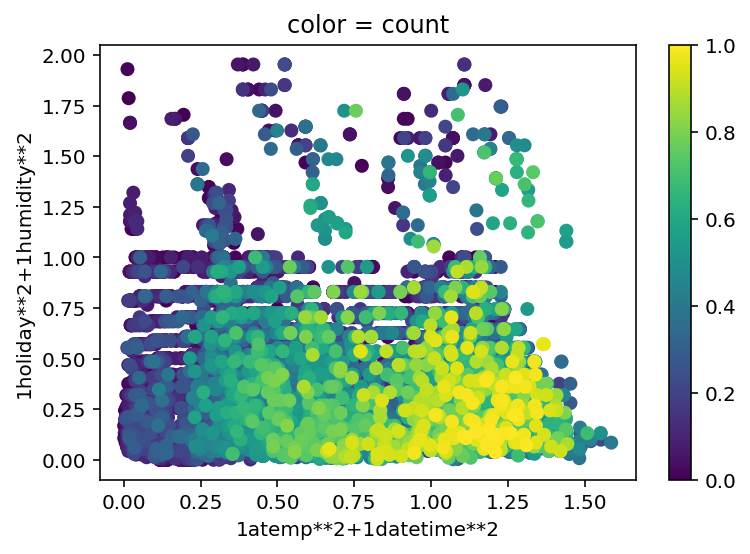

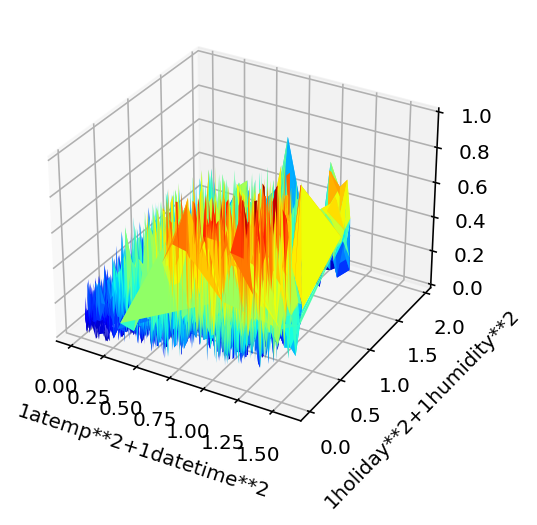

In [186]:
res_plot(df.sort_values(target), results, num = 1, logs = False)

Text(0, 0.5, 'atemp')

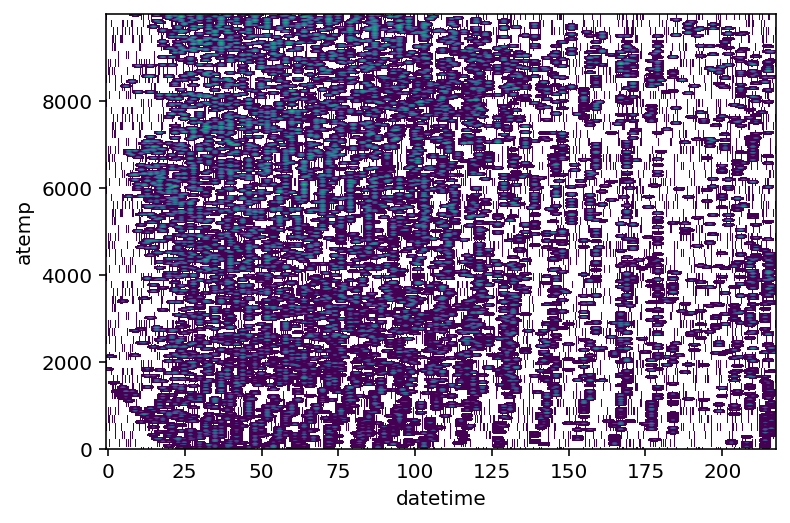

In [190]:
axs = plt.subplot2grid((1,1), (0, 0))
img_array= np.array(pd.pivot_table(df.sort_values(target),index='1atemp**2+1datetime**2',columns='1weather+1humidity',values='count', fill_value=0))
axs.imshow(img_array, aspect = 'auto', norm = LogNorm(), interpolation =  'gaussian', origin = 'lower')
plt.xlabel('datetime')
plt.ylabel('atemp')

In [193]:
img_array.reshape([10000,-1])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# e+e- --> Z --> e+e-

In [54]:
gve = 0.5
gae = 0.5

folder_0 = 'cross_section'
name = 'ze+e-_gve_' + str(gve) + '_gae_' + str(gae) + '.csv'



df_e = pd.read_csv(os.path.join(folder_0,name))

categ = []
numer = []

# ----------------------------------- #

target = 'diff_sigma'
quantiles = True
range_cols = True   # Si quantiles == True, las columnas distintas de la target las escala entre -1 y 1.
ignore_list = ['Pz1','Pz2', 'E2', 's', 'cos_theta']


# --------------------------------------#
for col in list(df_e.columns):
    if (col != target) and (col not in ignore_list):
        if type(df_e[col][0]) == str:
            categ.append(col)
        else:
            numer.append(col)

splits = RandomSplitter(valid_pct=0)(range_of(df_e))

to = TabularPandas(df_e,
                procs=[Categorify,FillMissing],
                cat_names = categ,
                cont_names = numer,
                y_names = target,
                splits=splits)


#equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
#equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

df_e = pd.DataFrame(to.xs)
df_e[target] = to.y
df_e = df_e.reset_index().drop('index', axis = 1)  

for col in df_e.columns:
    df_e[col] = np.nan_to_num(df_e[col])   
    if quantiles == True:
        n_attempted_bins =  len(df_e[col])
        binning = pd.qcut(df_e[col], q=n_attempted_bins, retbins=True, labels=False, duplicates='drop')
        df_e[col]=binning[0]/np.max(binning[0])
        df_e[col] = np.nan_to_num(df_e[col])
        if (range_cols == True) and (col != target): 
            df_e[col] = df_e[col]*2 - 1



df_e.head()

,Px1,Py1,E1,Px2,Py2,diff_sigma
0,0.464739,-0.871115,-1.0,-0.464739,0.871115,0.634665
1,0.718509,-0.752990,-1.0,-0.718509,0.752990,0.573303
2,0.081963,0.792672,-1.0,-0.081963,-0.792672,0.789812
3,-0.052602,-0.416457,-1.0,0.052602,0.416457,0.952758
4,0.530301,0.582823,-1.0,-0.530301,-0.582823,0.802272


No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
40000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings/_Py2+Px1_/Ze+e-_couplings_11638359777__PCA.png



Found continuous_translation symmetry with features Py2 and Px1, with prob. 1.0

1 PCA's made out of 2.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px2']
Py1 Px2
40000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings/_Py1+Px2_/Ze+e-_couplings_21638359786__PCA.png



Found continuous_translation symmetry with features Py1 and Px2, with prob. 1.0

2 PCA's made out of 2.

0.3 minutes elapsed for 2 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.



Index(['continuous_rotation', 'continuous_translation', 'discrete_translation',
       'none', 'reflection'],
      dtype='object')
continuous_rotation       0.0
continuous_translation    1.0
discrete_translation      0.0
none                      0.0
reflection                0.0
dtype: float64


<BarContainer object of 5 artists>

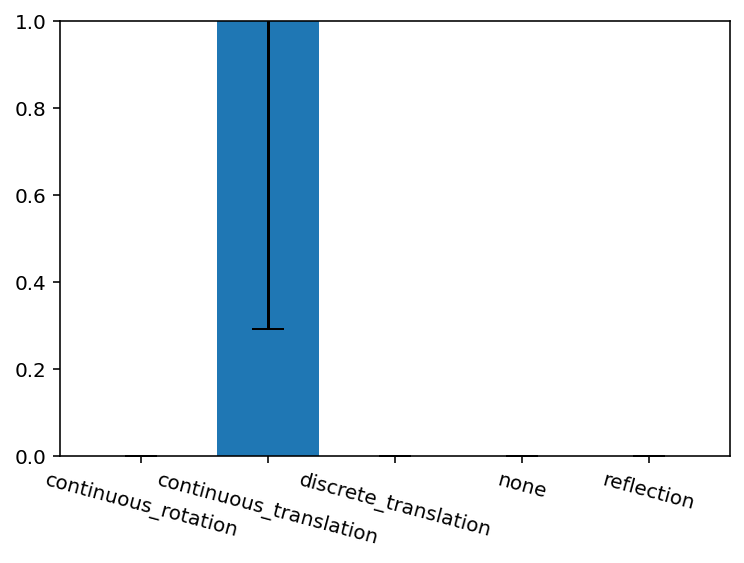

In [59]:
target = 'diff_sigma'    # Nombre de la variable que queremos predecir
nombre_carpeta = 'Ze+e-_couplings' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos analizar al mismo tiempo varias bases de datos

n_fea = 13              # Número de features finales que el algoritmo escoge para hacer parejas y analizar con ellas la simetría

lim_sym = 0.7          # Límite de probabilidad para decidir que el algoritmo ha encontrado o no una simetría

limit_pairs = False      # Al generar parejas, estas vienen acompañadas de un 'score'. Si esto es True, cogmos solo la mitad de las con mayor 'score'

select_10k = False       # Keep only 10000 elements of the original potential DF (useful)

interact = False        # 'big', 'small', 'FW', False

rep_todo = 2

# ------------------------------------------------------------------------------------------------------------------------#

i=0    
    
sym_feat_1 = []
sym_feat_2 = []
sym_feat_tags = []
sym_feat_probs = []
sym_feat_rmse = []
syms_tot = ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']
registro = pd.DataFrame(columns = syms_tot)
# Tiempo en el que empezamos a procesar
from time import time
start_time = time()


from fastai.vision.all import *
from time import time
from IPython.utils import io



muchos = False # Si es false, para muchos potenciales, mete cada combinación de variables en una carpeta separada, para que sea fácil ver si hay simetría ahí
               # Si es true, van todos a la misma carpeta


# ------------------- Folder PCA ------------------- #

folder = 'Ze+e-_2'   # Carpeta donde se guardan las subcarpetas con las PCAs

dd = top_dir + '/' + folder
if not os.path.isdir(dd):
    print('Creating directory:\n',dd)
    os.mkdir(dd)

dir = os.path.join(top_dir,folder)

#------------------------------ Generar Potenciales ---------------------------#

potenciales = [df_e]
potenciales_tags = [nombre_carpeta for k in range(rep_todo)]
tags = potenciales_tags
num_pot = len(potenciales)

# ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
# Solo hay un print que se ha eliminado del código original
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop = True
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

# ---------------- Definiciones previas e hiperparámetros ----------------- #

#Guardo los modelos para analizarlos luego
models = [] 
to_s = []

#Guardaremos los resultados de la PCA en un array 
PCA_s = []
PCA_s_tag = []

# Hyperparameters: 
bs_choices = [50000]       # Batch Size
shape='pipe'               # Shape of the neural network
layers_choices = [5]       # Number of layers of the net. Default:10 or 5 results with 5
neurons_choices = [200]    # Number of neurons per layer. Default:200 results with 200
epoch_choices = [50]      # Number of training epochs. Default:200 results with 100
lr_choices = [0.01]       # Max learning rate 
valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved



# ---------------------- Entrenar Red Y PCA -----------------------------------#

j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

for rtd in range(rep_todo):
    for df in potenciales:

        df[target] = df[target]/np.max(df[target]) #Normalizar la columna objetivo es importante

        #------------------------------ Feature Importance  ---------------------------#

        if select_10k == True:
            if len(df[target]) <= 100*100:
                print('Too little data to keep 10k points and delete the rest')
            else:
                print('Keeping 10k points of the original DF')
                remove_n = len(df[target]) - 10000
                drop_indices = np.random.choice(df.index, remove_n, replace=False)
                df_temp = df.drop(drop_indices)
                df = df_temp.copy()



        if interact == 'big':
            print('---- Big interactions ----')
            bbb = df[target]
            df = df.drop(target,axis = 1)
            df = my_interactions(df, numo_int = 10, verbose = True)
            df[target] = bbb

        elif interact == 'small':
            print('---- Small interactions ----')
            bbb = df[target]
            df = df.drop(target,axis = 1)
            df = my_interactions_small(df, numo_int = 10, verbose = True)
            df[target] = bbb

        elif interact == 'FW':
            print('---- Interactions by featurewiz ----')
            with io.capture_output() as captured2: output = featurewiz(df, target, corr_limit=0.10,
                                                            verbose=0, sep=',', header=0, test_data='',
                                                            category_encoders='',feature_engg='interactions')   
            df = output[1].copy()

        elif interact == False:
            print('No interactions')


        #df = regularize_df(df)

        print('---Selecting Best Features---')
        best_pairs = n_best_rf_phi_k(df, target = target, n = n_fea, nf = 30, lim_corr = 0.85)

        best_n = [best_pairs['f1'][0]] + list(best_pairs['f2'].unique())

        print('Best Features: ',best_n)

        #small_df = df[best_n]
        #small_df[target] = df[target]


        cols = best_n
        a = cols

        verbose = 1



        df_org = df.copy()

        if limit_pairs == True:
            medi = best_pairs.score.median()
            num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])
        else:
            medi = 0
            num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])

        for f1,f2,lll in zip(best_pairs.f1,best_pairs.f2,range(len(best_pairs.f1))):
            if best_pairs.score[lll] >= medi:

                i+=1

                print(f1,f2)
                feas = [f1,f2]

                # Debemos marcar cada potencial para tener claro a qué tipo de simetria corresponde cada PCA
                PCA_s_tag.append(tags[j-1])

                df2 = df[feas + [target]].copy() 
                #df2 = df2[feas + [target]].copy()

                #Normlizamos las features y hacemos que vayan entre -1 y 1
                df2[f1] = 2*(df2[f1]/np.max(df2[f1]))-1
                df2[f2] = 2*(df2[f2]/np.max(df2[f2]))-1

                splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

                to = TabularPandas(df2,
                                procs=[Categorify,FillMissing, Normalize],
                                cont_names = feas,
                                y_names = target,
                                splits=splits)

                train_size = len(splits[0])
                valid_size = len(splits[1])

                # ----------------- Hyperparameters ------------------- #

                # Batch Size (a large one)
                bs=min(random.choice(bs_choices),train_size)  
                print('{} batch size for training.\n'.format(bs))

                # Neurons per layer
                neurons_per_layer = random.choice(neurons_choices)

                # Number of layers
                n_layers = random.choice(layers_choices)

                #Shape of the net: Pipe or funnel
                if shape == 'pipe':
                    layers=[neurons_per_layer for i in range(n_layers)]

                if shape == 'funnel':
                    n_eff = n_layers
                    layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

                print('Training FCNN with layers: ',layers)

                #Number of epochs
                n_epoch=random.choice(epoch_choices)
                print('Training for {} epochs.'.format(n_epoch))

                # Maximum Learning Rate: (a good value can be found using learn.lr_find())
                lr_max=float(random.choice(lr_choices))
                print('Using lr_max = ',format(lr_max))

                # ----------------------------------------------------- #

                # --------------- Training the FCNN --------------------#

                # Load the data into a DataLoader
                dls = to.dataloaders(bs=bs)

                # Define a Tabular Learner
                learn = tabular_learner(dls, layers=layers
                                    #,config=config
                                    #,metrics=[mse],
                                    #y_range = [min(df.bin),max(df.bin)],
                                    #,cbs=ShowGraphCallback()
                                    #,train_bn=False)
                                    )

                # Train the net 
                with learn.no_logging():
                    learn.fit_one_cycle(n_epoch=n_epoch
                                        ,lr_max=lr_max
                                        ,cbs=[SaveModelCallback(monitor=monitor)]
                                        )

                    preds, targs = learn.get_preds()

                ff = (preds-targs)**2/len(targs)
                ff = sum(ff)
                RMSE = np.sqrt(ff)
                #print('RMSE:',float(RMSE))
                nrmsei = float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))

                # Guardamos modelos y tabular objects para el posterior analisis
                models.append(learn)
                to_s.append(to)

                # ------------------------------------------------------#


                # ------------------------- PCA ------------------------#

                test_df = df2.copy()
                dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

                # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
                # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
                with Hooks(learn.model.layers, lambda m,i,o: o) as h:
                    preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

                targets=preds[2].numpy().flatten()

                # Cogemos la información de la penúltima capa
                # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
                # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
                act = h.stored[-2] 
                multi_dim=Tensor.cpu(act).numpy()
                standardized=StandardScaler().fit_transform(multi_dim)

                viz = PCA(2).fit_transform(np.nan_to_num(standardized))
                #plt.figure()
                #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')

                PCA_s.append(viz)

                # ------------------------------------------------------ #

                # ------------------ Saving the PCA's ------------------ #

                # ---- Dar formato a PCA para guardar como imagen con color

                viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
                viz.columns = ['x','y'] #Nombres de las columnas

                # Insertamos una columna con los colores de los puntos. El valor del potencial
                # objetivo (targets) es el color, y hay un color por cada punto 
                viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

                # ---- Personalizar mapa de color 

                n_classes=1000

                colors = 'rainbow'

                if colors == 'rainbow':
                    my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                    classes_in_rgb = my_cmap(range(n_classes))
                if colors == 'purple':
                    my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                    classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

                # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
                #      acumuldos en un pixel

                n_pixels = 224

                binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

                #if we want the pixel intensity to reprensent the number of points at that location
                array = np.dot(binning_3d[0],classes_in_rgb)
                array = array/np.amax(array)

                # ---- Guardar la PCA

                #Directorio donde guardaremos las imagenes
                nami = '_'+str(feas[0])+'+'+str(feas[1])+'_'
                if muchos == False: 
                    dir_sym = os.path.join(dir,tags[j-1],nami)
                    img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'__PCA.png' 
                else:
                    dir_sym = os.path.join(dir,tags[j-1])
                    img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+nami+'__PCA.png' 

                if not os.path.isdir(dir_sym):
                    print('Creating directory:\n',dir_sym)
                    os.makedirs(dir_sym)


                # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
                output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
                plt.imsave(output_dir,array) # Guardar
                print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))


                # ------------------------ Symmetry Analyzer --------------------- #
                drr = pca_sym_finder(output_dir)
                brr = list(drr.iloc[np.where(drr.value > lim_sym)].symmetry)
                if len(brr) > 0:
                    print('Found {} symmetry with features {} and {}, with prob. {}'.format(brr[0],f1,f2,float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4))))                
                    sym_feat_1.append(f1)
                    sym_feat_2.append(f2)
                    sym_feat_tags.append(brr[0])
                    sym_feat_probs.append(float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4)))
                    sym_feat_rmse.append(nrmsei)




                # ------------------------ Time -------------------------#

                minutes_until_now = (time() - start_time)/60
                images_done = i
                minutes_per_image = minutes_until_now/(images_done)
                hours_left = minutes_per_image * (num_pot*rep_todo*num_2-images_done)/60
                print("\n{} PCA's made out of {}.\n".format(images_done,num_pot*num_2*rep_todo))
                print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
                print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
                print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot*num_2*rep_todo-images_done))
                print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot*num_2*rep_todo-images_done))




    j+=1


          # ------------------------------------------------------#'''

results = pd.DataFrame({'symmetry':sym_feat_tags, 'feature_1':sym_feat_1, 'feature_2':sym_feat_2, 'probability':sym_feat_probs, 'NRMSE':sym_feat_rmse})

vc = results.symmetry.value_counts()



for sym_sum in syms_tot:
    if not hasattr(vc,sym_sum):
        vc[sym_sum] = 0


nr = pd.DataFrame({'continuous_rotation':vc['continuous_rotation'], 
                   'continuous_translation':vc['continuous_translation'], 
                   'discrete_translation':vc['discrete_translation'], 
                   'none':vc['none'], 
                   'reflection':vc['reflection']}, index = [0])

registro = registro.append(nr, ignore_index=True)


plt.xticks(rotation = -15)
plt.ylim([0,1])
print(registro.columns)
print(registro.sum()/registro.sum().sum())
plt.bar(registro.columns,registro.sum()/registro.sum().sum(), yerr = np.sqrt(registro.sum())/registro.sum().sum(), capsize = 8)


Index(['continuous_rotation', 'continuous_translation', 'discrete_translation',
       'none', 'reflection'],
      dtype='object')
continuous_rotation       0.664773
continuous_translation    0.013636
discrete_translation      0.082955
none                      0.001136
reflection                0.237500
dtype: float64


<BarContainer object of 5 artists>

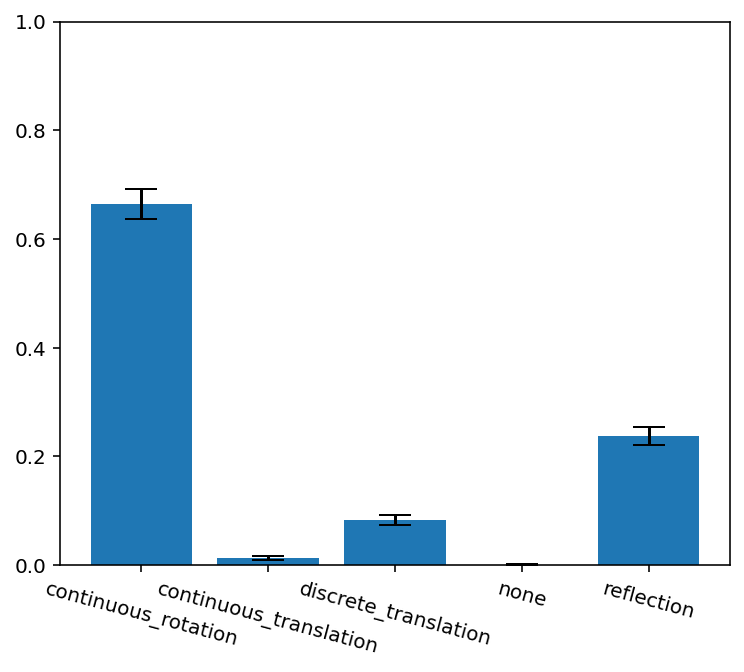

In [144]:
plt.figure(figsize = [6,5])
plt.xticks(rotation = -15)
plt.ylim([0,1])
print(registro.columns)
print(registro.sum()/registro.sum().sum())
plt.bar(registro.columns,registro.sum()/registro.sum().sum(), yerr = np.sqrt(registro.sum())/registro.sum().sum(), capsize = 8)


In [116]:
results.iloc[np.where(results.symmetry != 'none')].sort_values('NRMSE', ascending = True)

,symmetry,feature_1,feature_2,probability,NRMSE
3,continuous_rotation,Py1,Px1,0.9990,0.008687
4,reflection,Py2,Px2,1.0000,0.009051
7,reflection,Px2,Py2,0.9996,0.009065
8,continuous_rotation,Py2,Px2,0.9990,0.009343
6,discrete_translation,Py2,Px2,0.9974,0.009497
0,reflection,Py1,Px1,0.9448,0.010189
1,reflection,Py1,Px2,1.0000,0.010540
5,reflection,Py1,Px1,1.0000,0.011479
2,discrete_translation,Py1,Px1,0.9985,0.011968


In [61]:
i = 0

0


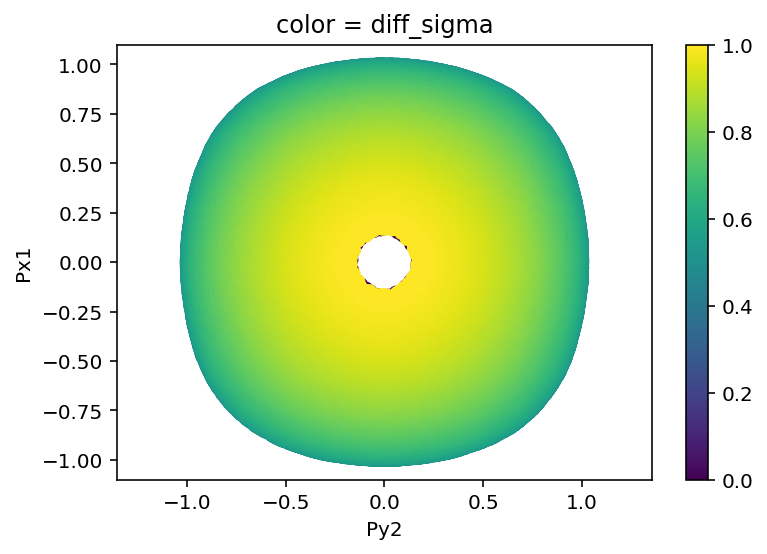

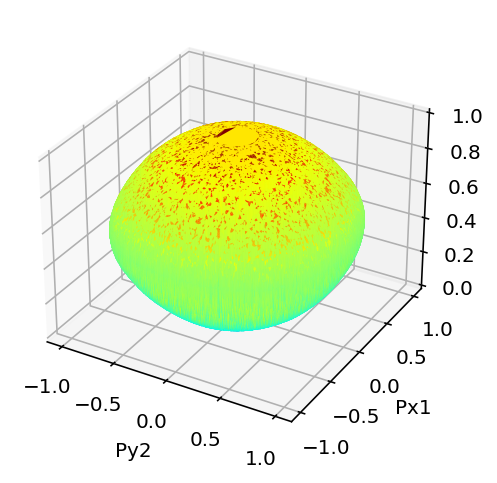

In [62]:
print(i)
res_plot(df.sort_values(target), results, num = i, logs = False)
i+=1

# Different Couplings

In [14]:
# ----------------------------------- #

target = 'diff_sigma'  # Nombre de la variable que queremos predecir
quantiles = True
range_cols = True   # Si quantiles == True, las columnas distintas de la target las escala entre -1 y 1.
ignore_list = ['Pz1','Pz2', 'E2', 's', 'cos_theta']

nombre_carpeta = 'Ze+e-_couplings_diff' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos analizar al mismo tiempo varias bases de datos

n_fea = 13              # Número de features finales que el algoritmo escoge para hacer parejas y analizar con ellas la simetría

lim_sym = 0.7          # Límite de probabilidad para decidir que el algoritmo ha encontrado o no una simetría

limit_pairs = False      # Al generar parejas, estas vienen acompañadas de un 'score'. Si esto es True, cogmos solo la mitad de las con mayor 'score'

select_10k = True       # Keep only 10000 elements of the original potential DF (useful)

interact = False        # 'big', 'small', 'FW', False

rep_todo = 1


gve_l = [1,0.9,0.85,0.8,0.7,0.5,0.3,0.2,0.15,0.1,0]
gae_l = [0,0.1,0.15,0.2,0.3,0.5,0.7,0.8,0.85,0.9,1]

# --------------------------------------#

i=0 
from time import time
start_time = time()

syms_tot = ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']
registro = pd.DataFrame(columns = syms_tot)
registros = []

num_g = len(gve_l)

for  gve,gae in zip(gve_l,gae_l):
    
    print('**** gv_e = {} **** ga_e = {} ****'.format(gve,gae))

    folder_0 = 'cross_section'
    name = 'ze+e-_gve_' + str(gve) + '_gae_' + str(gae) + '.csv'


    df_e = pd.read_csv(os.path.join(folder_0,name))

    categ = []
    numer = []


    for col in list(df_e.columns):
        if (col != target) and (col not in ignore_list):
            if type(df_e[col][0]) == str:
                categ.append(col)
            else:
                numer.append(col)

    splits = RandomSplitter(valid_pct=0)(range_of(df_e))

    to = TabularPandas(df_e,
                    procs=[Categorify,FillMissing],
                    cat_names = categ,
                    cont_names = numer,
                    y_names = target,
                    splits=splits)


    #equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
    #equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

    df_e = pd.DataFrame(to.xs)
    df_e[target] = to.y
    df_e = df_e.reset_index().drop('index', axis = 1)  

    for col in df_e.columns:
        df_e[col] = np.nan_to_num(df_e[col])   
        if quantiles == True:
            n_attempted_bins =  len(df_e[col])
            binning = pd.qcut(df_e[col], q=n_attempted_bins, retbins=True, labels=False, duplicates='drop')
            df_e[col]=binning[0]/np.max(binning[0])
            df_e[col] = np.nan_to_num(df_e[col])
            if (range_cols == True) and (col != target): 
                df_e[col] = df_e[col]*2 - 1





    # ------------------------------------------------------------------------------------------------------------------------#

   

    sym_feat_1 = []
    sym_feat_2 = []
    sym_feat_tags = []
    sym_feat_probs = []
    sym_feat_rmse = []

    # Tiempo en el que empezamos a procesar



    from fastai.vision.all import *
    from time import time
    from IPython.utils import io



    muchos = False # Si es false, para muchos potenciales, mete cada combinación de variables en una carpeta separada, para que sea fácil ver si hay simetría ahí
                   # Si es true, van todos a la misma carpeta


    # ------------------- Folder PCA ------------------- #

    folder = 'Ze+e-_2'   # Carpeta donde se guardan las subcarpetas con las PCAs

    dd = top_dir + '/' + folder
    if not os.path.isdir(dd):
        print('Creating directory:\n',dd)
        os.mkdir(dd)

    dir = os.path.join(top_dir,folder)

    #------------------------------ Generar Potenciales ---------------------------#

    potenciales = [df_e]
    potenciales_tags = [nombre_carpeta for k in range(rep_todo)]
    tags = potenciales_tags
    num_pot = len(potenciales)

    # ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
    # Solo hay un print que se ha eliminado del código original
    class SaveModelCallback(TrackerCallback):
        "A `TrackerCallback` that saves the model's best during training and loads it at the end."
        _only_train_loop = True
        def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                     with_opt=False, reset_on_fit=True):
            super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
            assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
            # keep track of file path for loggers
            self.last_saved_path = None
            store_attr('fname,every_epoch,at_end,with_opt')

        def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

        def after_epoch(self):
            "Compare the value monitored to its best score and save if best."
            if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
            else: #every improvement
                super().after_epoch()
                if self.new_best:
                    #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                    self._save(f'{self.fname}')

        def after_fit(self, **kwargs):
            "Load the best model."
            if self.at_end: self._save(f'{self.fname}')
            elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

    # ---------------- Definiciones previas e hiperparámetros ----------------- #

    #Guardo los modelos para analizarlos luego
    models = [] 
    to_s = []

    #Guardaremos los resultados de la PCA en un array 
    PCA_s = []
    PCA_s_tag = []

    # Hyperparameters: 
    bs_choices = [50000]       # Batch Size
    shape='pipe'               # Shape of the neural network
    layers_choices = [5]       # Number of layers of the net. Default:10 or 5 results with 5
    neurons_choices = [200]    # Number of neurons per layer. Default:200 results with 200
    epoch_choices = [50]      # Number of training epochs. Default:200 results with 100
    lr_choices = [0.01]       # Max learning rate 
    valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
    monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved



    # ---------------------- Entrenar Red Y PCA -----------------------------------#

    j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

    for rtd in range(rep_todo):
        for df in potenciales:

            df[target] = df[target]/np.max(df[target]) #Normalizar la columna objetivo es importante

            #------------------------------ Feature Importance  ---------------------------#

            if select_10k == True:
                if len(df[target]) <= 100*100:
                    print('Too little data to keep 10k points and delete the rest')
                else:
                    print('Keeping 10k points of the original DF')
                    remove_n = len(df[target]) - 10000
                    drop_indices = np.random.choice(df.index, remove_n, replace=False)
                    df_temp = df.drop(drop_indices)
                    df = df_temp.copy()



            if interact == 'big':
                print('---- Big interactions ----')
                bbb = df[target]
                df = df.drop(target,axis = 1)
                df = my_interactions(df, numo_int = 10, verbose = True)
                df[target] = bbb

            elif interact == 'small':
                print('---- Small interactions ----')
                bbb = df[target]
                df = df.drop(target,axis = 1)
                df = my_interactions_small(df, numo_int = 10, verbose = True)
                df[target] = bbb

            elif interact == 'FW':
                print('---- Interactions by featurewiz ----')
                with io.capture_output() as captured2: output = featurewiz(df, target, corr_limit=0.10,
                                                                verbose=0, sep=',', header=0, test_data='',
                                                                category_encoders='',feature_engg='interactions')   
                df = output[1].copy()

            elif interact == False:
                print('No interactions')


            #df = regularize_df(df)

            print('---Selecting Best Features---')
            best_pairs = n_best_rf_phi_k(df, target = target, n = n_fea, nf = 30, lim_corr = 0.85)

            best_n = [best_pairs['f1'][0]] + list(best_pairs['f2'].unique())

            print('Best Features: ',best_n)

            #small_df = df[best_n]
            #small_df[target] = df[target]


            cols = best_n
            a = cols

            verbose = 1



            df_org = df.copy()

            if limit_pairs == True:
                medi = best_pairs.score.median()
                num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])
            else:
                medi = 0
                num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])

            for f1,f2,lll in zip(best_pairs.f1,best_pairs.f2,range(len(best_pairs.f1))):
                if best_pairs.score[lll] >= medi:

                    i+=1

                    print(f1,f2)
                    feas = [f1,f2]

                    # Debemos marcar cada potencial para tener claro a qué tipo de simetria corresponde cada PCA
                    PCA_s_tag.append(tags[j-1])

                    df2 = df[feas + [target]].copy() 
                    #df2 = df2[feas + [target]].copy()

                    #Normlizamos las features y hacemos que vayan entre -1 y 1
                    df2[f1] = 2*(df2[f1]/np.max(df2[f1]))-1
                    df2[f2] = 2*(df2[f2]/np.max(df2[f2]))-1

                    splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

                    to = TabularPandas(df2,
                                    procs=[Categorify,FillMissing, Normalize],
                                    cont_names = feas,
                                    y_names = target,
                                    splits=splits)

                    train_size = len(splits[0])
                    valid_size = len(splits[1])

                    # ----------------- Hyperparameters ------------------- #

                    # Batch Size (a large one)
                    bs=min(random.choice(bs_choices),train_size)  
                    print('{} batch size for training.\n'.format(bs))

                    # Neurons per layer
                    neurons_per_layer = random.choice(neurons_choices)

                    # Number of layers
                    n_layers = random.choice(layers_choices)

                    #Shape of the net: Pipe or funnel
                    if shape == 'pipe':
                        layers=[neurons_per_layer for i in range(n_layers)]

                    if shape == 'funnel':
                        n_eff = n_layers
                        layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

                    print('Training FCNN with layers: ',layers)

                    #Number of epochs
                    n_epoch=random.choice(epoch_choices)
                    print('Training for {} epochs.'.format(n_epoch))

                    # Maximum Learning Rate: (a good value can be found using learn.lr_find())
                    lr_max=float(random.choice(lr_choices))
                    print('Using lr_max = ',format(lr_max))

                    # ----------------------------------------------------- #

                    # --------------- Training the FCNN --------------------#

                    # Load the data into a DataLoader
                    dls = to.dataloaders(bs=bs)

                    # Define a Tabular Learner
                    learn = tabular_learner(dls, layers=layers
                                        #,config=config
                                        #,metrics=[mse],
                                        #y_range = [min(df.bin),max(df.bin)],
                                        #,cbs=ShowGraphCallback()
                                        #,train_bn=False)
                                        )

                    # Train the net 
                    with learn.no_logging():
                        learn.fit_one_cycle(n_epoch=n_epoch
                                            ,lr_max=lr_max
                                            ,cbs=[SaveModelCallback(monitor=monitor)]
                                            )

                        preds, targs = learn.get_preds()

                    ff = (preds-targs)**2/len(targs)
                    ff = sum(ff)
                    RMSE = np.sqrt(ff)
                    #print('RMSE:',float(RMSE))
                    nrmsei = float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))

                    # Guardamos modelos y tabular objects para el posterior analisis
                    models.append(learn)
                    to_s.append(to)

                    # ------------------------------------------------------#


                    # ------------------------- PCA ------------------------#

                    test_df = df2.copy()
                    dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

                    # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
                    # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
                    with Hooks(learn.model.layers, lambda m,i,o: o) as h:
                        preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

                    targets=preds[2].numpy().flatten()

                    # Cogemos la información de la penúltima capa
                    # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
                    # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
                    act = h.stored[-2] 
                    multi_dim=Tensor.cpu(act).numpy()
                    standardized=StandardScaler().fit_transform(multi_dim)

                    viz = PCA(2).fit_transform(np.nan_to_num(standardized))
                    #plt.figure()
                    #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')

                    PCA_s.append(viz)

                    # ------------------------------------------------------ #

                    # ------------------ Saving the PCA's ------------------ #

                    # ---- Dar formato a PCA para guardar como imagen con color

                    viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
                    viz.columns = ['x','y'] #Nombres de las columnas

                    # Insertamos una columna con los colores de los puntos. El valor del potencial
                    # objetivo (targets) es el color, y hay un color por cada punto 
                    viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

                    # ---- Personalizar mapa de color 

                    n_classes=1000

                    colors = 'rainbow'

                    if colors == 'rainbow':
                        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                        classes_in_rgb = my_cmap(range(n_classes))
                    if colors == 'purple':
                        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                        classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

                    # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
                    #      acumuldos en un pixel

                    n_pixels = 224

                    binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

                    #if we want the pixel intensity to reprensent the number of points at that location
                    array = np.dot(binning_3d[0],classes_in_rgb)
                    array = array/np.amax(array)

                    # ---- Guardar la PCA

                    #Directorio donde guardaremos las imagenes
                    nami = '_'+'ze+e-_gve_' + str(gve) + '_gae_' + str(gae) +'_'
                    if muchos == False: 
                        dir_sym = os.path.join(dir,tags[j-1],nami)
                        img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'__PCA.png' 
                    else:
                        dir_sym = os.path.join(dir,tags[j-1])
                        img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+nami+'__PCA.png' 

                    if not os.path.isdir(dir_sym):
                        print('Creating directory:\n',dir_sym)
                        os.makedirs(dir_sym)


                    # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
                    output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
                    plt.imsave(output_dir,array) # Guardar
                    print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))


                    # ------------------------ Symmetry Analyzer --------------------- #
                    drr = pca_sym_finder(output_dir)
                    brr = list(drr.iloc[np.where(drr.value > lim_sym)].symmetry)
                    if len(brr) > 0:
                        print('Found {} symmetry with features {} and {}, with prob. {}'.format(brr[0],f1,f2,float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4))))                
                        sym_feat_1.append(f1)
                        sym_feat_2.append(f2)
                        sym_feat_tags.append(brr[0])
                        sym_feat_probs.append(float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4)))
                        sym_feat_rmse.append(nrmsei)




                    # ------------------------ Time -------------------------#

                    minutes_until_now = (time() - start_time)/60
                    images_done = i
                    minutes_per_image = minutes_until_now/(images_done)
                    hours_left = minutes_per_image * (num_pot*rep_todo*num_2*num_g-images_done)/60
                    print("\n{} PCA's made out of {}.\n".format(images_done,num_pot*num_2*rep_todo*num_g))
                    print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
                    print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
                    print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot*num_2*rep_todo*num_g-images_done))
                    print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot*num_2*rep_todo*num_g-images_done))




        j+=1


              # ------------------------------------------------------#'''

    results = pd.DataFrame({'symmetry':sym_feat_tags, 'feature_1':sym_feat_1, 'feature_2':sym_feat_2, 'probability':sym_feat_probs, 'NRMSE':sym_feat_rmse})

    vc = results.symmetry.value_counts()



    for sym_sum in syms_tot:
        if not hasattr(vc,sym_sum):
            vc[sym_sum] = 0


    nr = pd.DataFrame({'continuous_rotation':vc['continuous_rotation'], 
                       'continuous_translation':vc['continuous_translation'], 
                       'discrete_translation':vc['discrete_translation'], 
                       'none':vc['none'], 
                       'reflection':vc['reflection']}, index = [0])

    registro = registro.append(nr, ignore_index=True)
    

    registros.append(nr)


'''    plt.xticks(rotation = -15)
    plt.ylim([0,1])
    print(registro.columns)
    print(registro.sum()/registro.sum().sum())
    plt.bar(registro.columns,registro.sum()/registro.sum().sum(), yerr = np.sqrt(registro.sum())/registro.sum().sum(), capsize = 8)
'''

print(0)

**** gv_e = 1 **** ga_e = 0 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px2']
Py1 Px2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_1_gae_0_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_1_gae_0_/Ze+e-_couplings_diff_11638440890__PCA.png



Found continuous_rotation symmetry with features Py1 and Px2, with prob. 1.0

1 PCA's made out of 11.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
0.8 minutes estimated left for 10 images.



0.0 hours estimated left for 10 images.



**** gv_e = 0.9 **** ga_e = 0.1 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px2']
Py1 Px2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.9_gae_0.1_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.9_gae_0.1_/Ze+e-_couplings_diff_11638440895__PCA.png



Found continuous_rotation symmetry with features Py1 and Px2, with prob. 0.9900000095367432

2 PCA's made out of 11.

0.2 minutes elapsed for 2 images.
0.1 minutes average per image.
0.7 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



**** gv_e = 0.85 **** ga_e = 0.15 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Px1', 'Py2']
Px1 Py2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.85_gae_0.15_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.85_gae_0.15_/Ze+e-_couplings_diff_11638440899__PCA.png



Found continuous_rotation symmetry with features Px1 and Py2, with prob. 0.7117999792098999

3 PCA's made out of 11.

0.2 minutes elapsed for 3 images.
0.1 minutes average per image.
0.6 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



**** gv_e = 0.8 **** ga_e = 0.2 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px2']
Py1 Px2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.8_gae_0.2_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.8_gae_0.2_/Ze+e-_couplings_diff_11638440903__PCA.png



Found continuous_rotation symmetry with features Py1 and Px2, with prob. 0.996999979019165

4 PCA's made out of 11.

0.3 minutes elapsed for 4 images.
0.1 minutes average per image.
0.5 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



**** gv_e = 0.7 **** ga_e = 0.3 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.7_gae_0.3_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.7_gae_0.3_/Ze+e-_couplings_diff_11638440907__PCA.png



Found discrete_translation symmetry with features Py2 and Px1, with prob. 0.7958999872207642

5 PCA's made out of 11.

0.4 minutes elapsed for 5 images.
0.1 minutes average per image.
0.4 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



**** gv_e = 0.5 **** ga_e = 0.5 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.5_gae_0.5_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.5_gae_0.5_/Ze+e-_couplings_diff_11638440911__PCA.png



Found continuous_translation symmetry with features Py2 and Px1, with prob. 0.9973000288009644

6 PCA's made out of 11.

0.4 minutes elapsed for 6 images.
0.1 minutes average per image.
0.4 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



**** gv_e = 0.3 **** ga_e = 0.7 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px2']
Py1 Px2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.3_gae_0.7_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.3_gae_0.7_/Ze+e-_couplings_diff_11638440917__PCA.png



Found reflection symmetry with features Py1 and Px2, with prob. 1.0

7 PCA's made out of 11.

0.5 minutes elapsed for 7 images.
0.1 minutes average per image.
0.3 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



**** gv_e = 0.2 **** ga_e = 0.8 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.2_gae_0.8_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.2_gae_0.8_/Ze+e-_couplings_diff_11638440921__PCA.png



Found none symmetry with features Py2 and Px1, with prob. 0.73089998960495

8 PCA's made out of 11.

0.6 minutes elapsed for 8 images.
0.1 minutes average per image.
0.2 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



**** gv_e = 0.15 **** ga_e = 0.85 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.15_gae_0.85_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.15_gae_0.85_/Ze+e-_couplings_diff_11638440925__PCA.png



Found reflection symmetry with features Py2 and Px1, with prob. 0.9998999834060669

9 PCA's made out of 11.

0.7 minutes elapsed for 9 images.
0.1 minutes average per image.
0.1 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



**** gv_e = 0.1 **** ga_e = 0.9 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Px2', 'Py2']
Px2 Py2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.1_gae_0.9_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0.1_gae_0.9_/Ze+e-_couplings_diff_11638440929__PCA.png



Found reflection symmetry with features Px2 and Py2, with prob. 1.0

10 PCA's made out of 11.

0.7 minutes elapsed for 10 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



**** gv_e = 0 **** ga_e = 1 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0_gae_1_

PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_diff/_ze+e-_gve_0_gae_1_/Ze+e-_couplings_diff_11638440933__PCA.png



Found continuous_rotation symmetry with features Py2 and Px1, with prob. 0.9993000030517578

11 PCA's made out of 11.

0.8 minutes elapsed for 11 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.



0


In [116]:
results.iloc[np.where(results.symmetry != 'none')].sort_values('NRMSE', ascending = True)

,symmetry,feature_1,feature_2,probability,NRMSE
3,continuous_rotation,Py1,Px1,0.9990,0.008687
4,reflection,Py2,Px2,1.0000,0.009051
7,reflection,Px2,Py2,0.9996,0.009065
8,continuous_rotation,Py2,Px2,0.9990,0.009343
6,discrete_translation,Py2,Px2,0.9974,0.009497
0,reflection,Py1,Px1,0.9448,0.010189
1,reflection,Py1,Px2,1.0000,0.010540
5,reflection,Py1,Px1,1.0000,0.011479
2,discrete_translation,Py1,Px1,0.9985,0.011968


In [74]:
registro

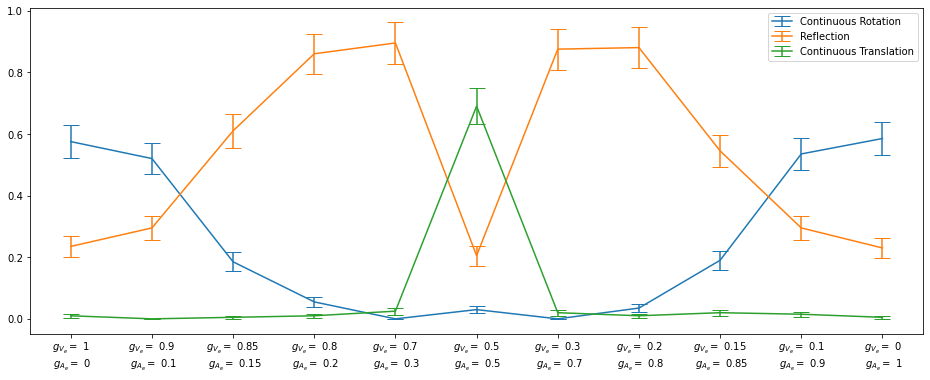

In [8]:
registro = pd.read_csv('registro_200_times_couplings.csv')
rep_todo = 200

etis = []

gve_l = [1,0.9,0.85,0.8,0.7,0.5,0.3,0.2,0.15,0.1,0]
gae_l = [0,0.1,0.15,0.2,0.3,0.5,0.7,0.8,0.85,0.9,1]

for k in range(len(gve_l)):
    etis.append(r'$g_{V_e} =$ '+str(gve_l[k])+'\n $g_{A_e} =$ '+str(gae_l[k]))
    

plt.figure(figsize = [16,6])
plt.errorbar(x = list(range(11)), y = registro.continuous_rotation/rep_todo, 
             yerr = np.sqrt(np.array(registro.continuous_rotation).astype(np.float32))/rep_todo, capsize = 8, label = 'Continuous Rotation')
plt.errorbar(x = list(range(11)), y = registro.reflection/rep_todo, 
             yerr = np.sqrt(np.array(registro.reflection).astype(np.float32))/rep_todo, capsize = 8, label = 'Reflection')
plt.errorbar(x = list(range(11)), y = registro.continuous_translation/rep_todo, 
             yerr = np.sqrt(np.array(registro.continuous_translation).astype(np.float32))/rep_todo, capsize = 8, label = 'Continuous Translation')
plt.xticks(range(11),etis)
plt.legend()
plt.show()

In [47]:
yerr = np.sqrt(np.array(registro.continuous_rotation).astype(np.float32))

In [48]:
yerr

array([7.2111025, 6.4031243, 1.7320508, 0.       , 0.       , 1.7320508,
       1.7320508, 0.       , 1.7320508, 6.4031243, 7.745967 ],
      dtype=float32)

In [73]:
registro = pd.concat(registros)

In [9]:
registro

,Unnamed: 0,continuous_rotation,continuous_translation,discrete_translation,none,reflection
0,0,115,2,14,0,47
1,0,104,0,16,0,59
2,0,37,1,19,0,122
3,0,11,2,1,1,172
4,0,0,5,5,0,179
5,0,6,138,2,0,41
6,0,0,4,10,1,175
7,0,7,2,2,1,176
8,0,38,4,24,0,109
9,0,107,3,5,0,59


# Z2 vs. None Different Couplings

In [37]:
# ----------------------------------- #

target = 'diff_sigma'  # Nombre de la variable que queremos predecir
quantiles = True
range_cols = True   # Si quantiles == True, las columnas distintas de la target las escala entre -1 y 1.
ignore_list = ['Pz1','Pz2', 'E2', 's', 'cos_theta']

nombre_carpeta = 'Ze+e-_couplings_z2_none' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos analizar al mismo tiempo varias bases de datos

n_fea = 13              # Número de features finales que el algoritmo escoge para hacer parejas y analizar con ellas la simetría

lim_sym = 0.7          # Límite de probabilidad para decidir que el algoritmo ha encontrado o no una simetría

limit_pairs = False      # Al generar parejas, estas vienen acompañadas de un 'score'. Si esto es True, cogmos solo la mitad de las con mayor 'score'

select_10k = True       # Keep only 10000 elements of the original potential DF (useful)

interact = False        # 'big', 'small', 'FW', False

rep_todo = 1


gve_l = [1,0.9,0.85,0.8,0.7,0.5,0.3,0.2,0.15,0.1,0]
gae_l = [0,0.1,0.15,0.2,0.3,0.5,0.7,0.8,0.85,0.9,1]

# --------------------------------------#

i=0 
nrr = -1
from time import time
start_time = time()

syms_tot = ['none', 'reflection']
registro = pd.DataFrame(columns = syms_tot)
registros = []

num_g = len(gve_l)

for  gve,gae in zip(gve_l,gae_l):
    
    nrr +=1
    
    print('**** gv_e = {} **** ga_e = {} ****'.format(gve,gae))

    folder_0 = 'cross_section'
    name = 'ze+e-_gve_' + str(gve) + '_gae_' + str(gae) + '.csv'


    df_e = pd.read_csv(os.path.join(folder_0,name))

    categ = []
    numer = []


    for col in list(df_e.columns):
        if (col != target) and (col not in ignore_list):
            if type(df_e[col][0]) == str:
                categ.append(col)
            else:
                numer.append(col)

    splits = RandomSplitter(valid_pct=0)(range_of(df_e))

    to = TabularPandas(df_e,
                    procs=[Categorify,FillMissing],
                    cat_names = categ,
                    cont_names = numer,
                    y_names = target,
                    splits=splits)


    #equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
    #equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

    df_e = pd.DataFrame(to.xs)
    df_e[target] = to.y
    df_e = df_e.reset_index().drop('index', axis = 1)  

    for col in df_e.columns:
        df_e[col] = np.nan_to_num(df_e[col])   
        if quantiles == True:
            n_attempted_bins =  len(df_e[col])
            binning = pd.qcut(df_e[col], q=n_attempted_bins, retbins=True, labels=False, duplicates='drop')
            df_e[col]=binning[0]/np.max(binning[0])
            df_e[col] = np.nan_to_num(df_e[col])
            if (range_cols == True) and (col != target): 
                df_e[col] = df_e[col]*2 - 1





    # ------------------------------------------------------------------------------------------------------------------------#

   

    sym_feat_1 = []
    sym_feat_2 = []
    sym_feat_tags = []
    sym_feat_probs = []
    sym_feat_rmse = []

    # Tiempo en el que empezamos a procesar



    from fastai.vision.all import *
    from time import time
    from IPython.utils import io



    muchos = False # Si es false, para muchos potenciales, mete cada combinación de variables en una carpeta separada, para que sea fácil ver si hay simetría ahí
                   # Si es true, van todos a la misma carpeta


    # ------------------- Folder PCA ------------------- #

    folder = 'Ze+e-_2'   # Carpeta donde se guardan las subcarpetas con las PCAs

    dd = top_dir + '/' + folder
    if not os.path.isdir(dd):
        print('Creating directory:\n',dd)
        os.mkdir(dd)

    dir = os.path.join(top_dir,folder)

    #------------------------------ Generar Potenciales ---------------------------#

    potenciales = [df_e]
    potenciales_tags = [nombre_carpeta for k in range(rep_todo)]
    tags = potenciales_tags
    num_pot = len(potenciales)

    # ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
    # Solo hay un print que se ha eliminado del código original
    class SaveModelCallback(TrackerCallback):
        "A `TrackerCallback` that saves the model's best during training and loads it at the end."
        _only_train_loop = True
        def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                     with_opt=False, reset_on_fit=True):
            super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
            assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
            # keep track of file path for loggers
            self.last_saved_path = None
            store_attr('fname,every_epoch,at_end,with_opt')

        def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

        def after_epoch(self):
            "Compare the value monitored to its best score and save if best."
            if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
            else: #every improvement
                super().after_epoch()
                if self.new_best:
                    #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                    self._save(f'{self.fname}')

        def after_fit(self, **kwargs):
            "Load the best model."
            if self.at_end: self._save(f'{self.fname}')
            elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

    # ---------------- Definiciones previas e hiperparámetros ----------------- #

    #Guardo los modelos para analizarlos luego
    models = [] 
    to_s = []

    #Guardaremos los resultados de la PCA en un array 
    PCA_s = []
    PCA_s_tag = []

    # Hyperparameters: 
    bs_choices = [50000]       # Batch Size
    shape='pipe'               # Shape of the neural network
    layers_choices = [5]       # Number of layers of the net. Default:10 or 5 results with 5
    neurons_choices = [200]    # Number of neurons per layer. Default:200 results with 200
    epoch_choices = [50]      # Number of training epochs. Default:200 results with 100
    lr_choices = [0.01]       # Max learning rate 
    valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
    monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved



    # ---------------------- Entrenar Red Y PCA -----------------------------------#

    j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

    for rtd in range(rep_todo):
        for df in potenciales:

            df[target] = df[target]/np.max(df[target]) #Normalizar la columna objetivo es importante

            #------------------------------ Feature Importance  ---------------------------#

            if select_10k == True:
                if len(df[target]) <= 100*100:
                    print('Too little data to keep 10k points and delete the rest')
                else:
                    print('Keeping 10k points of the original DF')
                    remove_n = len(df[target]) - 10000
                    drop_indices = np.random.choice(df.index, remove_n, replace=False)
                    df_temp = df.drop(drop_indices)
                    df = df_temp.copy()



            if interact == 'big':
                print('---- Big interactions ----')
                bbb = df[target]
                df = df.drop(target,axis = 1)
                df = my_interactions(df, numo_int = 10, verbose = True)
                df[target] = bbb

            elif interact == 'small':
                print('---- Small interactions ----')
                bbb = df[target]
                df = df.drop(target,axis = 1)
                df = my_interactions_small(df, numo_int = 10, verbose = True)
                df[target] = bbb

            elif interact == 'FW':
                print('---- Interactions by featurewiz ----')
                with io.capture_output() as captured2: output = featurewiz(df, target, corr_limit=0.10,
                                                                verbose=0, sep=',', header=0, test_data='',
                                                                category_encoders='',feature_engg='interactions')   
                df = output[1].copy()

            elif interact == False:
                print('No interactions')


            #df = regularize_df(df)

            print('---Selecting Best Features---')
            best_pairs = n_best_rf_phi_k(df, target = target, n = n_fea, nf = 30, lim_corr = 0.85)

            best_n = [best_pairs['f1'][0]] + list(best_pairs['f2'].unique())

            print('Best Features: ',best_n)

            #small_df = df[best_n]
            #small_df[target] = df[target]


            cols = best_n
            a = cols

            verbose = 1



            df_org = df.copy()

            if limit_pairs == True:
                medi = best_pairs.score.median()
                num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])
            else:
                medi = 0
                num_2 = len(best_pairs.score.iloc[np.where(best_pairs.score >= medi)])

            for f1,f2,lll in zip(best_pairs.f1,best_pairs.f2,range(len(best_pairs.f1))):
                if best_pairs.score[lll] >= medi:

                    i+=1

                    print(f1,f2)
                    feas = [f1,f2]

                    # Debemos marcar cada potencial para tener claro a qué tipo de simetria corresponde cada PCA
                    PCA_s_tag.append(tags[j-1])

                    df2 = df[feas + [target]].copy() 
                    #df2 = df2[feas + [target]].copy()

                    #Normlizamos las features y hacemos que vayan entre -1 y 1
                    df2[f1] = 2*(df2[f1]/np.max(df2[f1]))-1
                    df2[f2] = 2*(df2[f2]/np.max(df2[f2]))-1

                    splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

                    to = TabularPandas(df2,
                                    procs=[Categorify,FillMissing, Normalize],
                                    cont_names = feas,
                                    y_names = target,
                                    splits=splits)

                    train_size = len(splits[0])
                    valid_size = len(splits[1])

                    # ----------------- Hyperparameters ------------------- #

                    # Batch Size (a large one)
                    bs=min(random.choice(bs_choices),train_size)  
                    print('{} batch size for training.\n'.format(bs))

                    # Neurons per layer
                    neurons_per_layer = random.choice(neurons_choices)

                    # Number of layers
                    n_layers = random.choice(layers_choices)

                    #Shape of the net: Pipe or funnel
                    if shape == 'pipe':
                        layers=[neurons_per_layer for i in range(n_layers)]

                    if shape == 'funnel':
                        n_eff = n_layers
                        layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

                    print('Training FCNN with layers: ',layers)

                    #Number of epochs
                    n_epoch=random.choice(epoch_choices)
                    print('Training for {} epochs.'.format(n_epoch))

                    # Maximum Learning Rate: (a good value can be found using learn.lr_find())
                    lr_max=float(random.choice(lr_choices))
                    print('Using lr_max = ',format(lr_max))

                    # ----------------------------------------------------- #

                    # --------------- Training the FCNN --------------------#

                    # Load the data into a DataLoader
                    dls = to.dataloaders(bs=bs)

                    # Define a Tabular Learner
                    learn = tabular_learner(dls, layers=layers
                                        #,config=config
                                        #,metrics=[mse],
                                        #y_range = [min(df.bin),max(df.bin)],
                                        #,cbs=ShowGraphCallback()
                                        #,train_bn=False)
                                        )

                    # Train the net 
                    with learn.no_logging():
                        learn.fit_one_cycle(n_epoch=n_epoch
                                            ,lr_max=lr_max
                                            ,cbs=[SaveModelCallback(monitor=monitor)]
                                            )

                        preds, targs = learn.get_preds()

                    ff = (preds-targs)**2/len(targs)
                    ff = sum(ff)
                    RMSE = np.sqrt(ff)
                    #print('RMSE:',float(RMSE))
                    nrmsei = float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))

                    # Guardamos modelos y tabular objects para el posterior analisis
                    models.append(learn)
                    to_s.append(to)

                    # ------------------------------------------------------#


                    # ------------------------- PCA ------------------------#

                    test_df = df2.copy()
                    dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

                    # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
                    # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
                    with Hooks(learn.model.layers, lambda m,i,o: o) as h:
                        preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

                    targets=preds[2].numpy().flatten()

                    # Cogemos la información de la penúltima capa
                    # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
                    # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
                    act = h.stored[-2] 
                    multi_dim=Tensor.cpu(act).numpy()
                    standardized=StandardScaler().fit_transform(multi_dim)

                    viz = PCA(2).fit_transform(np.nan_to_num(standardized))
                    #plt.figure()
                    #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')

                    PCA_s.append(viz)

                    # ------------------------------------------------------ #

                    # ------------------ Saving the PCA's ------------------ #

                    # ---- Dar formato a PCA para guardar como imagen con color

                    viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
                    viz.columns = ['x','y'] #Nombres de las columnas

                    # Insertamos una columna con los colores de los puntos. El valor del potencial
                    # objetivo (targets) es el color, y hay un color por cada punto 
                    viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

                    # ---- Personalizar mapa de color 

                    n_classes=1000

                    colors = 'rainbow'

                    if colors == 'rainbow':
                        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                        classes_in_rgb = my_cmap(range(n_classes))
                    if colors == 'purple':
                        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
                        classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

                    # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
                    #      acumuldos en un pixel

                    n_pixels = 224

                    binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

                    #if we want the pixel intensity to reprensent the number of points at that location
                    array = np.dot(binning_3d[0],classes_in_rgb)
                    array = array/np.amax(array)

                    # ---- Guardar la PCA

                    #Directorio donde guardaremos las imagenes
                    nami = str(nrr)+'_'+'ze+e-_gve_' + str(gve) + '_gae_' +str(gae)+'_'
                    if muchos == False: 
                        dir_sym = os.path.join(dir,tags[j-1],nami)
                        img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'__PCA.png' 
                    else:
                        dir_sym = os.path.join(dir,tags[j-1])
                        img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+nami+'__PCA.png' 

                    if not os.path.isdir(dir_sym):
                        print('Creating directory:\n',dir_sym)
                        os.makedirs(dir_sym)


                    # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
                    output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
                    plt.imsave(output_dir,array) # Guardar
                    print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))


                    # ------------------------ Symmetry Analyzer --------------------- #
                    drr = pca_sym_finder_Z2_none(output_dir)
                    brr = list(drr.iloc[np.where(drr.value > lim_sym)].symmetry)
                    if len(brr) > 0:
                        print('Found {} symmetry with features {} and {}, with prob. {}'.format(brr[0],f1,f2,float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4))))                
                        sym_feat_1.append(f1)
                        sym_feat_2.append(f2)
                        sym_feat_tags.append(brr[0])
                        sym_feat_probs.append(float(np.round(drr.iloc[np.where(drr.value > lim_sym)].value,4)))
                        sym_feat_rmse.append(nrmsei)




                    # ------------------------ Time -------------------------#

                    minutes_until_now = (time() - start_time)/60
                    images_done = i
                    minutes_per_image = minutes_until_now/(images_done)
                    hours_left = minutes_per_image * (num_pot*rep_todo*num_2*num_g-images_done)/60
                    print("\n{} PCA's made out of {}.\n".format(images_done,num_pot*num_2*rep_todo*num_g))
                    print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
                    print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
                    print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot*num_2*rep_todo*num_g-images_done))
                    print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot*num_2*rep_todo*num_g-images_done))




        j+=1


              # ------------------------------------------------------#'''

    results = pd.DataFrame({'symmetry':sym_feat_tags, 'feature_1':sym_feat_1, 'feature_2':sym_feat_2, 'probability':sym_feat_probs, 'NRMSE':sym_feat_rmse})

    vc = results.symmetry.value_counts()



    for sym_sum in syms_tot:
        if not hasattr(vc,sym_sum):
            vc[sym_sum] = 0


    nr = pd.DataFrame({'none':vc['none'], 
                       'reflection':vc['reflection']}, index = [0])

    registro = registro.append(nr, ignore_index=True)
    

    registros.append(nr)


'''    plt.xticks(rotation = -15)
    plt.ylim([0,1])
    print(registro.columns)
    print(registro.sum()/registro.sum().sum())
    plt.bar(registro.columns,registro.sum()/registro.sum().sum(), yerr = np.sqrt(registro.sum())/registro.sum().sum(), capsize = 8)
'''

print(0)

**** gv_e = 1 **** ga_e = 0 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Px1', 'Py1']
Px1 Py1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/0_ze+e-_gve_1_gae_0_/Ze+e-_couplings_z2_none_11638447221__PCA.png



Found reflection symmetry with features Px1 and Py1, with prob. 1.0

1 PCA's made out of 11.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
0.8 minutes estimated left for 10 images.



0.0 hours estimated left for 10 images.



**** gv_e = 0.9 **** ga_e = 0.1 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px1']
Py1 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/1_ze+e-_gve_0.9_gae_0.1_/Ze+e-_couplings_z2_none_11638447226__PCA.png



Found reflection symmetry with features Py1 and Px1, with prob. 1.0

2 PCA's made out of 11.

0.2 minutes elapsed for 2 images.
0.1 minutes average per image.
0.7 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



**** gv_e = 0.85 **** ga_e = 0.15 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/2_ze+e-_gve_0.85_gae_0.15_/Ze+e-_couplings_z2_none_11638447230__PCA.png



Found reflection symmetry with features Py2 and Px1, with prob. 1.0

3 PCA's made out of 11.

0.2 minutes elapsed for 3 images.
0.1 minutes average per image.
0.6 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



**** gv_e = 0.8 **** ga_e = 0.2 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px1']
Py2 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/3_ze+e-_gve_0.8_gae_0.2_/Ze+e-_couplings_z2_none_11638447234__PCA.png



Found reflection symmetry with features Py2 and Px1, with prob. 1.0

4 PCA's made out of 11.

0.3 minutes elapsed for 4 images.
0.1 minutes average per image.
0.5 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



**** gv_e = 0.7 **** ga_e = 0.3 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Px1', 'Py1']
Px1 Py1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/4_ze+e-_gve_0.7_gae_0.3_/Ze+e-_couplings_z2_none_11638447238__PCA.png



Found reflection symmetry with features Px1 and Py1, with prob. 1.0

5 PCA's made out of 11.

0.4 minutes elapsed for 5 images.
0.1 minutes average per image.
0.4 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



**** gv_e = 0.5 **** ga_e = 0.5 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px2']
Py2 Px2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/5_ze+e-_gve_0.5_gae_0.5_/Ze+e-_couplings_z2_none_11638447242__PCA.png



Found reflection symmetry with features Py2 and Px2, with prob. 1.0

6 PCA's made out of 11.

0.4 minutes elapsed for 6 images.
0.1 minutes average per image.
0.4 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



**** gv_e = 0.3 **** ga_e = 0.7 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Px1', 'Py2']
Px1 Py2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/6_ze+e-_gve_0.3_gae_0.7_/Ze+e-_couplings_z2_none_11638447246__PCA.png



Found reflection symmetry with features Px1 and Py2, with prob. 1.0

7 PCA's made out of 11.

0.5 minutes elapsed for 7 images.
0.1 minutes average per image.
0.3 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



**** gv_e = 0.2 **** ga_e = 0.8 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Px1', 'Py2']
Px1 Py2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/7_ze+e-_gve_0.2_gae_0.8_/Ze+e-_couplings_z2_none_11638447250__PCA.png



Found reflection symmetry with features Px1 and Py2, with prob. 1.0

8 PCA's made out of 11.

0.6 minutes elapsed for 8 images.
0.1 minutes average per image.
0.2 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



**** gv_e = 0.15 **** ga_e = 0.85 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px1']
Py1 Px1
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/8_ze+e-_gve_0.15_gae_0.85_/Ze+e-_couplings_z2_none_11638447254__PCA.png



Found reflection symmetry with features Py1 and Px1, with prob. 1.0

9 PCA's made out of 11.

0.6 minutes elapsed for 9 images.
0.1 minutes average per image.
0.1 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



**** gv_e = 0.1 **** ga_e = 0.9 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py2', 'Px2']
Py2 Px2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/9_ze+e-_gve_0.1_gae_0.9_/Ze+e-_couplings_z2_none_11638447258__PCA.png



Found reflection symmetry with features Py2 and Px2, with prob. 1.0

10 PCA's made out of 11.

0.7 minutes elapsed for 10 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



**** gv_e = 0 **** ga_e = 1 ****
Keeping 10k points of the original DF
No interactions
---Selecting Best Features---
Best Features:  ['Py1', 'Px2']
Py1 Px2
8000 batch size for training.

Training FCNN with layers:  [200, 200, 200, 200, 200]
Training for 50 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Ze+e-_2/Ze+e-_couplings_z2_none/10_ze+e-_gve_0_gae_1_/Ze+e-_couplings_z2_none_11638447263__PCA.png



Found reflection symmetry with features Py1 and Px2, with prob. 1.0

11 PCA's made out of 11.

0.8 minutes elapsed for 11 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.



0


In [31]:
registro=pd.concat(registros)

Notebook directory: /home/gabriel/Desktop
Numero Imagenes: 111
Numero Imagenes: 222
Numero Imagenes: 333
Numero Imagenes: 444
Numero Imagenes: 555
Numero Imagenes: 666
Numero Imagenes: 777
Numero Imagenes: 888
Numero Imagenes: 999
Numero Imagenes: 1110
Numero Imagenes: 1221
['0_ze+e-_gve_1_gae_0_' '10_ze+e-_gve_0_gae_1_' '1_ze+e-_gve_0.9_gae_0.1_'
 '2_ze+e-_gve_0.85_gae_0.15_' '3_ze+e-_gve_0.8_gae_0.2_'
 '4_ze+e-_gve_0.7_gae_0.3_' '5_ze+e-_gve_0.5_gae_0.5_'
 '6_ze+e-_gve_0.3_gae_0.7_' '7_ze+e-_gve_0.2_gae_0.8_'
 '8_ze+e-_gve_0.15_gae_0.85_' '9_ze+e-_gve_0.1_gae_0.9_']
['none', 'reflection']
[0.00824527 0.99175473]


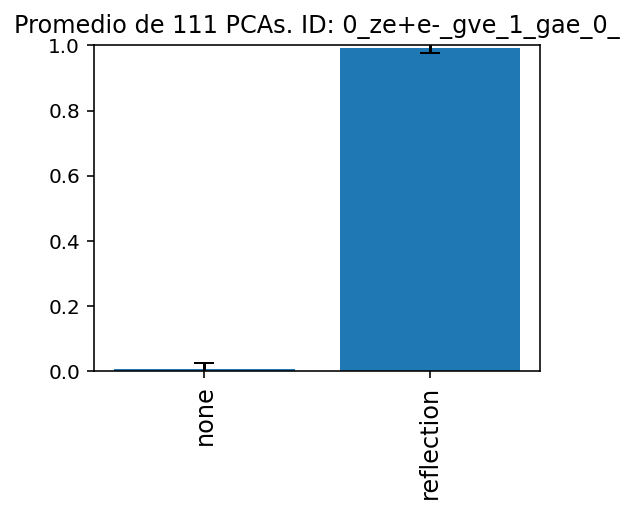

[6.99655898e-05 9.99930038e-01]


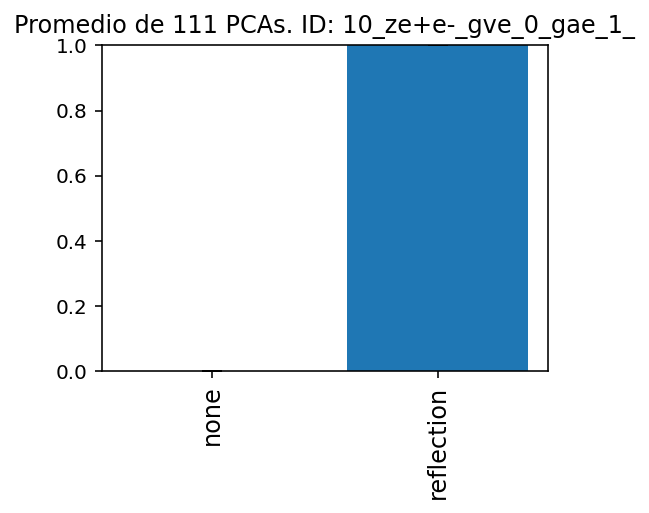

[0.00329882 0.99670118]


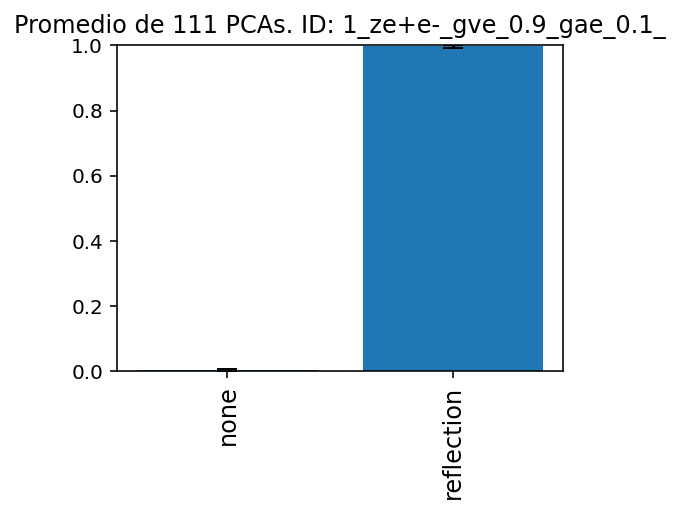

[0.00433154 0.99566845]


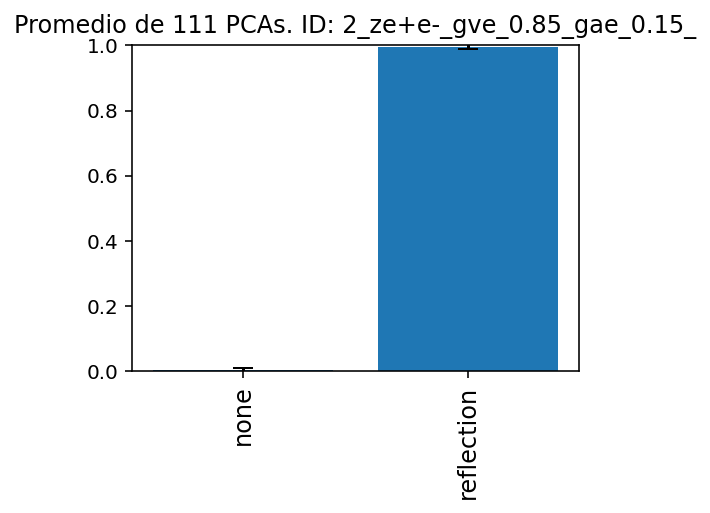

[0.04592261 0.95407739]


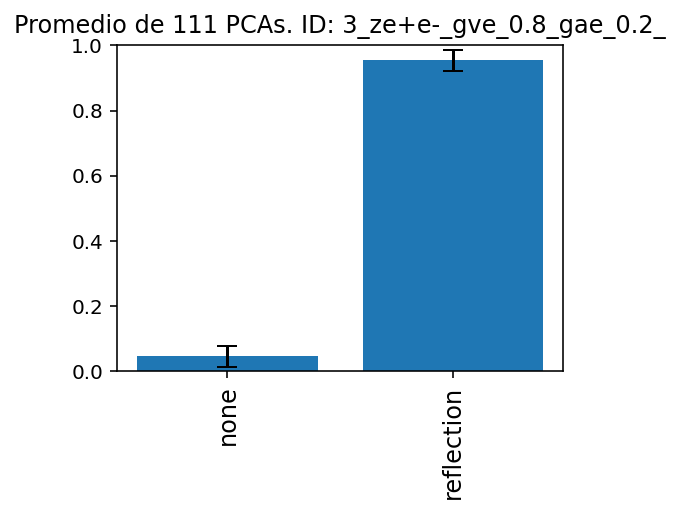

[0.02126051 0.97873949]


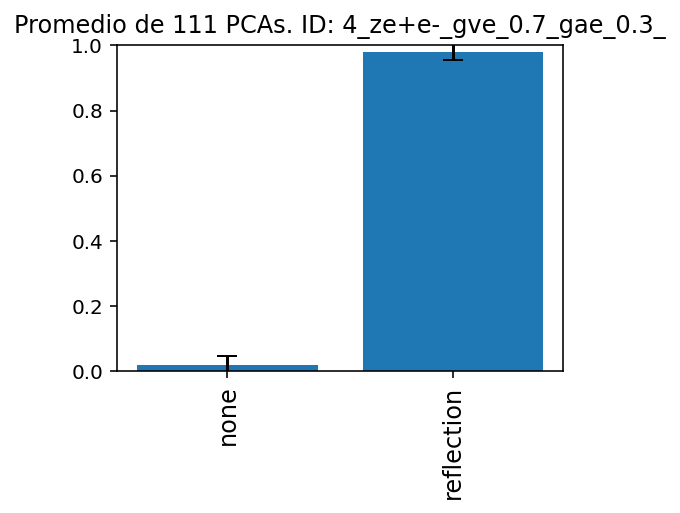

[0.0222981 0.9777019]


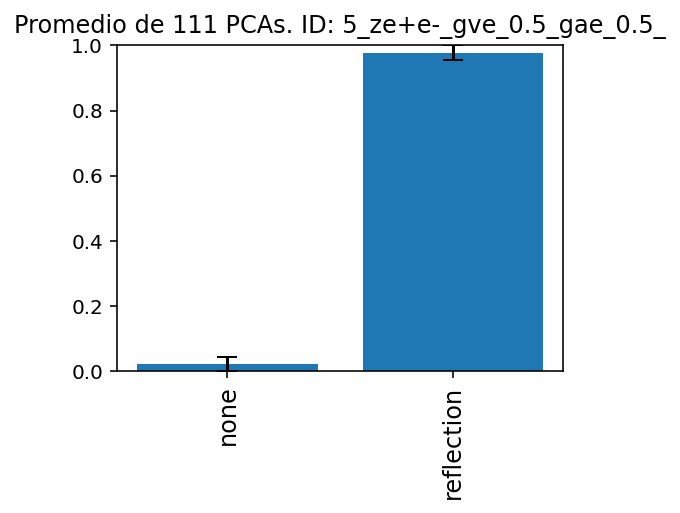

[0.02799649 0.97200351]


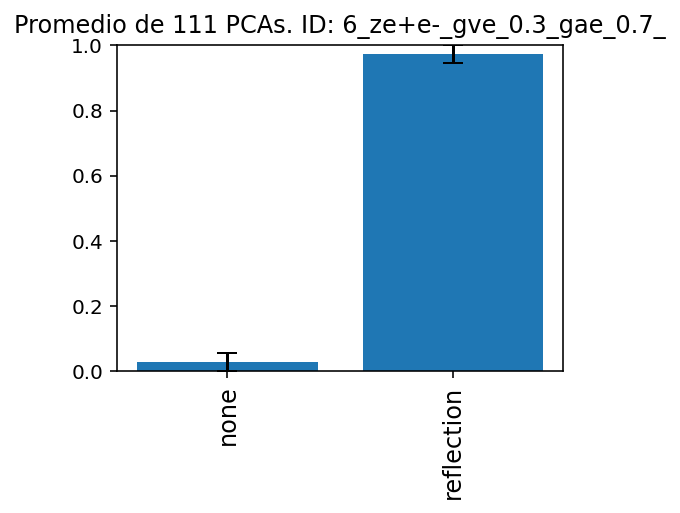

[0.0643821 0.9356179]


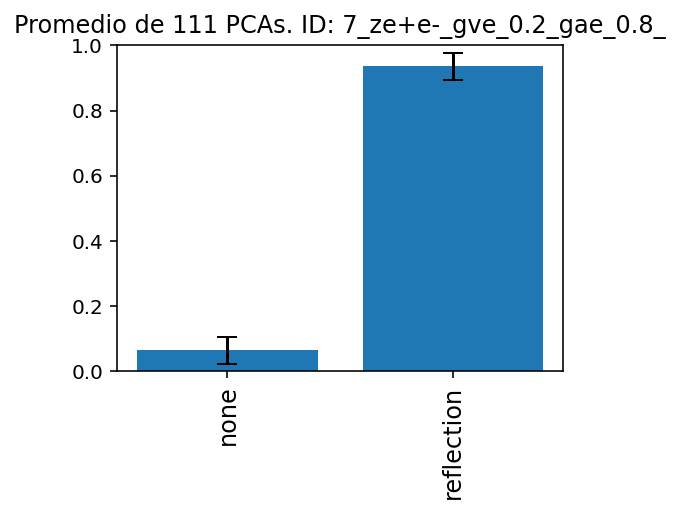

[0.0027563 0.9972437]


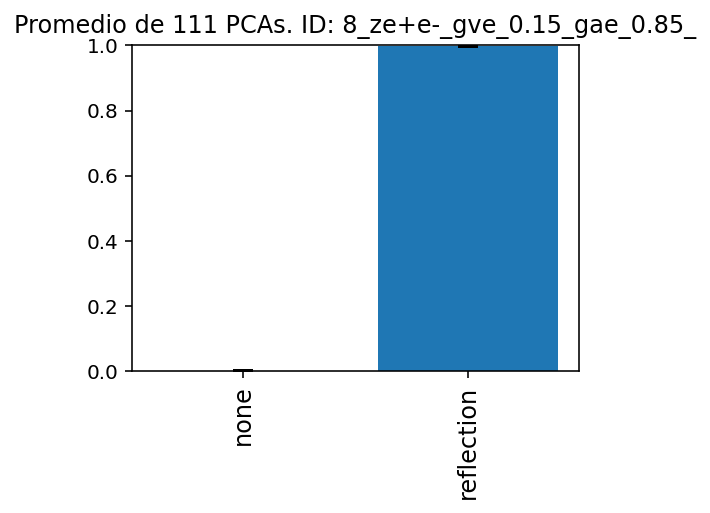

[0.01175331 0.98824669]


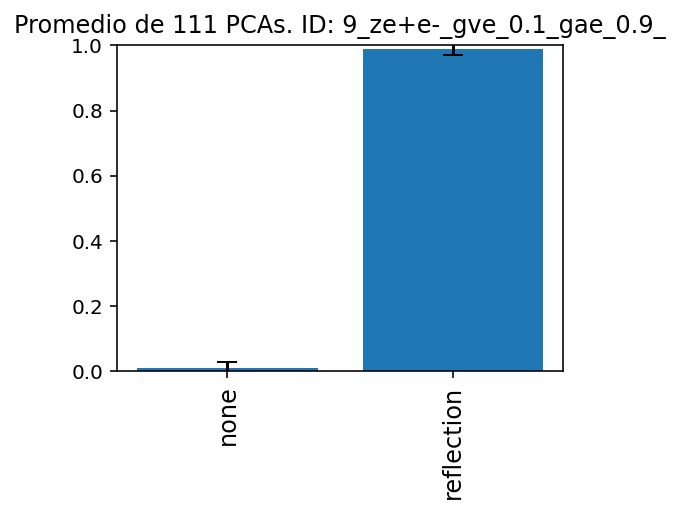

In [38]:
nom_carp = 'Ze+e-_couplings_z2_none'

#import libraries
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 0px !important;}</style>"))

from time import time
import os
import glob
from fastai.vision.all import *
import numpy as np
from IPython.display import clear_output
import itertools as it
import more_itertools
#import torchvision.models
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default ="none"
import base64
from PIL import Image
from io import BytesIO
import torch
import gc
#import libraries

if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you changed the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir



modelo = 'G' # J or G

if modelo == 'G':
    learn = load_learner('/home/gabriel/Desktop/models/model_93_accu_resnet18_10+5_none+reflection'+'.pkl', cpu=False)

if modelo == 'J':
    learn=load_learner(model_name+'.pkl',cpu=False)
        

#Reset Registro

columns = ['ID', 'Run'] + list(learn.dls.vocab)

registro = pd.DataFrame(columns = columns)
#registro


num_img_cat = [] #guardo el numero de imagenes de cada categoria
i = 0
plote = False

sims = pd.DataFrame(columns = learn.dls.vocab)
errs = sims.copy()

num_img_cat = [] #guardo el numero de imagenes de cada categoria
i = 0
plote = False

from IPython.utils import io


for dires in np.sort(Path('/home/gabriel/Desktop/Ze+e-_2/' + nom_carp).ls()):
    #path = Path('/home/gabriel/Desktop/PCA_INE_sexo/INE/'+quitadas)
    quitadas = str(dires).split('/')[-1]
    with io.capture_output() as captured:
        for ima in dires.ls():

            test_im_dir = ima

            im = PILImage.create(test_im_dir)

            # Orden: ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']

            cate, num_cat, probs = learn.predict(im)


            '''
            if plote == True:
                plt.figure
                plt.figure(figsize=(4, 3))
                plt.title(ima)
                plt.bar(['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection'],probs)
                plt.xticks(rotation='vertical',fontsize = 12)
                plt.show()
            '''

            new_row = np.array([quitadas, i] + list(np.array(probs).astype(float))).reshape([1,-1])
            aden = pd.DataFrame(new_row,columns=registro.columns)

            registro = registro.append(aden, ignore_index=True)

            i+=1

    registro = registro.astype({'ID':str, 'Run':int, 'none':float, 'reflection':float })  

    print('Numero Imagenes:',i,)
    num_img_cat.append(i)


print(registro['ID'].unique())

#registro = pd.read_csv('/home/gabriel/Desktop/PCA_INE_sexo/registro.csv')

nombres_carps = registro['ID'].unique() #Nombres de las carpetas donde estan guyardadas las pcas de un tipo
num_carps = len(nombres_carps)

#registro = pd.read_csv('/home/gabriel/Desktop/PCA_INE_sexo/registro.csv')


i = 0


for nom in np.sort(nombres_carps):
    if i == 0:
        m_probs = np.array(registro.iloc[:num_img_cat[0],2:].mean())
        err_probs = np.array(registro.iloc[:num_img_cat[0],2:].std())
        nume = str(len(registro.iloc[:num_img_cat[0],2:]))
        print(learn.dls.vocab)
        print(m_probs)
        sims = sims.append(pd.DataFrame([m_probs], columns = sims.columns),ignore_index = True)
        errs = errs.append(pd.DataFrame([err_probs/np.sqrt(float(nume))], columns = errs.columns),ignore_index = True)
    else:
        m_probs = np.array(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:].mean())
        err_probs = np.array(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:].std())
        nume = str(len(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:]))
        print(m_probs)
        sims = sims.append(pd.DataFrame([m_probs], columns = sims.columns),ignore_index = True)
        errs = errs.append(pd.DataFrame([err_probs/np.sqrt(float(nume))], columns = errs.columns),ignore_index = True)

    if nom == '-ninguna-':
        tit = 'Promedio de '+nume+' PCAs sin quitar ninguna columna'
    else:
        tit = 'Promedio de '+nume+' PCAs. ID: '+ nom        

    
    plt.figure(figsize=(4, 3))
    plt.title(tit)
    #plt.title('Promedio de '+str(40)+' PCAs sin quitar ninguna columna')
    plt.bar(columns[2:],
            m_probs,yerr = 2*err_probs/np.sqrt(float(nume)), capsize = 5)
    plt.xticks(rotation='vertical',fontsize = 12)
    plt.ylim([0, 1])
    plt.show()

    
    i+=1

In [23]:
sims

,none,reflection
0,0.001090,0.998910
1,0.000022,0.999978
2,0.127253,0.872747
3,0.000002,0.999998
4,0.093571,0.906429
5,0.001523,0.998477
6,0.000011,0.999990
7,0.099668,0.900332
8,0.000001,0.999999
9,0.000034,0.999966


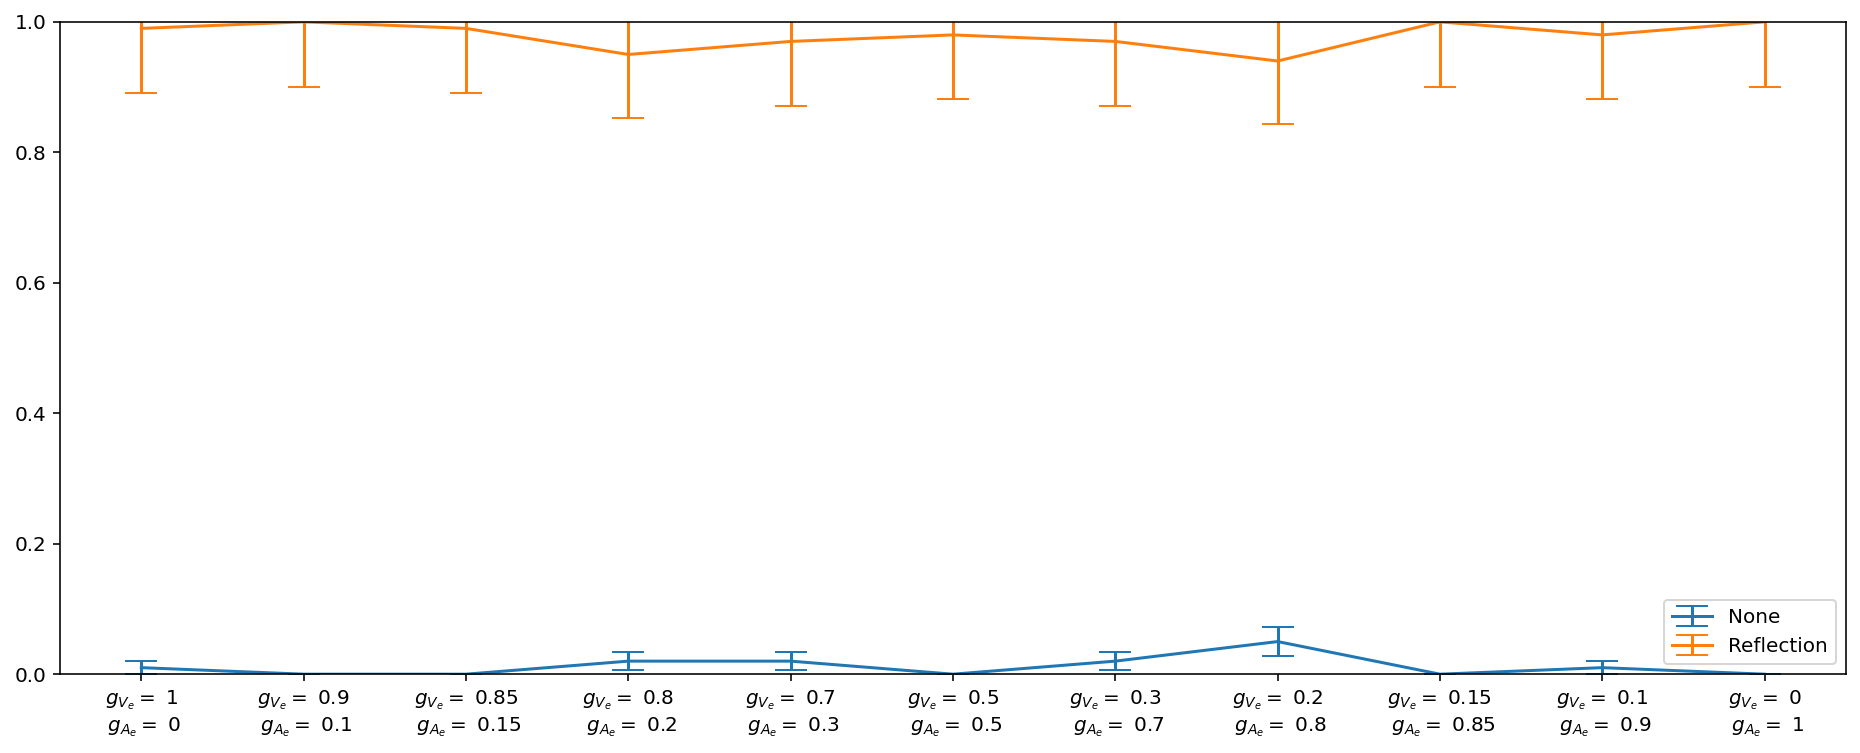

In [34]:
#registro = pd.read_csv('registro_200_times_couplings.csv')
rep_todo = 100

etis = []

gve_l = [1,0.9,0.85,0.8,0.7,0.5,0.3,0.2,0.15,0.1,0]
gae_l = [0,0.1,0.15,0.2,0.3,0.5,0.7,0.8,0.85,0.9,1]

for k in range(len(gve_l)):
    etis.append(r'$g_{V_e} =$ '+str(gve_l[k])+'\n $g_{A_e} =$ '+str(gae_l[k]))
    

plt.figure(figsize = [16,6])
plt.errorbar(x = list(range(11)), y = registro.none/rep_todo, 
             yerr = np.sqrt(np.array(registro.none).astype(np.float32))/rep_todo, capsize = 8, label = 'None')
plt.errorbar(x = list(range(11)), y = registro.reflection/rep_todo, 
             yerr = np.sqrt(np.array(registro.reflection).astype(np.float32))/rep_todo, capsize = 8, label = 'Reflection')

plt.xticks(range(11),etis)
plt.ylim([0,1])
plt.legend()
plt.show()